In [863]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [864]:
%run /home/datarian/git/master-thesis-code/notebooks/common_init.ipynb

<Figure size 432x288 with 0 Axes>

Setup logging to file: out.log
Figure output directory saved in figure_output at /home/datarian/OneDrive/unine/Master_Thesis/ma-thesis-report/figures


In [865]:
%run /home/datarian/git/master-thesis-code/notebooks/learning_init.ipynb

Set plot_confusion_matrix(), prepare_result_store(), update_result() and run_experiments()


In [866]:
%autoreload 2

import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# Load custom code
import kdd98.data_handler as dh
from kdd98.config import Config
from kdd98.transformers import Rescaler
import pathlib
import pickle

from collections import Counter
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.metrics import classification_report_imbalanced
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, FunctionTransformer
from sklearn.model_selection import ParameterGrid, GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit, StratifiedKFold
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import confusion_matrix, precision_recall_curve, make_scorer, log_loss, r2_score, precision_score, f1_score, recall_score, auc, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.linear_model import ElasticNetCV, BayesianRidge
from sklearn.svm import SVC, SVR
from glmnet import LogitNet
from sklearn.neural_network import MLPClassifier
from sklearn.base import BaseEstimator, TransformerMixin

In [867]:
# Where to save the figures

CHAPTER_ID = "learning"
# Where to save the figures
IMAGES_PATH = pathlib.Path(figure_output, CHAPTER_ID)
sns.set_context("poster")
sns.set_palette(Config.get("qual_palette"))
plt.rcParams['figure.figsize'] = (1.618*10, 10)

pathlib.Path(IMAGES_PATH).mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension=["pdf", "png"], resolution=300):
    if tight_layout:
        plt.tight_layout()
    [plt.savefig(pathlib.Path(IMAGES_PATH, fig_id + "." + f), 
                 format=f,
                 dpi=resolution,
                 transparent=True,
                 bbox_inches='tight') for f in fig_extension]

In [868]:
setup_file_logger("learning.log")

# Loading data, setting up common objects

## Loading Data

In [869]:
learning_provider = dh.KDD98DataProvider("cup98LRN.txt")

We directly load the imputed and boruta-filtered data:

In [870]:
learning = learning_provider.all_relevant_data

## Splitting into learning and validation sets 

We want to preserve this ratio in the split datasets. scikit-learn provides stratified samplers for this task. We use a stratified shuffle split, where examples are first shuffled. We also extract TARGET_D to use it for weighing samples. This should help in learning models that are better at capturing the high-dollar donors.

In [871]:
seed = Config.get("random_seed")
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, train_size=0.8, random_state=seed)
for learn_index, val_index in splitter.split(learning["data"], learning["targets"].TARGET_B):
    X_train = learning["data"].iloc[learn_index]
    y_train = learning["targets"].iloc[learn_index,:]
    sample_weights = learning["targets"].TARGET_D.iloc[learn_index]
    X_val = learning["data"].iloc[val_index]
    y_val = learning["targets"].iloc[val_index,:]
    sample_weights_val = learning["targets"].TARGET_D.iloc[val_index]

In [872]:
class_weight = len(y_train.TARGET_B[y_train.TARGET_B==0])/sum(y_train.TARGET_B)
class_weight = {0:1, 1:class_weight}
class_weight

{0: 1, 1: 18.70289106866288}

Now, check that the two sets are really disjoint

In [429]:
set(X_train.index).intersection(X_val.index)

set()

Check the frequencies of the donors in the sets:

In [430]:
y_train.TARGET_B.value_counts(normalize=True)

0    0.949246
1    0.050754
Name: TARGET_B, dtype: float64

In [431]:
X_train.shape

(76329, 58)

In [432]:
sample_weights.shape

(76329,)

In [433]:
y_val.TARGET_B.value_counts(normalize=True)

0    0.949222
1    0.050778
Name: TARGET_B, dtype: float64

In [434]:
X_val.shape

(19083, 58)

## RV generators for parameter distributions

In [435]:
from scipy.stats import randint as sp_rint
from scipy.stats import uniform as sp_unif
from scipy.stats import bernoulli as sp_bern
from scipy.stats import rv_discrete as sp_discr

np.random.seed(seed=Config.get("random_seed")) # needed for RV generators

# Classifiers 

## Scores for CV validation

In [673]:
# Scoring metrics for grid seach

scoring = {"auc": make_scorer(roc_auc_score),
           "logloss": make_scorer(log_loss),
           "recall": make_scorer(recall_score),
           "f1": make_scorer(f1_score)}

scoring = {"auc": make_scorer(roc_auc_score),
           "logloss": make_scorer(log_loss),
           "recall": make_scorer(recall_score)}

## Resampling

SMOTE is used to generate synthetic samples from the minority class. The variant is borderline, which generates samples close to the optimal decision boundary.

In [439]:
smote_resampling = BorderlineSMOTE(random_state=Config.get("random_seed"))
X_resampled, y_resampled = smote_resampling.fit_resample(X_train.values, y_train.TARGET_B.values)

In [440]:
print(sorted(Counter(y_resampled).items()))

[(0, 72455), (1, 72455)]


## Initializing classifiers

### Random Forest

In [667]:
rf_classifier = RandomForestClassifier(
    n_jobs=-1,
    random_state=Config.get("random_seed"))

rf_sampler = BorderlineSMOTE(random_state=Config.get("random_seed"))

rf_pipe = Pipeline([
    ("sampler", rf_sampler),
    ("classifier", rf_classifier)])

### Gradient Boosting

In [483]:
#gbm_classifier = GradientBoostingClassifier(
#    subsample=0.5,
#    max_depth=3,
#    max_features=0.5,
#    scale_pos_weight=18,
#    random_state=Config.get("random_seed"))

gbm_classifier = XGBClassifier(
    booster="gbtree",
    subsample=0.5,
    max_depth=6, # 3
    colsample_by_tree=0.7,
    seed=Config.get("random_seed"),
    verbose=2)

gbm_sampler = BorderlineSMOTE(random_state=Config.get("random_seed"))

gbm_pipe = Pipeline([
    ("sampler", gbm_sampler),
    ("classifier", gbm_classifier)
])

###  GLMnet

In [444]:
logitnet = LogitNet(
    n_splits=10,
    max_iter=1e6,
    scoring="recall",
    standardize=False,
    random_state=Config.get("random_seed"))

glmnet_sampler = BorderlineSMOTE(random_state=Config.get("random_seed"))
glmnet_scaler = PowerTransformer(method="yeo-johnson", standardize=True)

glmnet_pipe = Pipeline([
    ("scaler", glmnet_scaler),
    ("sampler", glmnet_sampler),
    ("classifier", logitnet)
])

### Nnet 

In [445]:
nnet = MLPClassifier(solver="adam",
                     early_stopping=True,
                     learning_rate="adaptive", # new
                     random_state=Config.get("random_seed"))

nnet_sampler = BorderlineSMOTE(random_state=Config.get("random_seed"))
nnet_scaler = PowerTransformer(method="yeo-johnson", standardize=True)

nnet_pipe = Pipeline([
    ("scaler", nnet_scaler),
    ("sampler", nnet_sampler),
    ("classifier", nnet)
])

The network that cristallizes is a quite complex structure, but with a heavy L2 penalty, keeping the coefficients small.

### SVM Classifier

In [446]:
svc = SVC(
    class_weight=class_weight,
    kernel="poly",
    degree=3,
    probability=True,
    cache_size=1000,
    gamma="auto",
    random_state=Config.get("random_seed"))

svm_sampler = BorderlineSMOTE(random_state=Config.get("random_seed"))
svm_scaler = PowerTransformer(method="yeo-johnson", standardize=True)

svm_pipe = Pipeline([
    ("scaler", svm_scaler),
    ("sampler", svm_sampler),
    ("classifier", svc)
])

## Fitting and results

### Helpers

In [526]:
def print_cv_results(refit):
    results_file = "classifiers_refit_{}.pkl".format(refit)
    with open(pathlib.Path(Config.get("model_store"), results_file), "rb") as f:
        gridsearch_results = pickle.load(f)
    for m in gridsearch_results:
        if gridsearch_results[m]["best_estimator"]:
            cv_results = gridsearch_results[m]
            print("Model {}".format(m))
            print(classification_report_imbalanced(y_val.TARGET_B.values,cv_results["best_estimator"].predict(X_val.values)))
            results = cv_results["cv_results"].sort_values(by='mean_test_{}'.format(refit), ascending=False)
            print("Mean scores")
            print(results[[k for k, v in results.iteritems() if k.startswith("mean_test_")]].round(3))
            #print(results[['mean_test_f1', 'mean_test_recall', 'mean_test_auc']].round(3))
            if "best_params" in gridsearch_results[m].keys():
                print("Best params")
                print(gridsearch_results[m]["best_params"])
            print("*******************************************************")

In [448]:
def print_confusion_matrices(refit):
    results_file = "classifiers_refit_{}.pkl".format(refit)
    with open(pathlib.Path(Config.get("model_store"), results_file), "rb") as f:
        gridsearch_results = pickle.load(f)

    for m in gridsearch_results:
        if gridsearch_results[m]["best_estimator"]:
            y_predict = gridsearch_results[m]["best_estimator"].predict(X_val.values)
            gridsearch_results[m]["y_pred"] = y_predict
            print("Confusion matrix for model {}".format(m))
            plot_confusion_matrix(y_val.TARGET_B.values, y_predict, [1,0], title=m)
            save_fig("confusion_matrix_model_{}_refit_{}".format(m, refit))

In [784]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

In [785]:
def print_roc_auc_curve(refit, print_title=True):
    results_file = "classifiers_refit_{}.pkl".format(refit)
    with open(pathlib.Path(Config.get("model_store"), results_file), "rb") as f:
        gridsearch_results = pickle.load(f)

    def roc_curve_data(estimator):
        try:
            y_score = estimator.score(X_val.values)
        except Exception:
            y_score = estimator.predict_proba(X_val.values)[:,1]

        fpr, tpr, thresholds = roc_curve(y_val.TARGET_B.values, y_score, pos_label=1)
        return (fpr, tpr, thresholds)
    
    fig = plt.figure(figsize=(10,10))

    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.xlim(0.0,1.0)
    plt.ylim(0.0,1.0)
    plt.plot([0, 1], [0, 1], color='black', lw=1.5, linestyle='--')

    for m in gridsearch_results:
        if gridsearch_results[m]["best_estimator"]:
            fpr, tpr, thresholds = roc_curve_data(gridsearch_results[m]["best_estimator"])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=1, label="{}, area = {:.2}".format(m, roc_auc))
    plt.legend(loc="lower right", title="Metric: {}".format(refit))
    set_size(8,8)
    save_fig("roc_auc_compared_refit_{}".format(refit))

In [786]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature

def print_precision_recall_curve(refit, print_title=True):
    
    results_file = "classifiers_refit_{}.pkl".format(refit)
    with open(pathlib.Path(Config.get("model_store"), results_file), "rb") as f:
        gridsearch_results = pickle.load(f)
        
    def p_r_data(estimator):
        try:
            y_score = estimator.score(X_val.values)
        except Exception:
            y_score = estimator.predict_proba(X_val.values)[:,1]
        p, r, _ = precision_recall_curve(y_val.TARGET_B.values, y_score)
        
        fpr, tpr, thresholds = roc_curve(y_val.TARGET_B.values, y_score, pos_label=1)
        return (p, r)
    
    fig = plt.figure(figsize=(10,10))
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])

    for m in gridsearch_results:
        if gridsearch_results[m]["best_estimator"]:
            p, r = p_r_data(gridsearch_results[m]["best_estimator"])
            plt.plot(r, p, lw=1.5, label="{}".format(m))
    plt.legend(loc="upper right", title="Metric: {}".format(refit))
    set_size(8,8)
    save_fig("prec_rec_compared_refit_{}".format(refit))

In [787]:
def run_experiments(X_train, y_train, config, scoring, splits, refit):
    results_file = "classifiers_refit_{}.pkl".format(refit)
    
    for m in config:
        if config[m]["run"]:
            params = config[m]["param_grid"]
            pipe = config[m]["pipeline"]
            fit_params = config[m]["fit_params"]
            log("Starting gridsearch for {}".format(m))
            cv = StratifiedKFold(n_splits=splits, random_state=Config.get("random_seed"))
            gridsearch = RandomizedSearchCV(
                pipe,
                params,
                scoring=scoring,
                n_jobs=-1,
                cv=cv,
                pre_dispatch=4, # Limit dispatching to prevent memory overflow
                refit=refit,
                return_train_score=True,
                verbose=10)
            if fit_params:
                try:
                    gridsearch.fit(X_train, y_train, **fit_params)
                except Exception as e:
                    log("Fitting failed for {}. Message: {}".format(m, e))
                    break
            else:
                try:
                    gridsearch.fit(X_train, y_train)
                except Exception as e:
                    log("Fitting failed for {}. Message: {}".format(m, e))
                    break
            update_result(m, gridsearch, results_file)
        else:
            log("Skipping {}".format(m))

### Parameter grids 

In [666]:
experiment_configs = {
    m: {
        "param_grid": None,
        "pipeline": None,
        "fit_params": None,
        "run": True
    }
    for m in ["RF", "GBM", "GLMnet", "NNet", "SVM"]
}

#### RF

{'classifier__max_features': 2, 'classifier__min_samples_split': 6, 'classifier__n_estimators': 2057}

{'classifier__max_features': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 2337}

{'classifier__max_features': 1, 'classifier__min_samples_split': 6, 'classifier__n_estimators': 2289}

{'classifier__max_depth': 4, 'classifier__max_features': 1, 'classifier__min_samples_split': 6, 'classifier__n_estimators': 2214}

{'classifier__max_features': 4, 'classifier__min_samples_split': 3, 'classifier__n_estimators': 2333}

In [452]:
{'classifier__max_depth': 4, 'classifier__max_features': 2, 'classifier__min_samples_split': 3, 'classifier__n_estimators': 1184, 'sampler__sampling_strategy': 0.8940688564472721}

{'classifier__max_depth': 3, 'classifier__max_features': 2, 'classifier__min_samples_split': 3, 'classifier__n_estimators': 1555, 'sampler__sampling_strategy': 0.9955801337508542}

{'classifier__max_depth': 3,
 'classifier__max_features': 2,
 'classifier__min_samples_split': 3,
 'classifier__n_estimators': 1555,
 'sampler__sampling_strategy': 0.9955801337508542}

In [668]:
param_grid_rf = {
    "sampler__sampling_strategy": sp_unif(0.7,0.3),
    "classifier__min_samples_split": [3],
    "classifier__max_features": [2],
    "classifier__n_estimators": sp_rint(1500,2000),
    "classifier__max_depth": [3]
}

In [669]:
experiment_configs["RF"]["param_grid"] = param_grid_rf
experiment_configs["RF"]["pipeline"] = rf_pipe

#### GBM

{'classifier__learning_rate': 0.1230533878126005, 'classifier__max_depth': 3, 'sampler': None}

{'classifier__learning_rate': 0.18458236369299902, 'classifier__max_depth': 3, 'classifier__n_estimators': 1683}

{'classifier__learning_rate': 0.10103312562254345, 'classifier__max_depth': 4, 'classifier__n_estimators': 2354}

{'classifier__learning_rate': 0.008504259998680616, 'classifier__max_depth': 3, 'classifier__n_estimators': 1501}

{'classifier__learning_rate': 0.010743638885311772, 'classifier__max_depth': 3, 'classifier__n_estimators': 2581}

{'classifier__learning_rate': 0.01213228733053871, 'classifier__n_estimators': 2841}

{'classifier__gamma': 4.4741236682345466e-05, 'classifier__learning_rate': 0.010663086332275116, 'classifier__max_depth': 3, 'classifier__min_child_weight': 0.7374052060938191, 'classifier__n_estimators': 2527}

{'classifier__gamma': 5.879973262260968e-05, 'classifier__learning_rate': 0.011499584735208492, 'classifier__max_depth': 3, 'classifier__min_child_weight': 1.409320402078782, 'classifier__n_estimators': 2919}

{'classifier__gamma': 5.3903095579116774e-05, 'classifier__learning_rate': 0.01284665661176, 'classifier__min_child_weight': 1.9656320330745594, 'classifier__n_estimators': 3241}

{'classifier__gamma': 6.090949803242604e-05, 'classifier__learning_rate': 0.010550213529560301, 'classifier__min_child_weight': 1.8042422429595377, 'classifier__n_estimators': 3021}

{'classifier__gamma': 6.29030047200363e-05, 'classifier__learning_rate': 0.012779976597381382, 'classifier__min_child_weight': 1.8636359979282104, 'classifier__n_estimators': 3270}

{'classifier__gamma': 5.971969839497912e-05, 'classifier__learning_rate': 0.010768204968283972, 'classifier__min_child_weight': 1.5202167947692158, 'classifier__n_estimators': 3206}

In [455]:
{'classifier__learning_rate': 0.012739721657669414, 'classifier__min_weight_fraction_leaf': 0.2556711994304689, 'classifier__n_estimators': 1035, 'sampler__sampling_strategy': 0.8588066252767426}

{'classifier__learning_rate': 0.01390581310590413, 'classifier__min_weight_fraction_leaf': 0.37575296555066784, 'classifier__n_estimators': 1009, 'sampler__sampling_strategy': 0.9529099383478092}

{'classifier__learning_rate': 0.01390581310590413,
 'classifier__min_weight_fraction_leaf': 0.37575296555066784,
 'classifier__n_estimators': 1009,
 'sampler__sampling_strategy': 0.9529099383478092}

In [488]:
param_grid_gbm = {
    "sampler__sampling_strategy": [1.0], # from 1:1 to 3:1
    "classifier__learning_rate": [0.013],
    "classifier__gamma": [0,
    "classifier__n_estimators": sp_rint(1000, 1500),
    "classifier__min_child_weight": sp_unif(0.1,1.5)
}

SyntaxError: invalid syntax (<ipython-input-488-fd6636d77fa2>, line 5)

In [ ]:
experiment_configs["GBM"]["param_grid"] = param_grid_gbm
experiment_configs["GBM"]["pipeline"] = gbm_pipe
experiment_configs["GBM"]["fit_params"] = {
    "classifier__eval_metric": "logloss",
    "classifier__early_stopping_rounds": 30,
    "classifier__eval_set": [(X_val.values,y_val.TARGET_B.values)]
}

#### GLMnet 

{'classifier__alpha': 0.5366754174102556, 'classifier__max_features': 31}

{'classifier__alpha': 0.5358465728544273}

{'classifier__alpha': 0.5409071620737714}

{'classifier__alpha': 0.6816531771933307}

{'classifier__alpha': 0.6215636406741194, 'classifier__max_features': 38}

{'classifier__alpha': 0.7301055521072318, 'classifier__max_features': 51}

In [458]:
{'classifier__alpha': 0.7174580786525331, 'classifier__max_features': 40, 'sampler__sampling_strategy': 0.6096465608117732}

{'classifier__alpha': 0.7866063889500408, 'classifier__max_features': 32, 'sampler__sampling_strategy': 0.6659337044548004}

{'classifier__alpha': 0.7866063889500408,
 'classifier__max_features': 32,
 'sampler__sampling_strategy': 0.6659337044548004}

In [459]:
param_grid_glmnet = {
    "sampler__sampling_strategy": sp_unif(0.6,0.2), # from 1:1 to 3:1
    "classifier__alpha": sp_unif(0.7,0.1),
    "classifier__max_features": sp_rint(25, 35)
}

In [460]:
experiment_configs["GLMnet"]["param_grid"] = param_grid_glmnet
experiment_configs["GLMnet"]["pipeline"] = glmnet_pipe

#### NNet 

{'classifier__alpha': 0.6476904728512418, 'classifier__learning_rate_init': 0.0012596681206625937}

{'classifier__alpha': 0.3886779010121923, 'classifier__learning_rate_init': 0.027499228661502645}

{'classifier__alpha': 0.7680773870803905, 'classifier__learning_rate_init': 0.06990694987082233}

{'classifier__alpha': 0.5478376983753207, 'classifier__learning_rate_init': 0.08566223936114975}

{'classifier__alpha': 0.5347559783970991, 'classifier__learning_rate_init': 0.08409419269139687}

{'classifier__alpha': 0.5726495775197938, 'classifier__learning_rate_init': 0.06629141508889774}

{'classifier__alpha': 0.562203823484478, 'classifier__hidden_layer_sizes': (50, 10), 'classifier__learning_rate_init': 0.08415351661493561}

{'classifier__alpha': 0.5749292229148876, 'classifier__hidden_layer_sizes': (50, 10), 'classifier__learning_rate_init': 0.07619523273905018}

{'classifier__alpha': 0.558849250205192, 'classifier__hidden_layer_sizes': (100,), 'classifier__learning_rate_init': 0.07562502780077471}

{'classifier__alpha': 0.5372282766561743, 'classifier__hidden_layer_sizes': (50, 10), 'classifier__learning_rate_init': 0.07990505307324167}

{'classifier__alpha': 0.500695213053119, 'classifier__hidden_layer_sizes': (100,), 'classifier__learning_rate_init': 0.07252233009446336}

MLPClassifier(activation='relu', alpha=0.500695213053119, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='adaptive',
       learning_rate_init=0.07252233009446336, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))

In [461]:
{'classifier__alpha': 0.507056874740043, 'classifier__hidden_layer_sizes': (100,), 'classifier__learning_rate_init': 0.07944251597125168, 'sampler__sampling_strategy': 0.9070392534885026}

{'classifier__alpha': 0.504689646779122, 'classifier__hidden_layer_sizes': (30, 16), 'classifier__learning_rate_init': 0.07613557592199628, 'sampler__sampling_strategy': 0.95073597933892}

{'classifier__alpha': 0.504689646779122,
 'classifier__hidden_layer_sizes': (30, 16),
 'classifier__learning_rate_init': 0.07613557592199628,
 'sampler__sampling_strategy': 0.95073597933892}

In [462]:
param_grid_nnet = {
    "sampler__sampling_strategy": sp_unif(0.9,0.1), # from 1:1 to 3:1
    "classifier__hidden_layer_sizes": [(50, 6, ), (100, ), (30, 16, ), (28, 28, )],
    "classifier__alpha": [0.5], # L2 regularization
    "classifier__learning_rate_init": sp_unif(loc=0.075,scale=0.01)
}

In [463]:
experiment_configs["NNet"]["param_grid"] = param_grid_nnet
experiment_configs["NNet"]["pipeline"] = nnet_pipe

#### SVM

{'classifier__C': 50, 'classifier__coef0': 2, 'classifier__degree': 4}

{'classifier__C': 35, 'classifier__coef0': 0.1742608365045984, 'classifier__degree': 3}

In [464]:
{'classifier__C': 33, 'classifier__coef0': 0.5060374542934062, 'classifier__degree': 12, 'sampler__sampling_strategy': 0.7877160157549055}

{'classifier__C': 33, 'classifier__coef0': 0.5343094395437924, 'classifier__degree': 12, 'sampler__sampling_strategy': 0.7506805189216493}

{'classifier__C': 33,
 'classifier__coef0': 0.5343094395437924,
 'classifier__degree': 12,
 'sampler__sampling_strategy': 0.7506805189216493}

In [465]:
param_grid_svm = {
    "sampler__sampling_strategy": sp_unif(0.7,0.1),
    "classifier__coef0": sp_unif(5e-1,6e-1),
    "classifier__degree": [12],
    "classifier__C": [33]
}

In [466]:
experiment_configs["SVM"]["param_grid"] = param_grid_svm
experiment_configs["SVM"]["pipeline"] = svm_pipe

### Fitting for best recall score

In [675]:
experiment_configs["RF"]["run"] = True
experiment_configs["GBM"]["run"] = True
experiment_configs["GLMnet"]["run"] = True
experiment_configs["NNet"]["run"] = True
experiment_configs["SVM"]["run"] = False

run_experiments(X_train.values, y_train.TARGET_B.values, config=experiment_configs, scoring=scoring, splits=10, refit="recall")

2019-06-07 09:35:41.961051 Starting gridsearch for RF
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 20.2min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 23.7min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 28.0min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 32.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 33.5min finished


2019-06-07 10:09:27.663435 Storing result. Score change: 1.3453813443059905
2019-06-07 10:09:27.665047 Best params: {'classifier__max_depth': 3, 'classifier__max_features': 2, 'classifier__min_samples_split': 3, 'classifier__n_estimators': 1620, 'sampler__sampling_strategy': 0.9454044297767479}
2019-06-07 10:09:28.852824 Skipping GBM
2019-06-07 10:09:28.855107 Skipping GLMnet
2019-06-07 10:09:28.856196 Skipping NNet
2019-06-07 10:09:28.857441 Skipping SVM


We create a subsample to speed up learning because SVC is very expensive to calculate ($O(n^2) - O(n^3)$)

In [ ]:
cv = StratifiedKFold(n_splits=5, random_state=Config.get("random_seed"))
for learn_index, test_index in cv.split(X_train, y_train.TARGET_B):
    X_train_downsample = X_train.iloc[test_index]
    y_b_train_downsample = y_train.TARGET_B.iloc[test_index]
    sample_weights_downsample = sample_weights.iloc[test_index]

In [ ]:
experiment_configs["RF"]["run"] = False
experiment_configs["GBM"]["run"] = False
experiment_configs["GLMnet"]["run"] = False
experiment_configs["NNet"]["run"] = False
experiment_configs["SVM"]["run"] = True

run_experiments(X_train_downsample.values, y_b_train_downsample.values, config=experiment_configs, scoring=scoring, splits=10, refit="recall")

### Fitting for best F1 score

In [ ]:
experiment_configs["RF"]["run"] = False
experiment_configs["GBM"]["run"] = True
experiment_configs["GLMnet"]["run"] = False
experiment_configs["NNet"]["run"] = False
experiment_configs["SVM"]["run"] = False

run_experiments(X_train.values, y_train.TARGET_B.values, config=experiment_configs, scoring=scoring, splits=10, refit="f1")

We create a subsample to speed up learning because SVC is very expensive to calculate ($O(n^2)$)

In [389]:
cv = StratifiedKFold(n_splits=5, random_state=Config.get("random_seed"))
for learn_index, test_index in cv.split(X_train, y_train.TARGET_B):
    X_train_downsample = X_train.iloc[test_index]
    y_b_train_downsample = y_train.TARGET_B.iloc[test_index]
    sample_weights_downsample = sample_weights.iloc[test_index]

In [ ]:
experiment_configs["RF"]["run"] = False
experiment_configs["GBM"]["run"] = False
experiment_configs["GLMnet"]["run"] = False
experiment_configs["NNet"]["run"] = False
experiment_configs["SVM"]["run"] = True

run_experiments(X_train_downsample.values, y_b_train_downsample.values, config=experiment_configs, scoring=scoring, splits=10, refit="f1")

### Results

In [678]:
print_cv_results("recall")

Model GBM
                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.89      0.14      0.92      0.35      0.13     18114
          1       0.06      0.14      0.89      0.09      0.35      0.11       969

avg / total       0.91      0.85      0.18      0.88      0.35      0.13     19083

Mean scores
   mean_test_auc  mean_test_logloss  mean_test_recall
3          0.498              6.045             0.135
1          0.499              5.975             0.134
0          0.499              5.984             0.134
4          0.499              5.966             0.134
7          0.499              5.963             0.134
8          0.499              5.964             0.134
2          0.498              6.055             0.134
6          0.498              6.017             0.134
5          0.498              6.018             0.133
9          0.498              6.026             0.133
*************************************************

In [679]:
with open(pathlib.Path(Config.get("model_store"), "classifiers_refit_recall.pkl"), "rb") as f:
    clfs = pickle.load(f)

In [ ]:
recall_scores = {}

for m in clfs:
    y_predict = clfs[m]["best_estimator"].predict(X_val.values)
    recall_scores[m] = {"score": recall_score(y_val.TARGET_B.values,y_predict)}
    
recall_scores = pd.DataFrame(recall_scores).T
recall_scores.columns = ["Recall"]

In [717]:
recall_scores

Recall
GBM     0.138287
RF      0.367389
GLMnet  0.531476
NNet    0.543860
SVM     0.737874

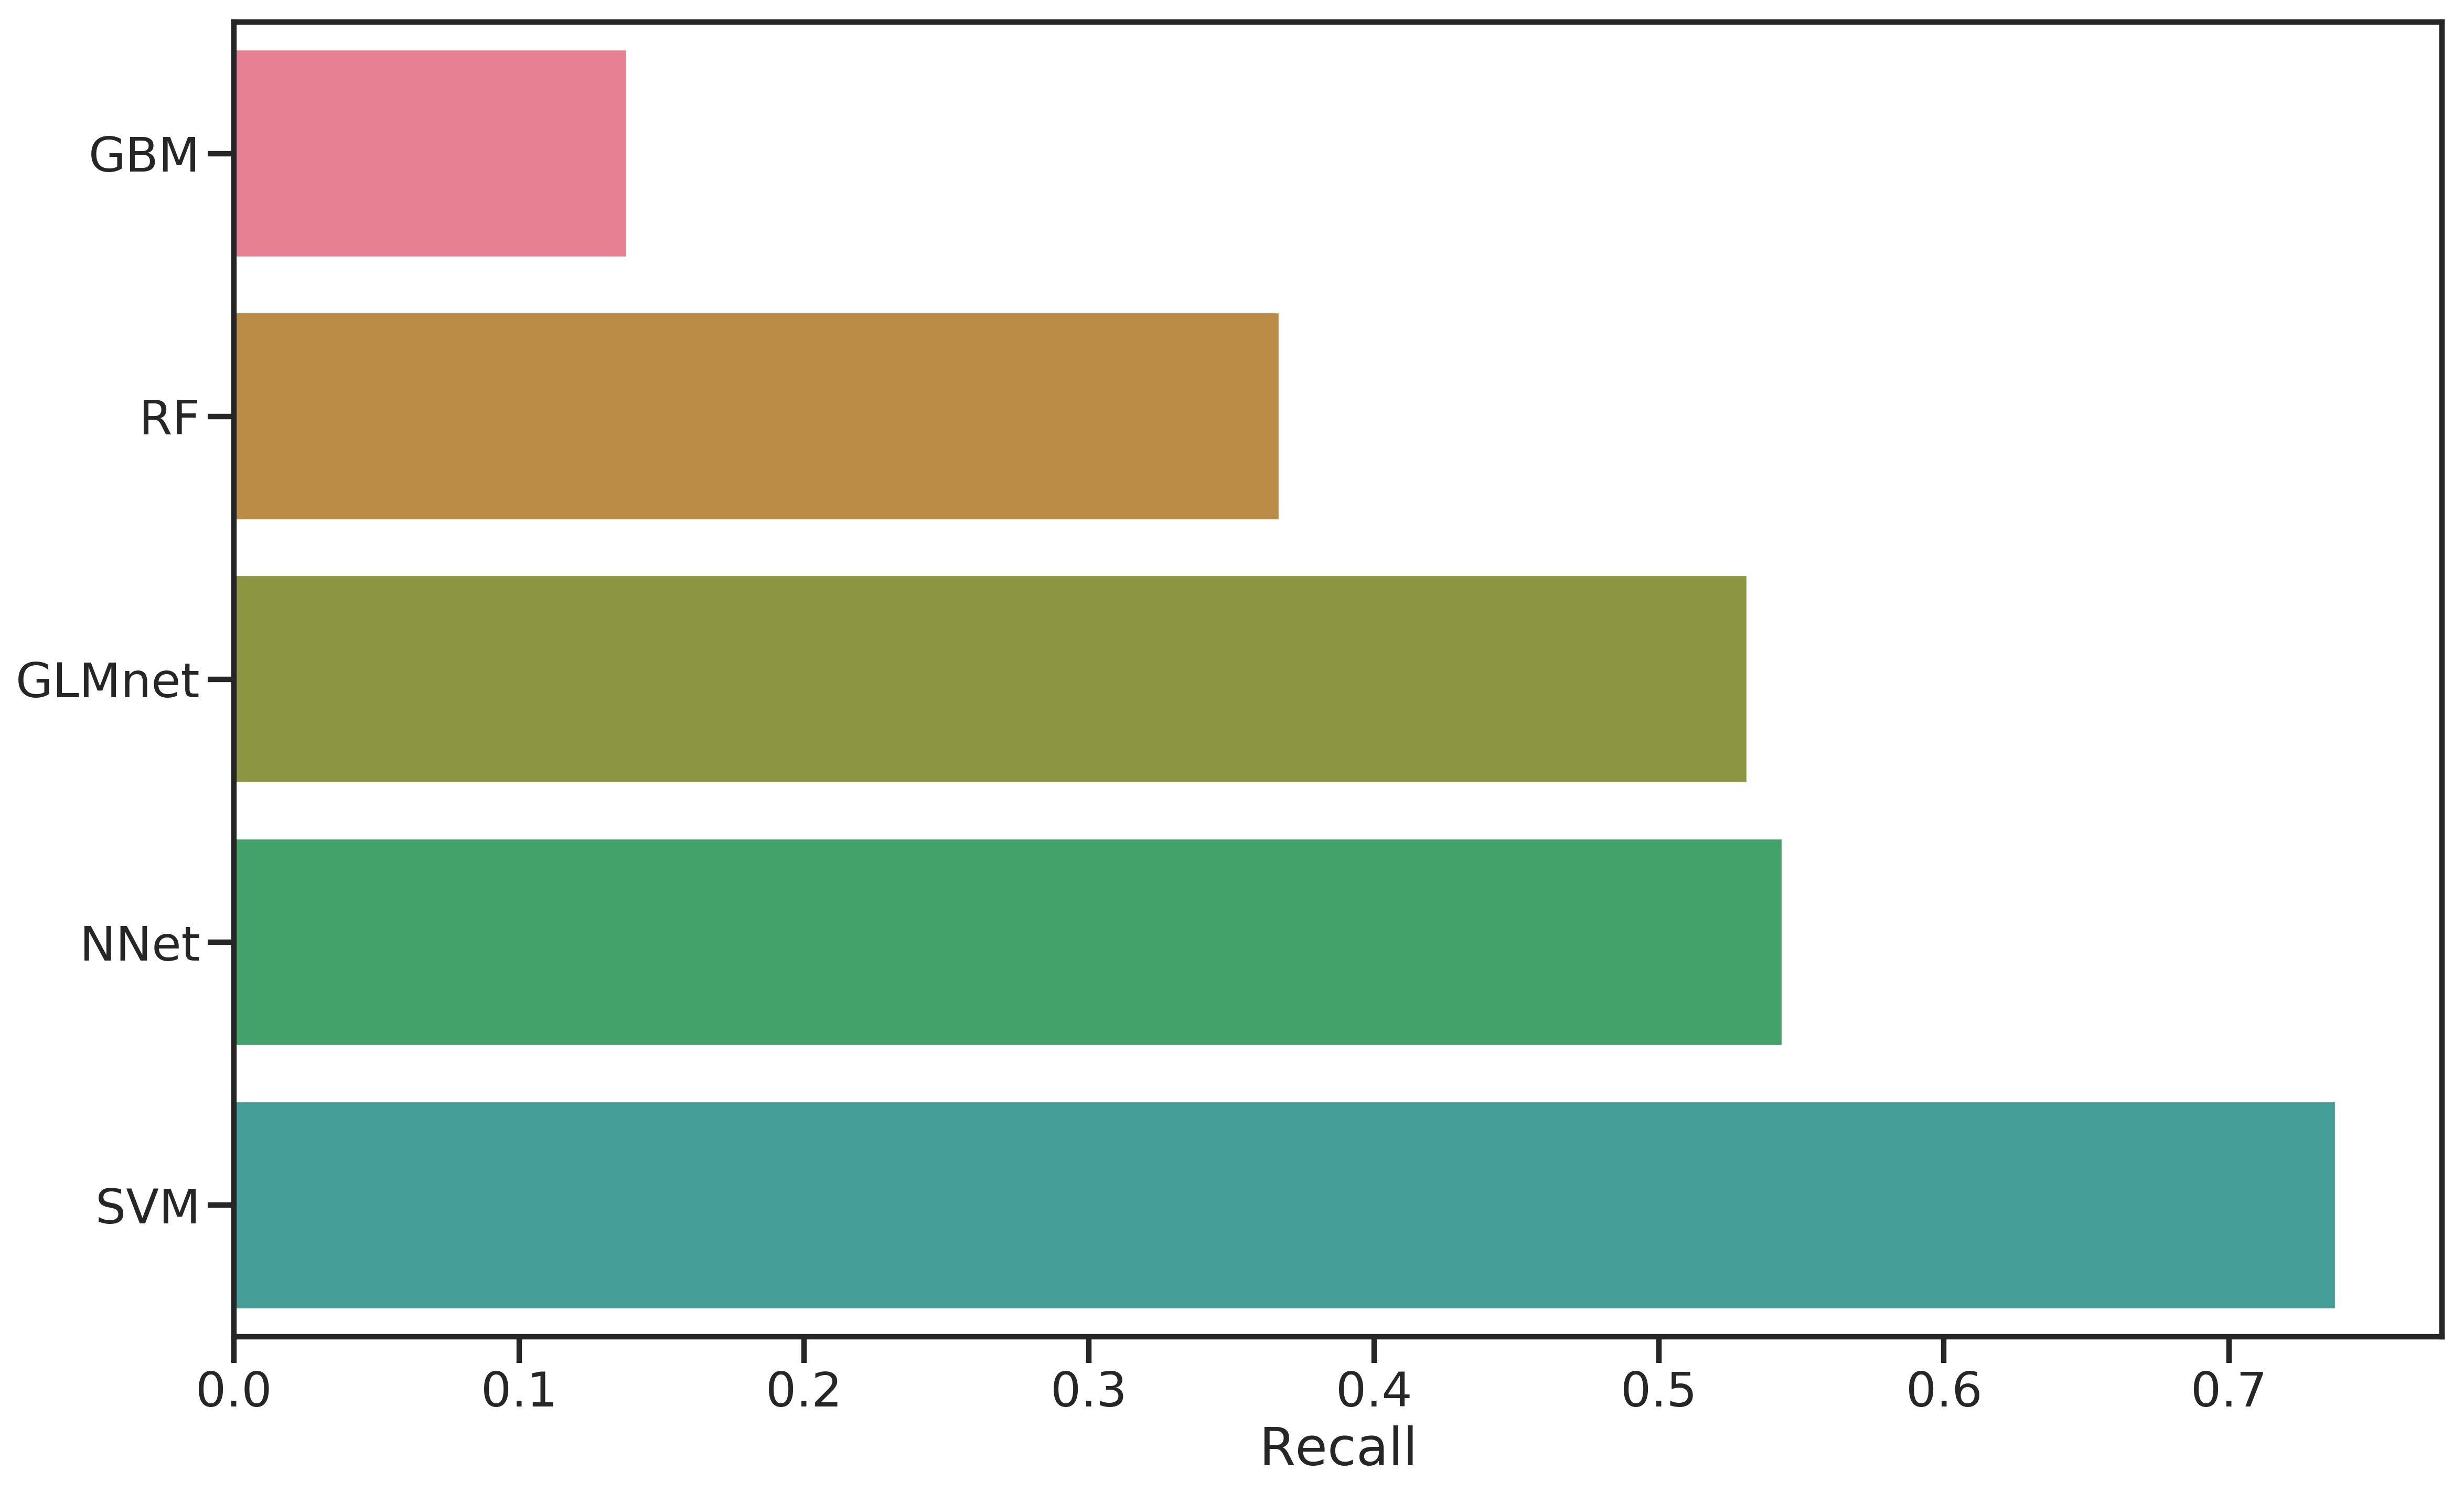

In [716]:
recall_scores.columns = ["Recall"]
def show_values_on_bars_h(axs):
    def _show_on_single_plot(ax):
        for p in ax.patches:
            _y = p.get_x() + p.get_width() / 2
            _x = p.get_y() + p.get_height() + 0.01
            value = '{:.1%}'.format(p.get_width())
            ax.text(_x, _y, value, ha="center")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

ax = sns.barplot(x="Recall", y=recall_scores.index, data=recall_scores.sort_values(by="Recall", ascending=True))
save_fig("recall-scores")

Confusion matrix for model GBM
Confusion matrix for model RF
Confusion matrix for model GLMnet
Confusion matrix for model NNet
Confusion matrix for model SVM


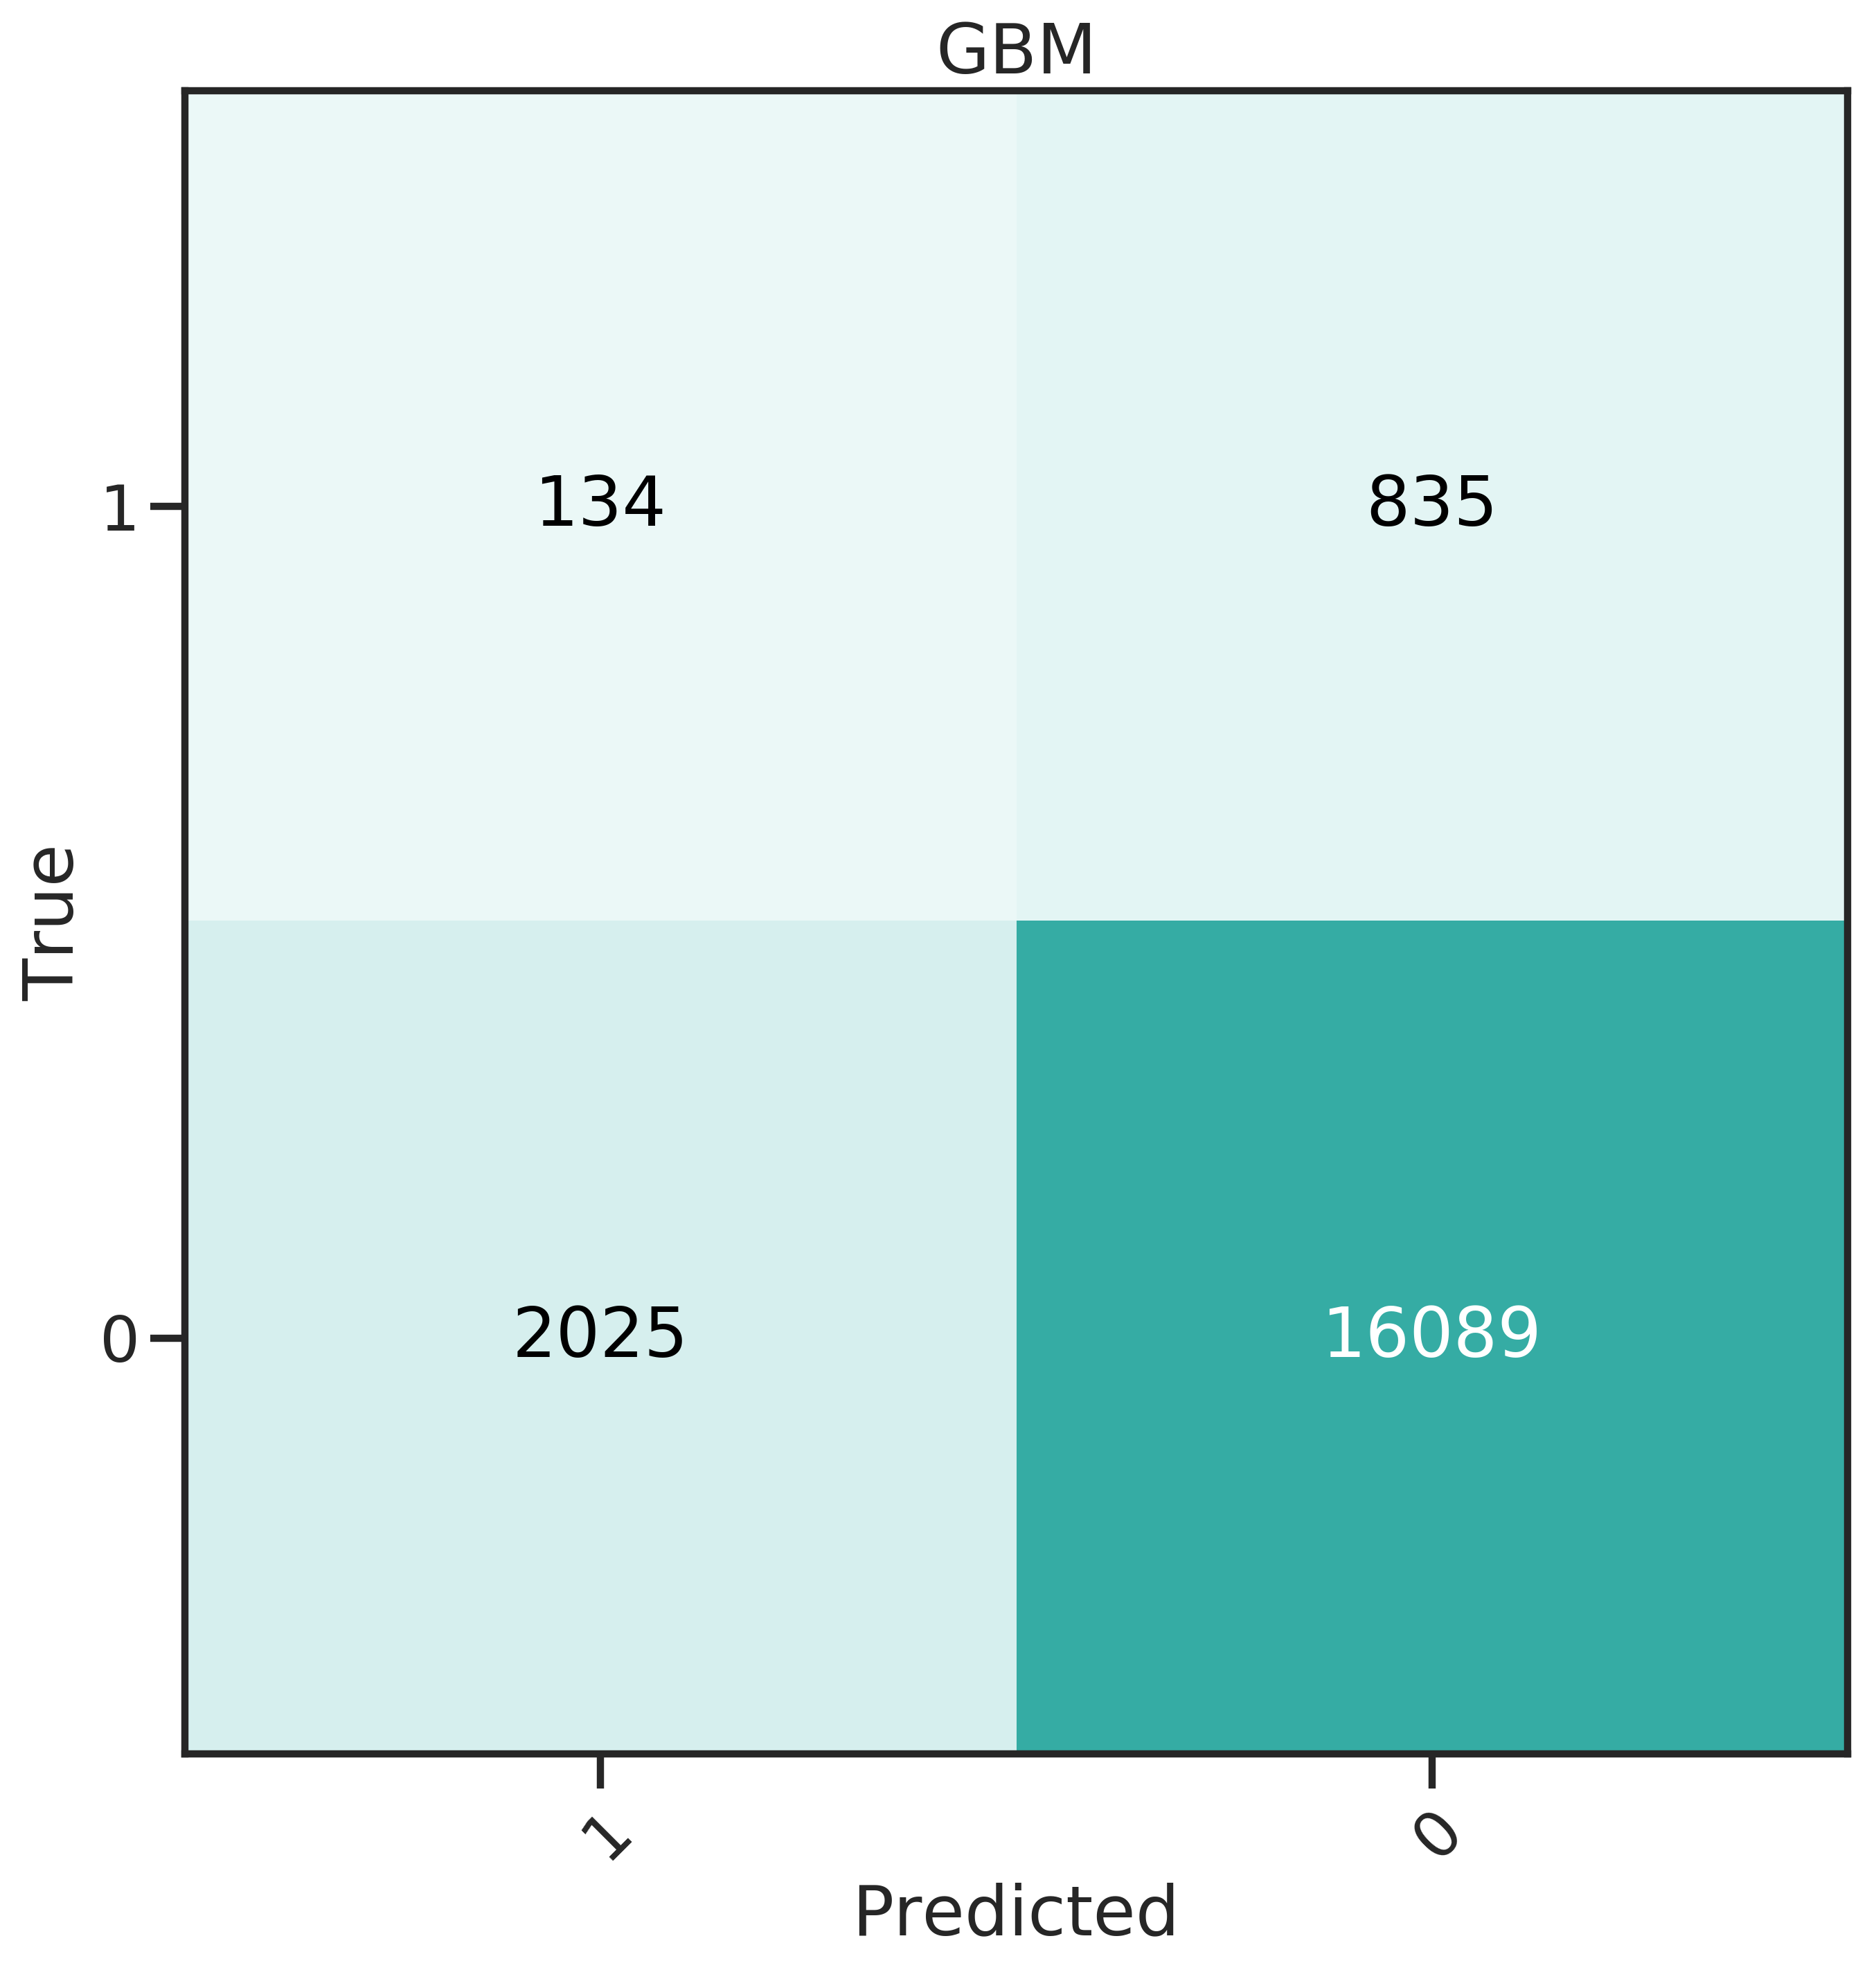

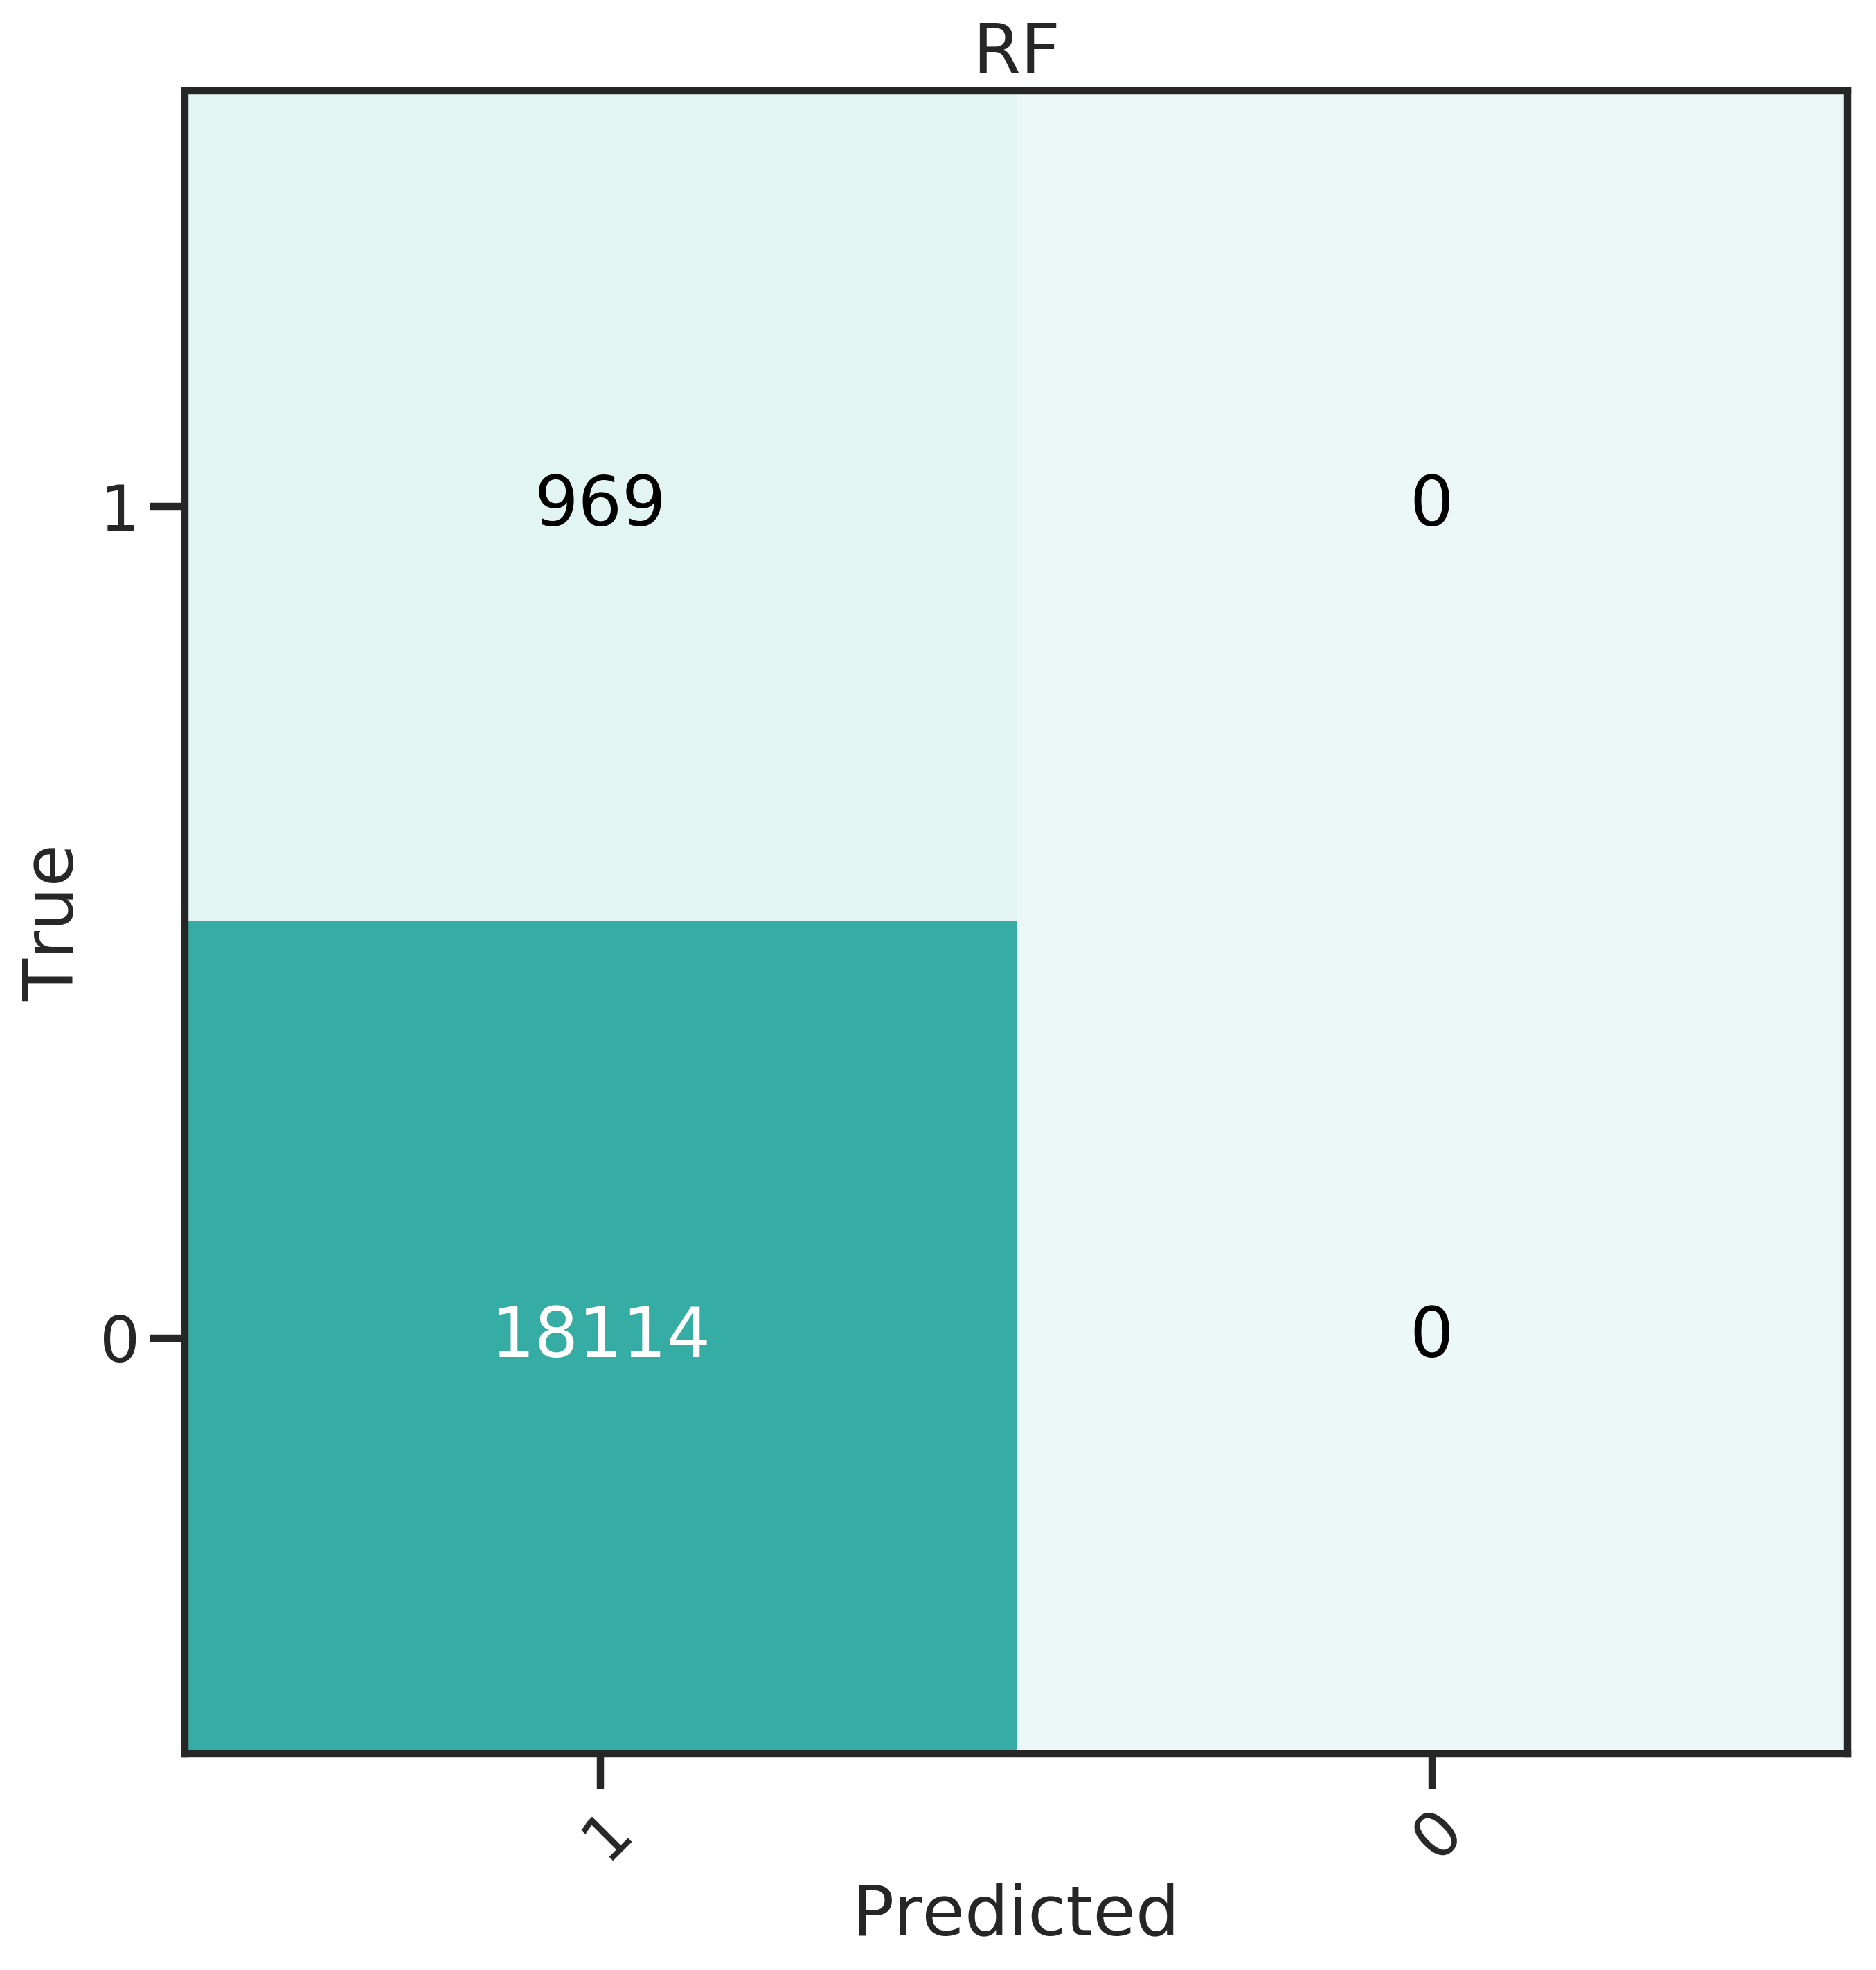

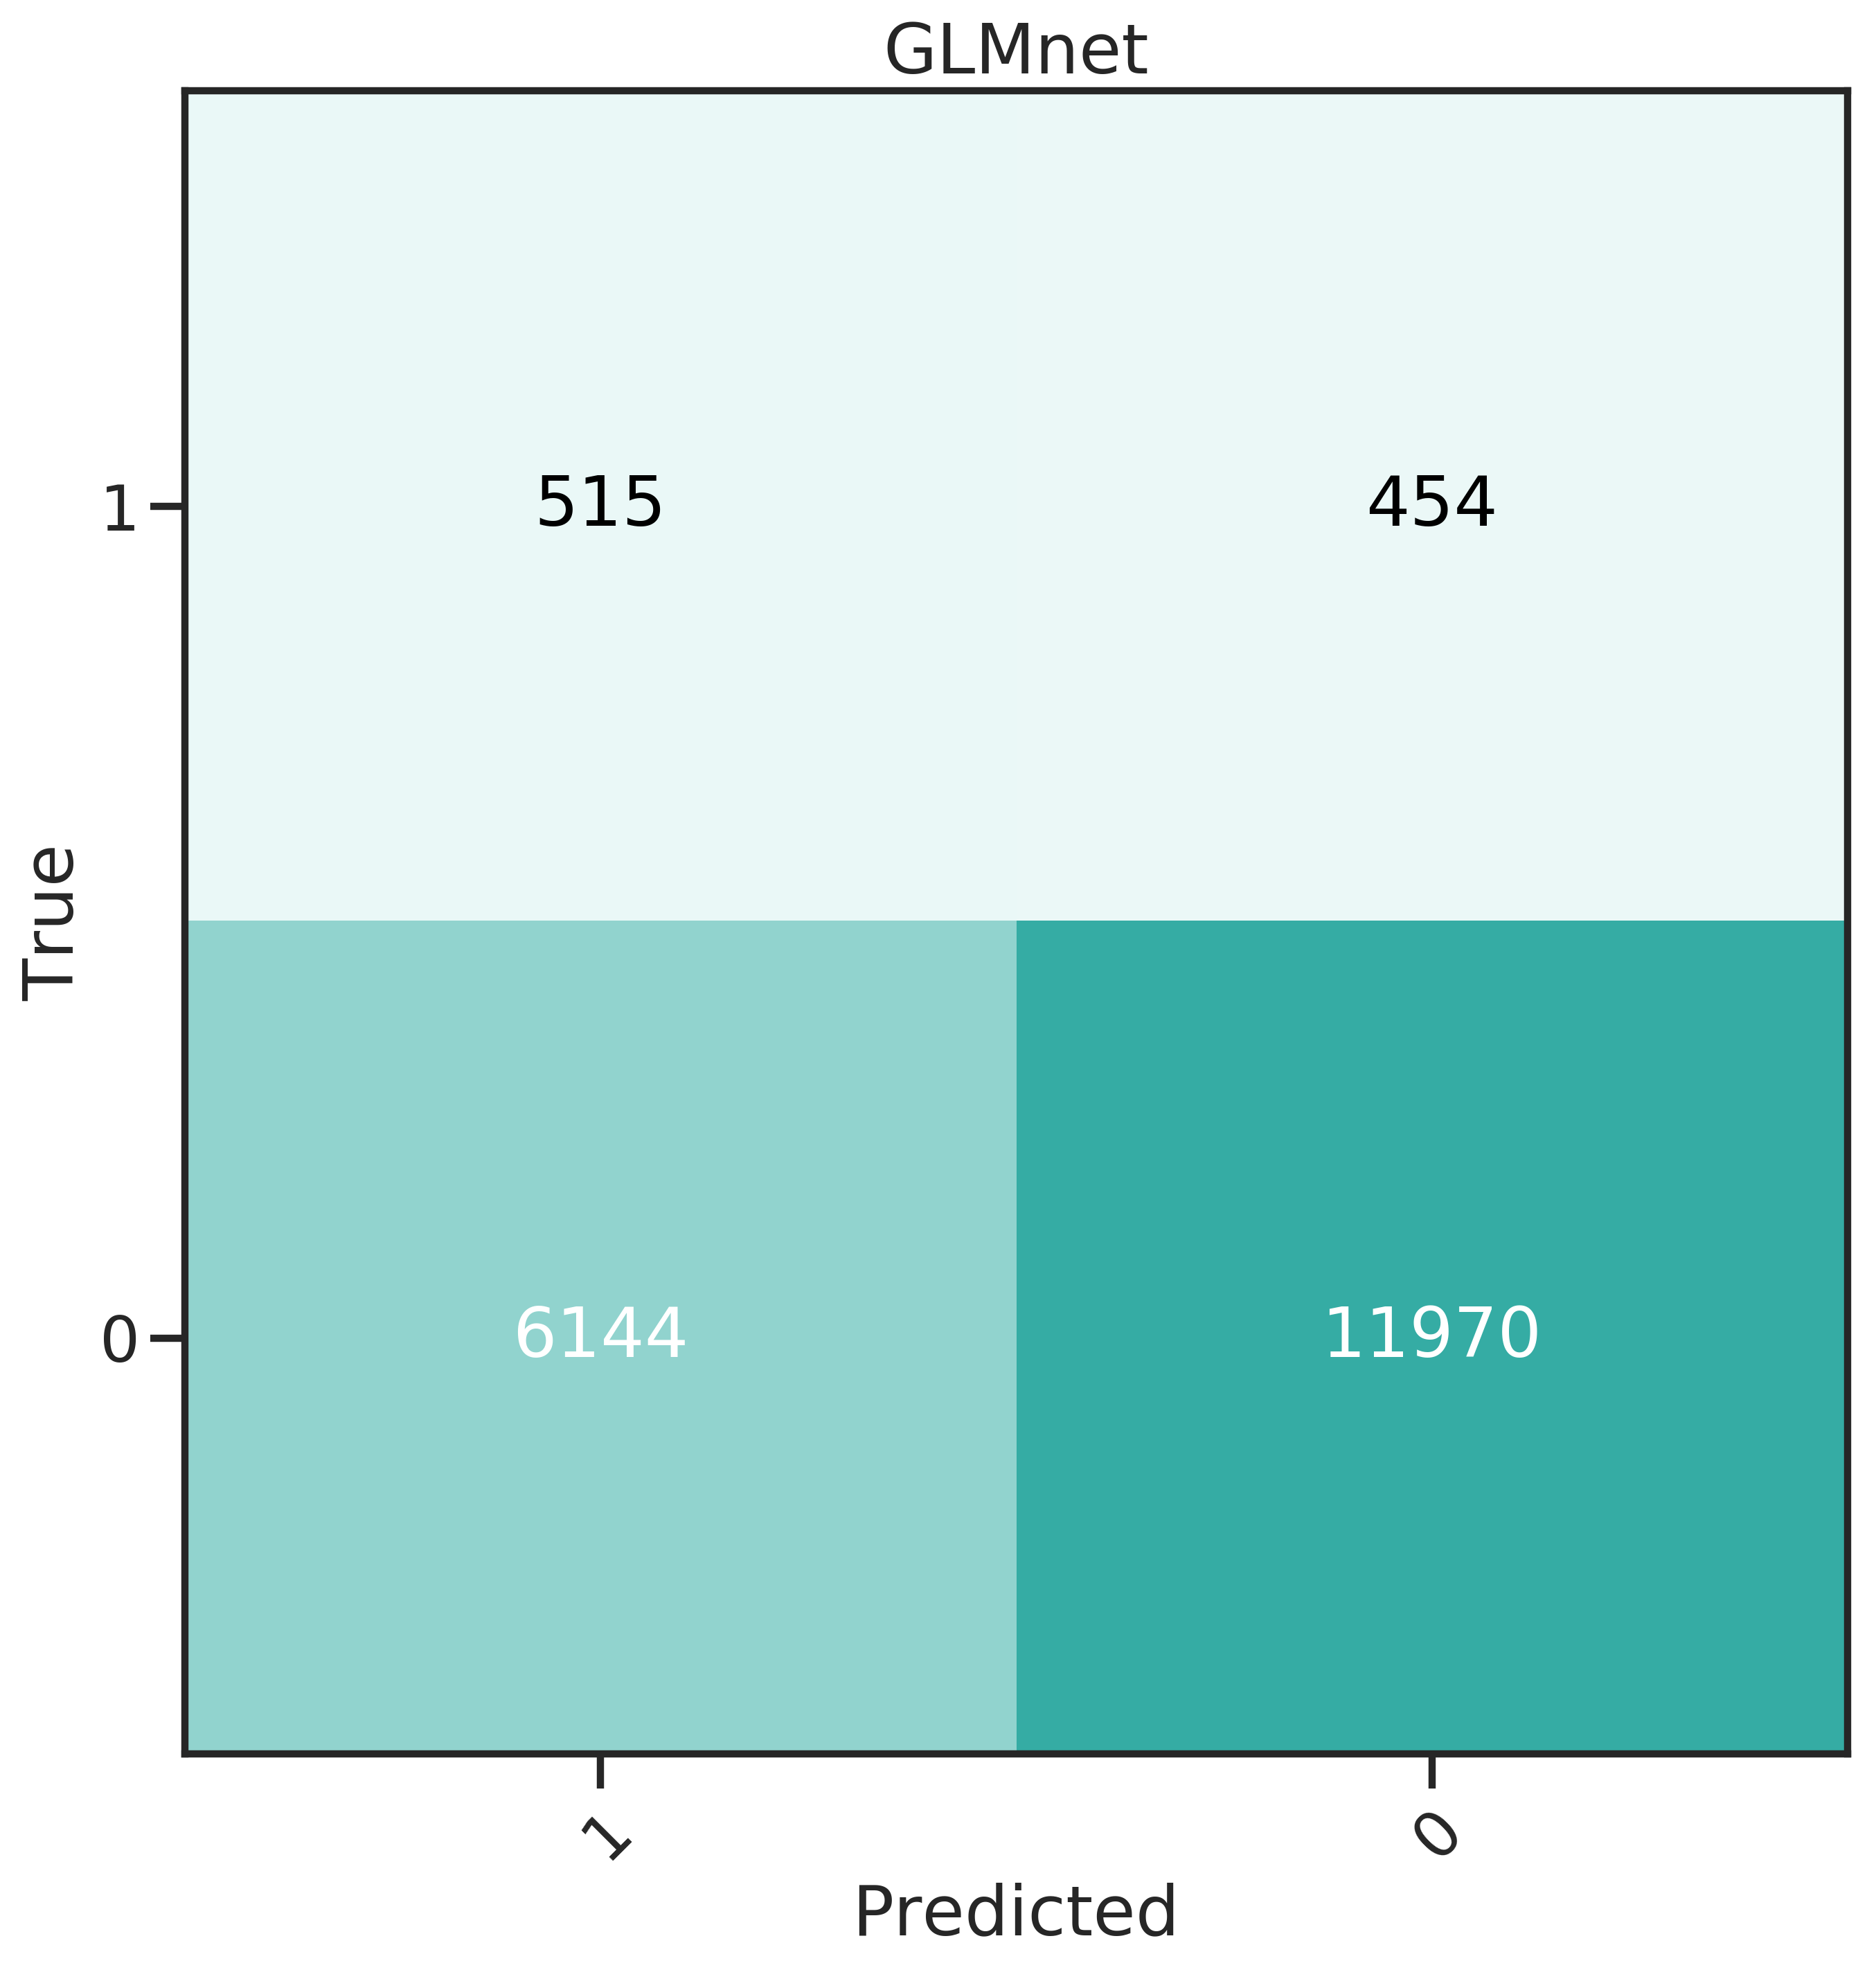

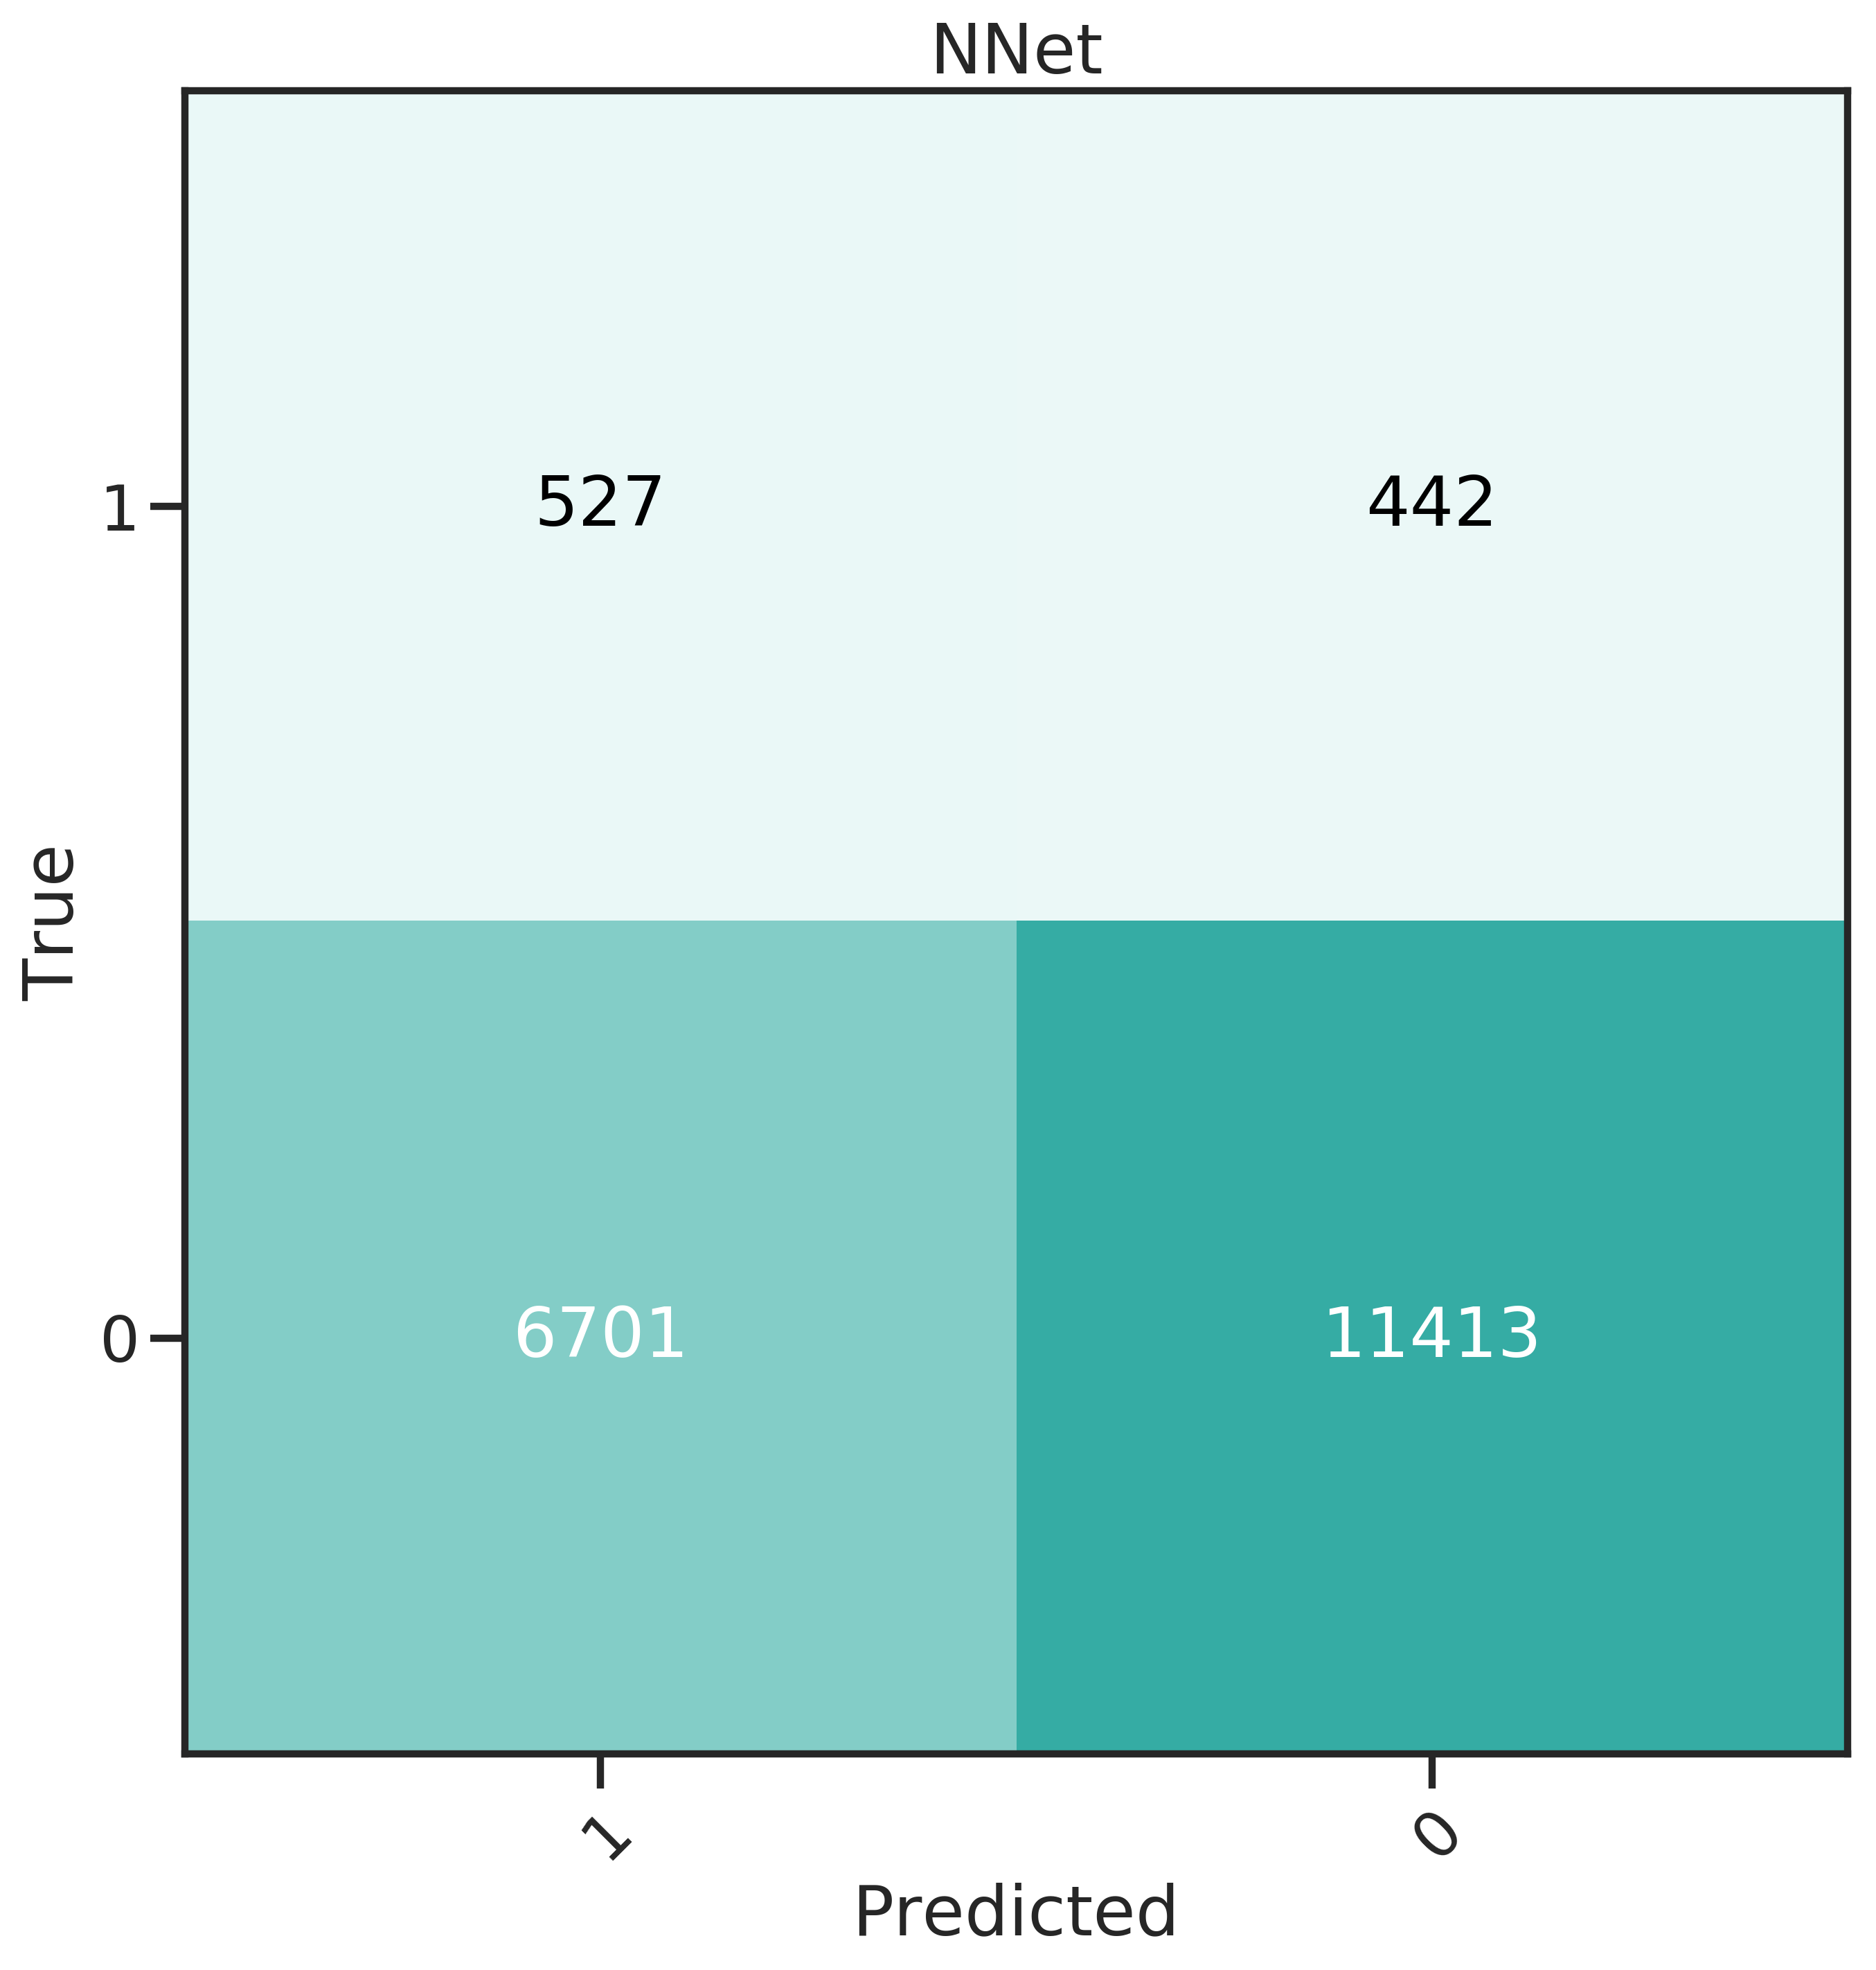

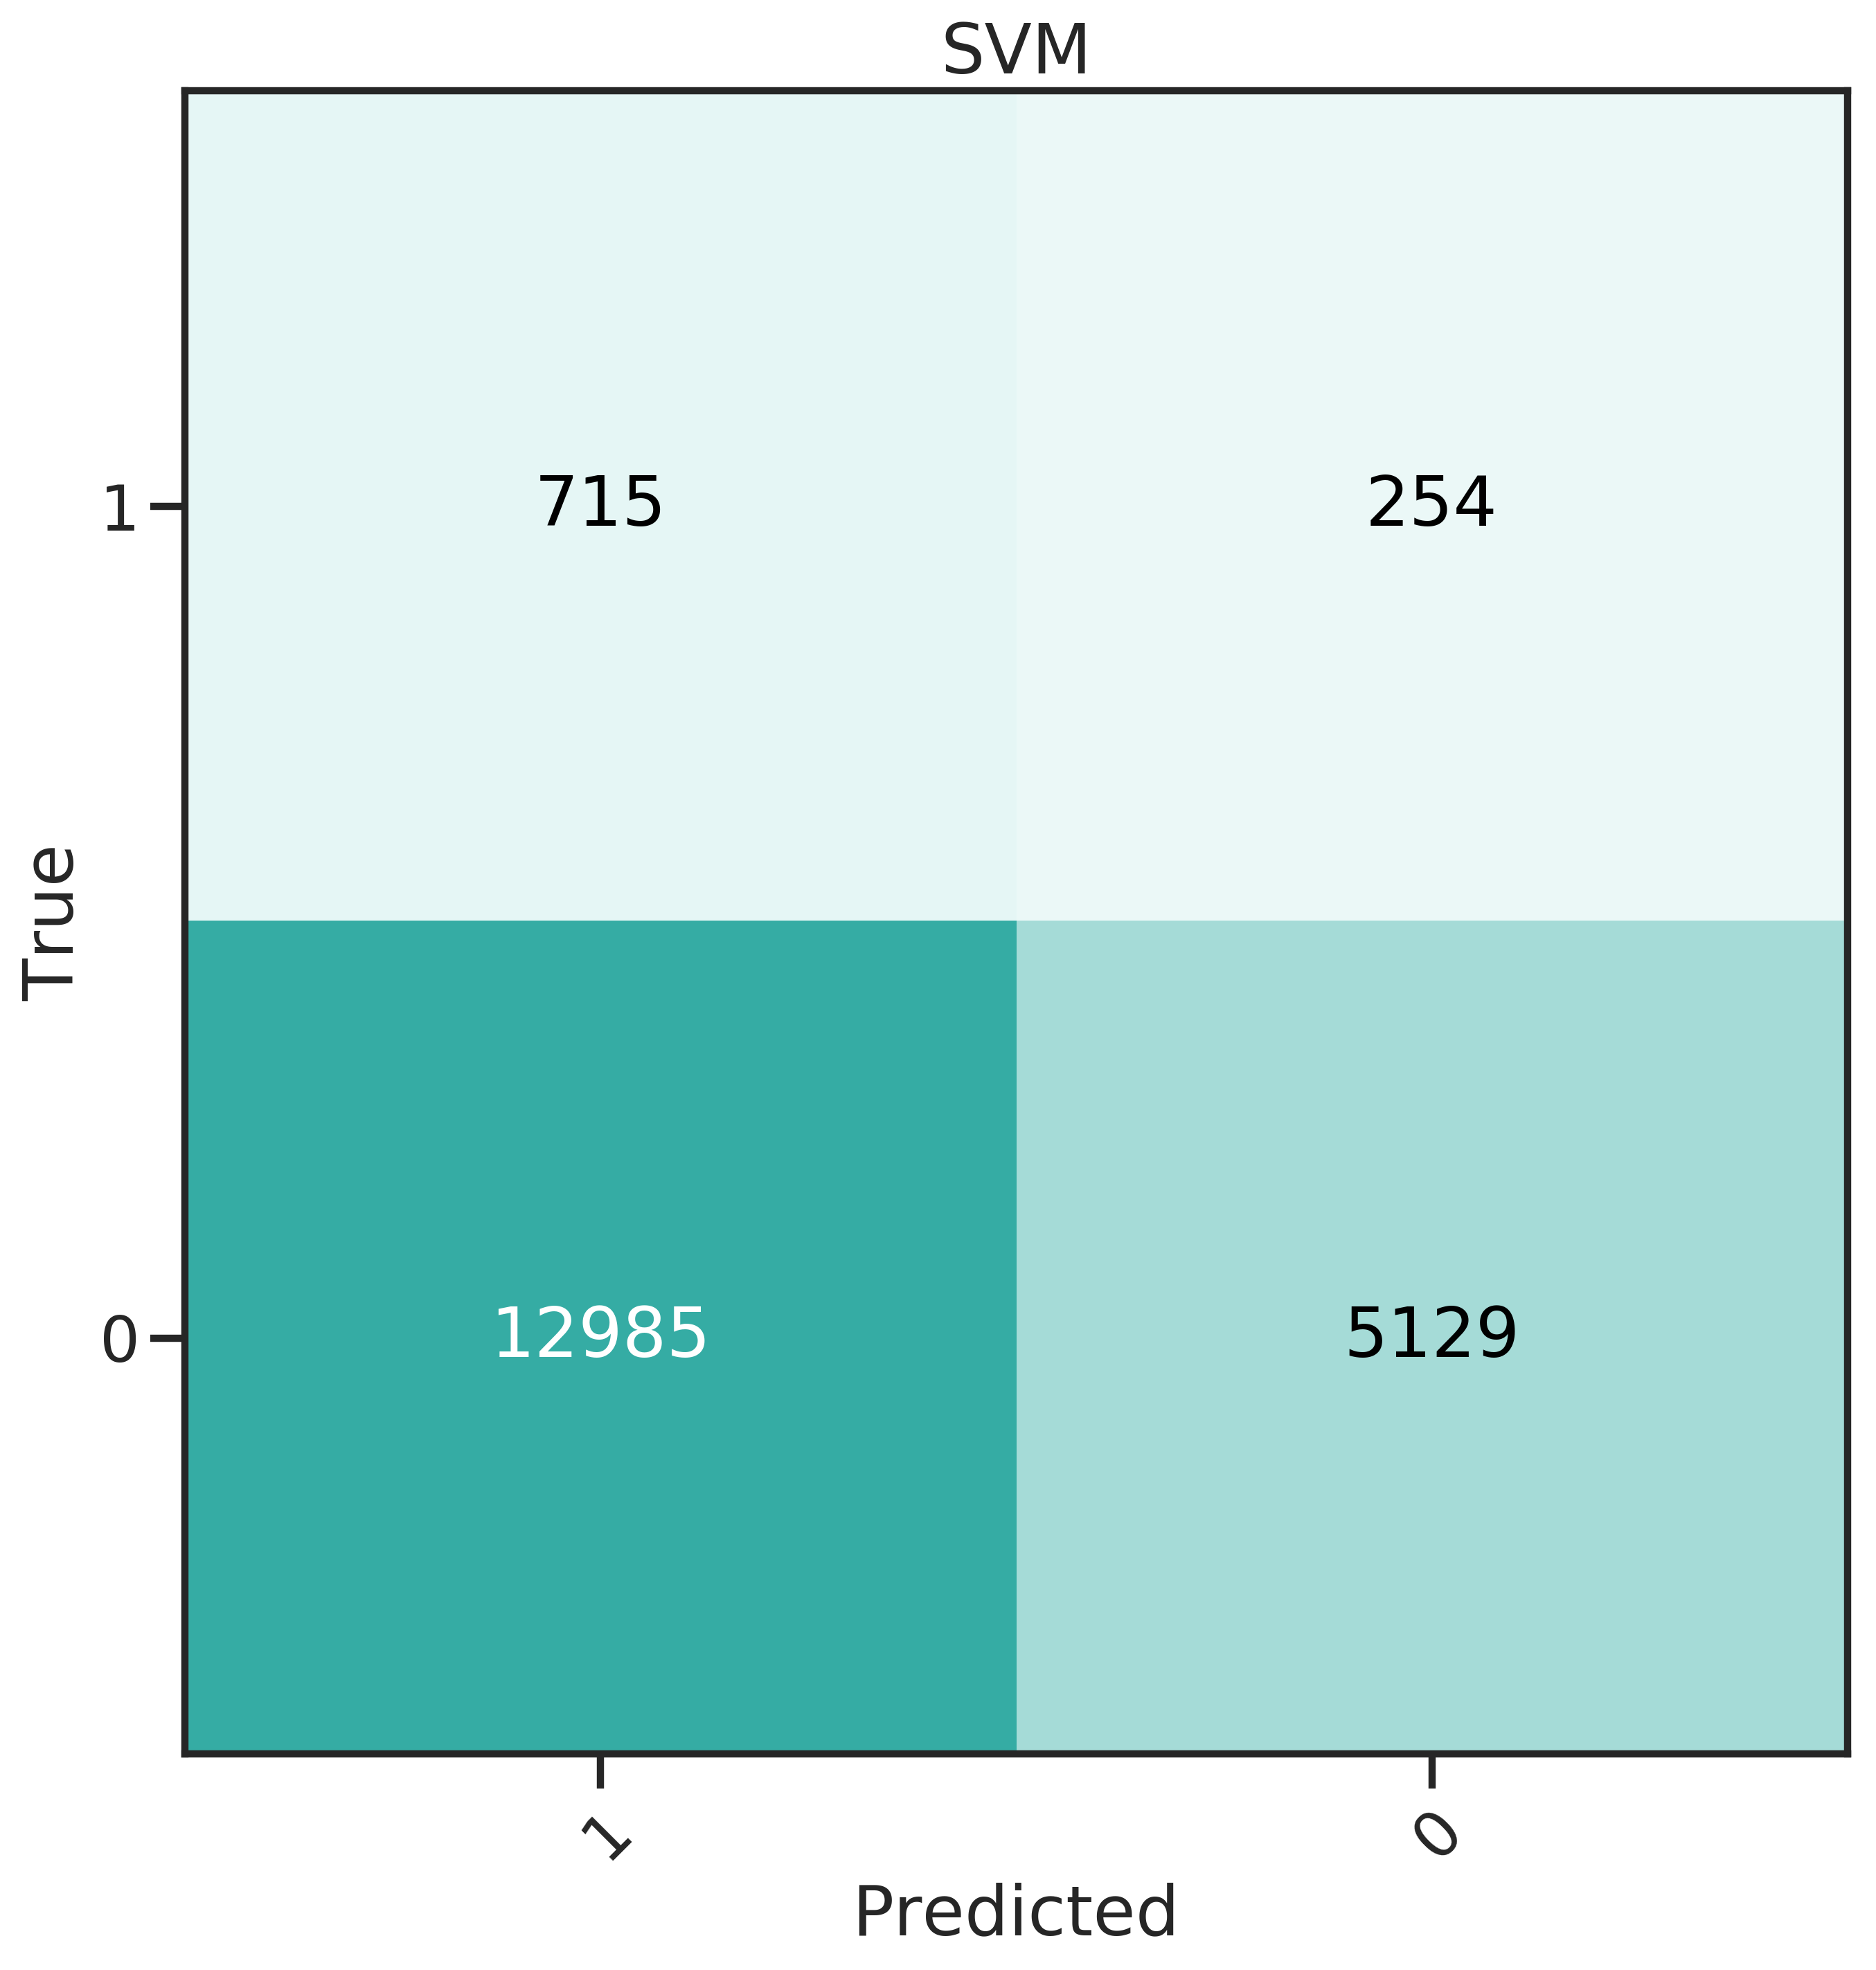

In [502]:
print_confusion_matrices("recall")

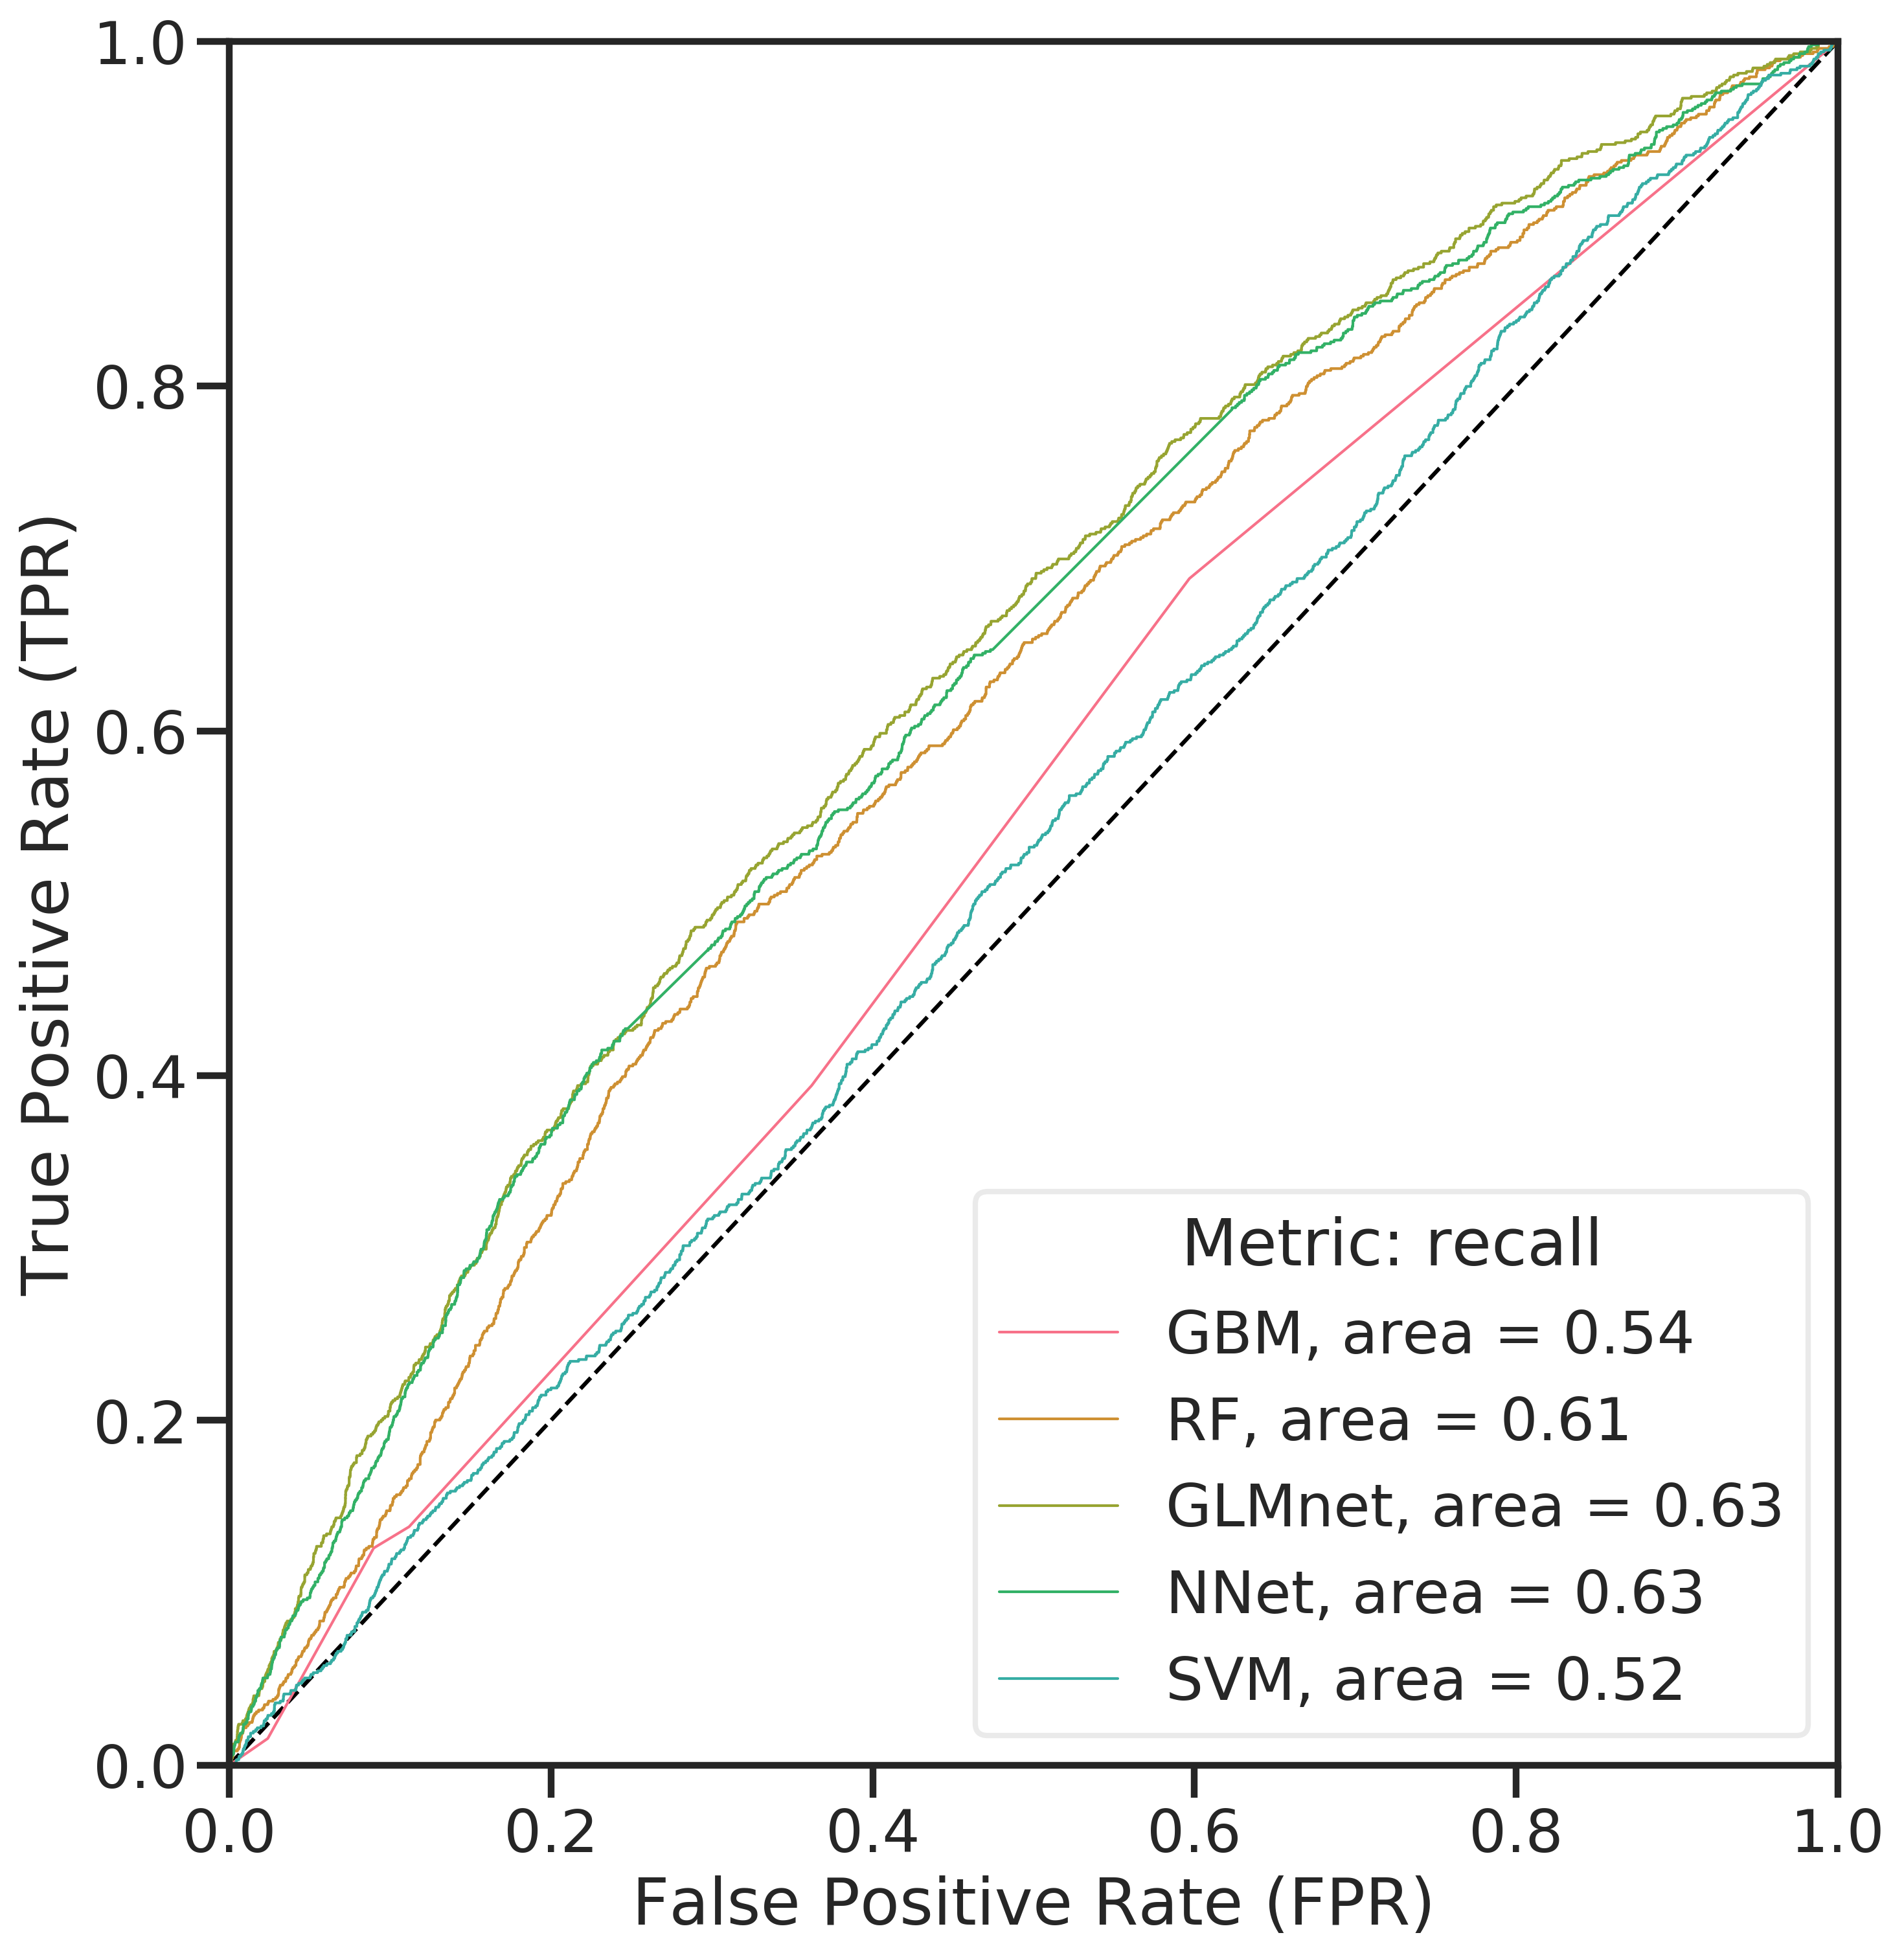

In [788]:
print_roc_auc_curve("recall")

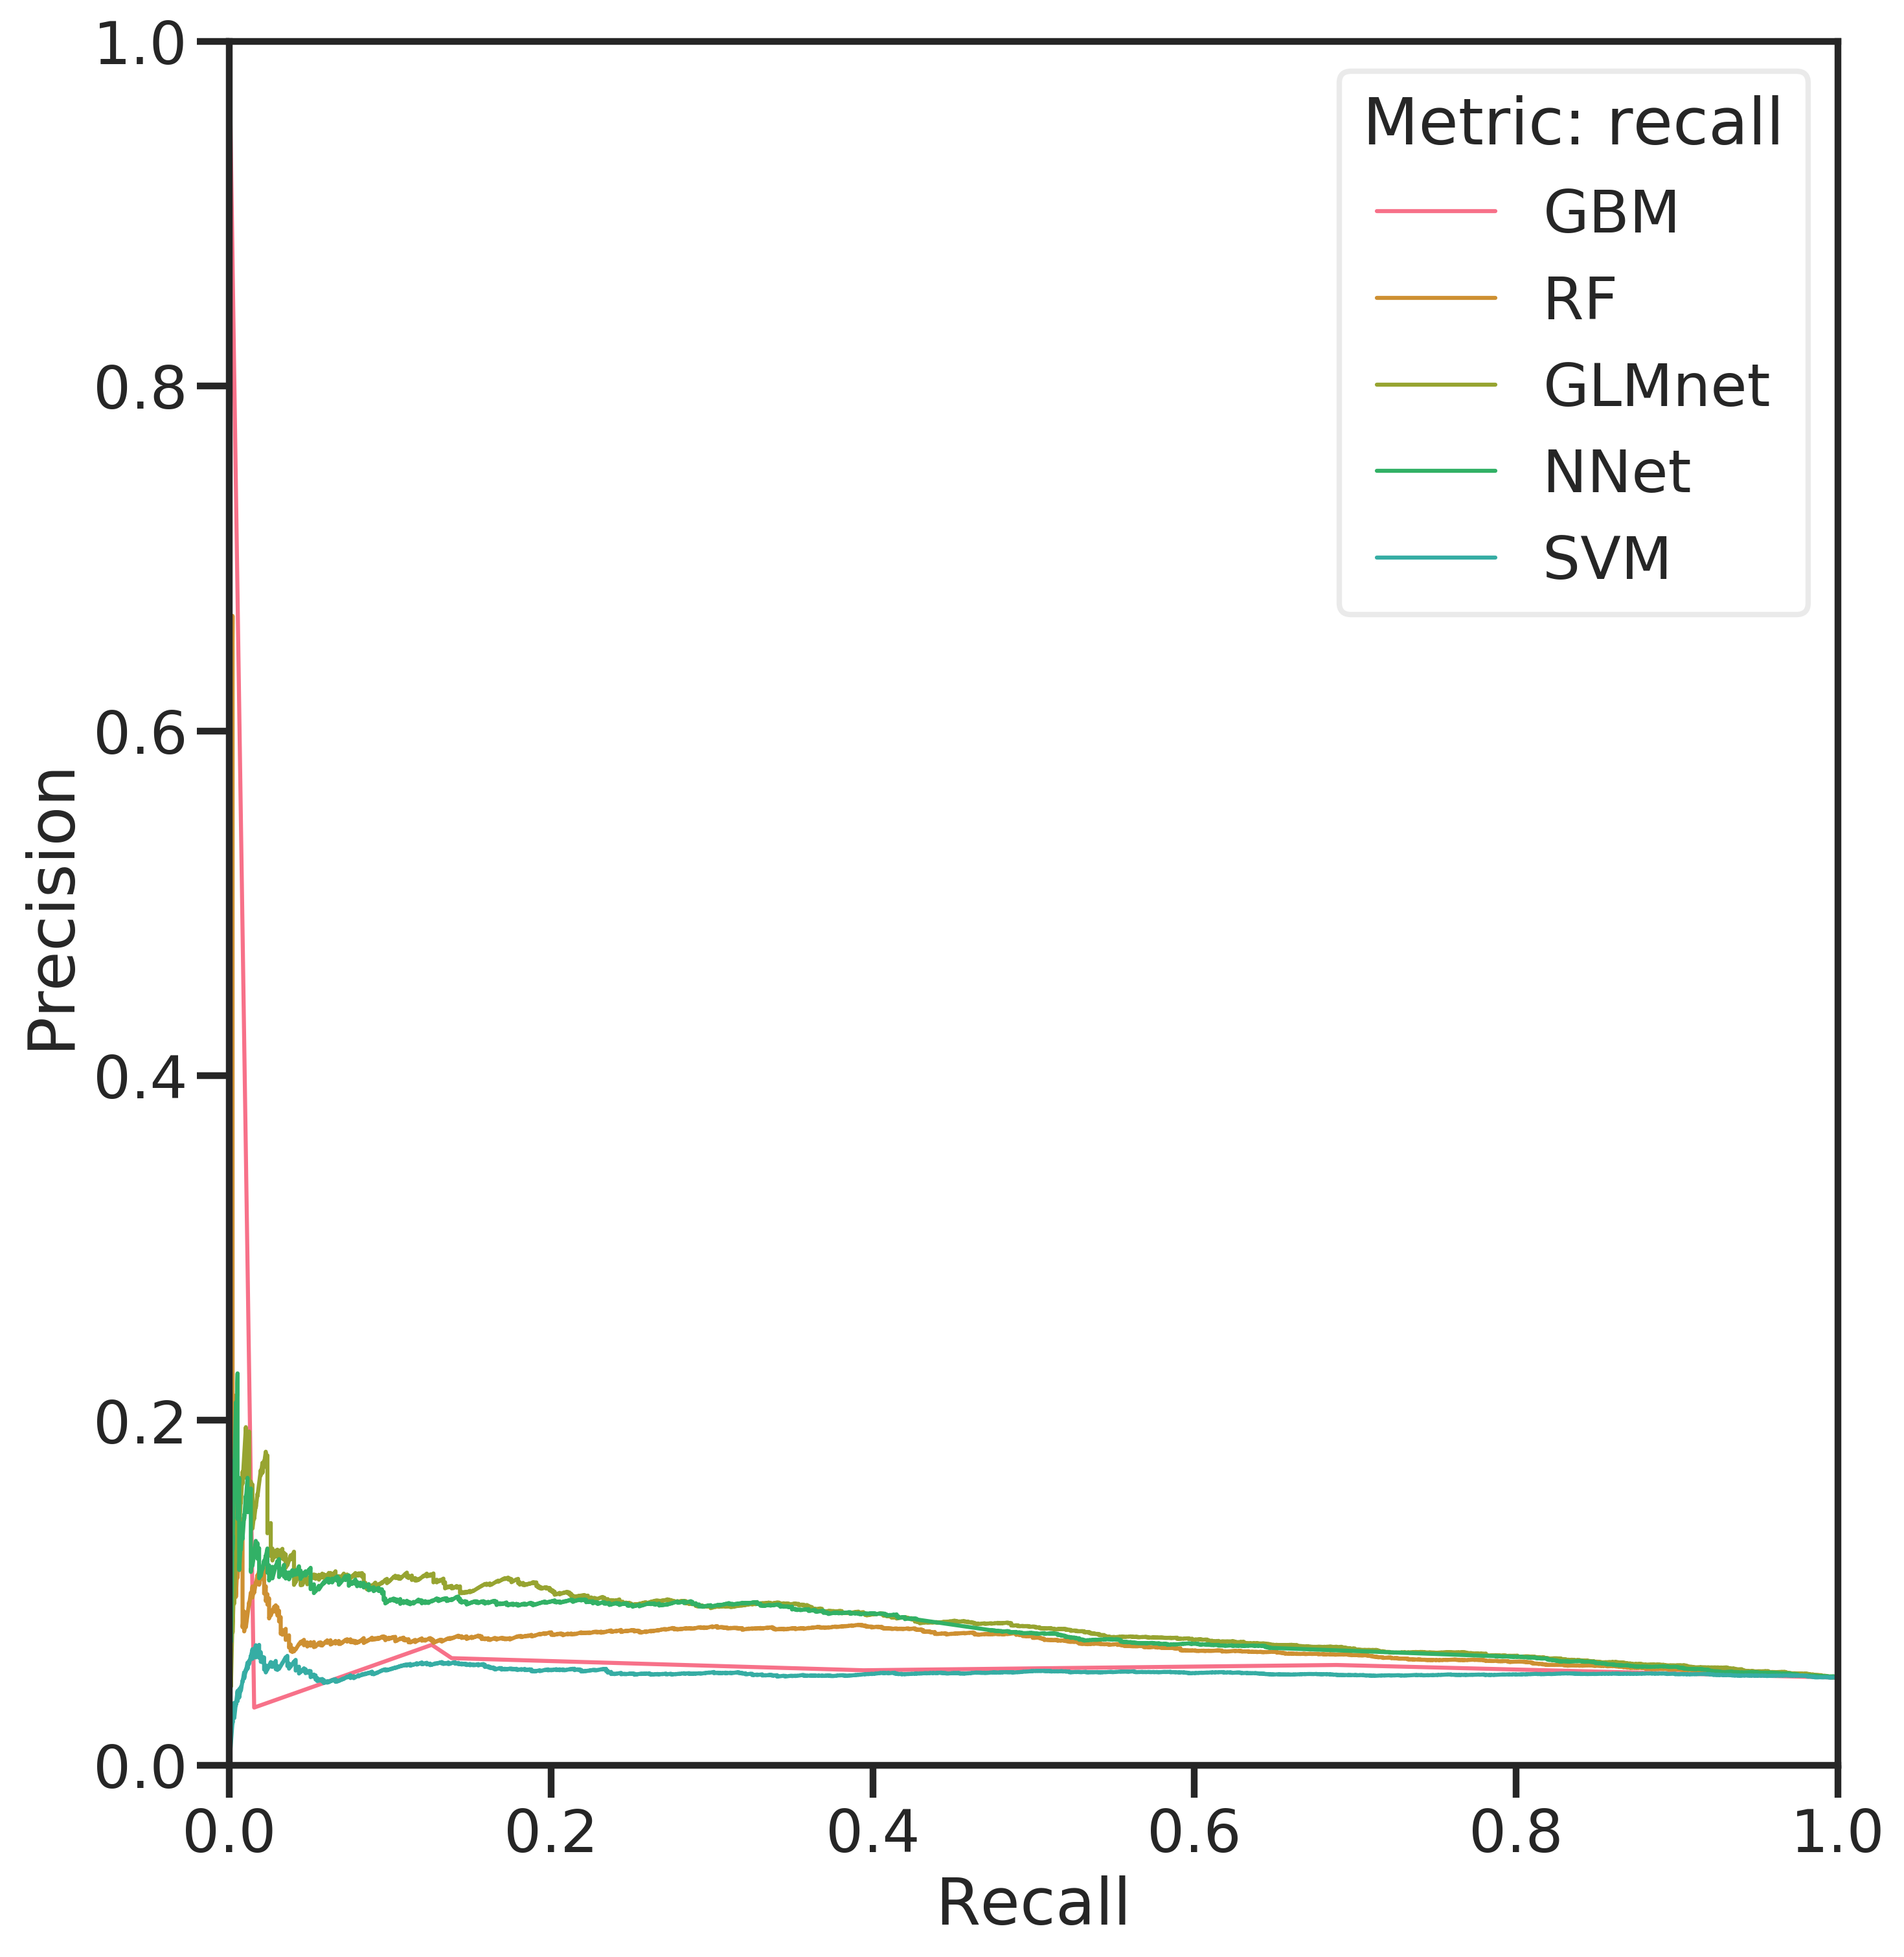

In [789]:
print_precision_recall_curve("recall")

In [862]:
clfs["NNet"]

{'best_estimator': Pipeline(memory=None,
      steps=[('scaler', PowerTransformer(copy=True, method='yeo-johnson', standardize=True)), ('sampler', BorderlineSMOTE(k_neighbors=5, kind='borderline-1', m_neighbors=10, n_jobs=1,
         random_state=42, sampling_strategy=0.9507610378684456)), ('classifier', MLPClassifier(activation='relu', alpha=0.5...=True, solver='adam', tol=0.0001,
        validation_fraction=0.1, verbose=False, warm_start=False))]),
 'best_score': 0.13082304508831785,
 'best_params': {'classifier__alpha': 0.5,
  'classifier__hidden_layer_sizes': (28, 28),
  'classifier__learning_rate_init': 0.07925436438616416,
  'sampler__sampling_strategy': 0.9507610378684456},
 'cv_results':    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
 0      74.163042      6.649175         0.425421        0.126196   
 1      78.847192      7.775132         0.325821        0.125901   
 2      80.535002      9.309415         0.381549        0.119747   
 3      80.491182      9

In [738]:
importance = clfs["RF"]["best_estimator"].named_steps["classifier"].feature_importances_
importance = pd.DataFrame(importance, index=X_train.columns, 
                          columns=["Importance"])
feature_names = X_train.columns.values.tolist()
importances = []
for tree in clfs["RF"]["best_estimator"].named_steps["classifier"].estimators_:
    for k,f in enumerate(tree.feature_importances_):
        name = feature_names[k]
        importances.append({"feature": name, "importance": f})
        
importances = pd.DataFrame(importances)

In [755]:
importances_grouped = importances.groupby("feature").mean().reset_index().sort_values("importance", ascending=False)

In [760]:
ordering = list(importances_grouped.feature)

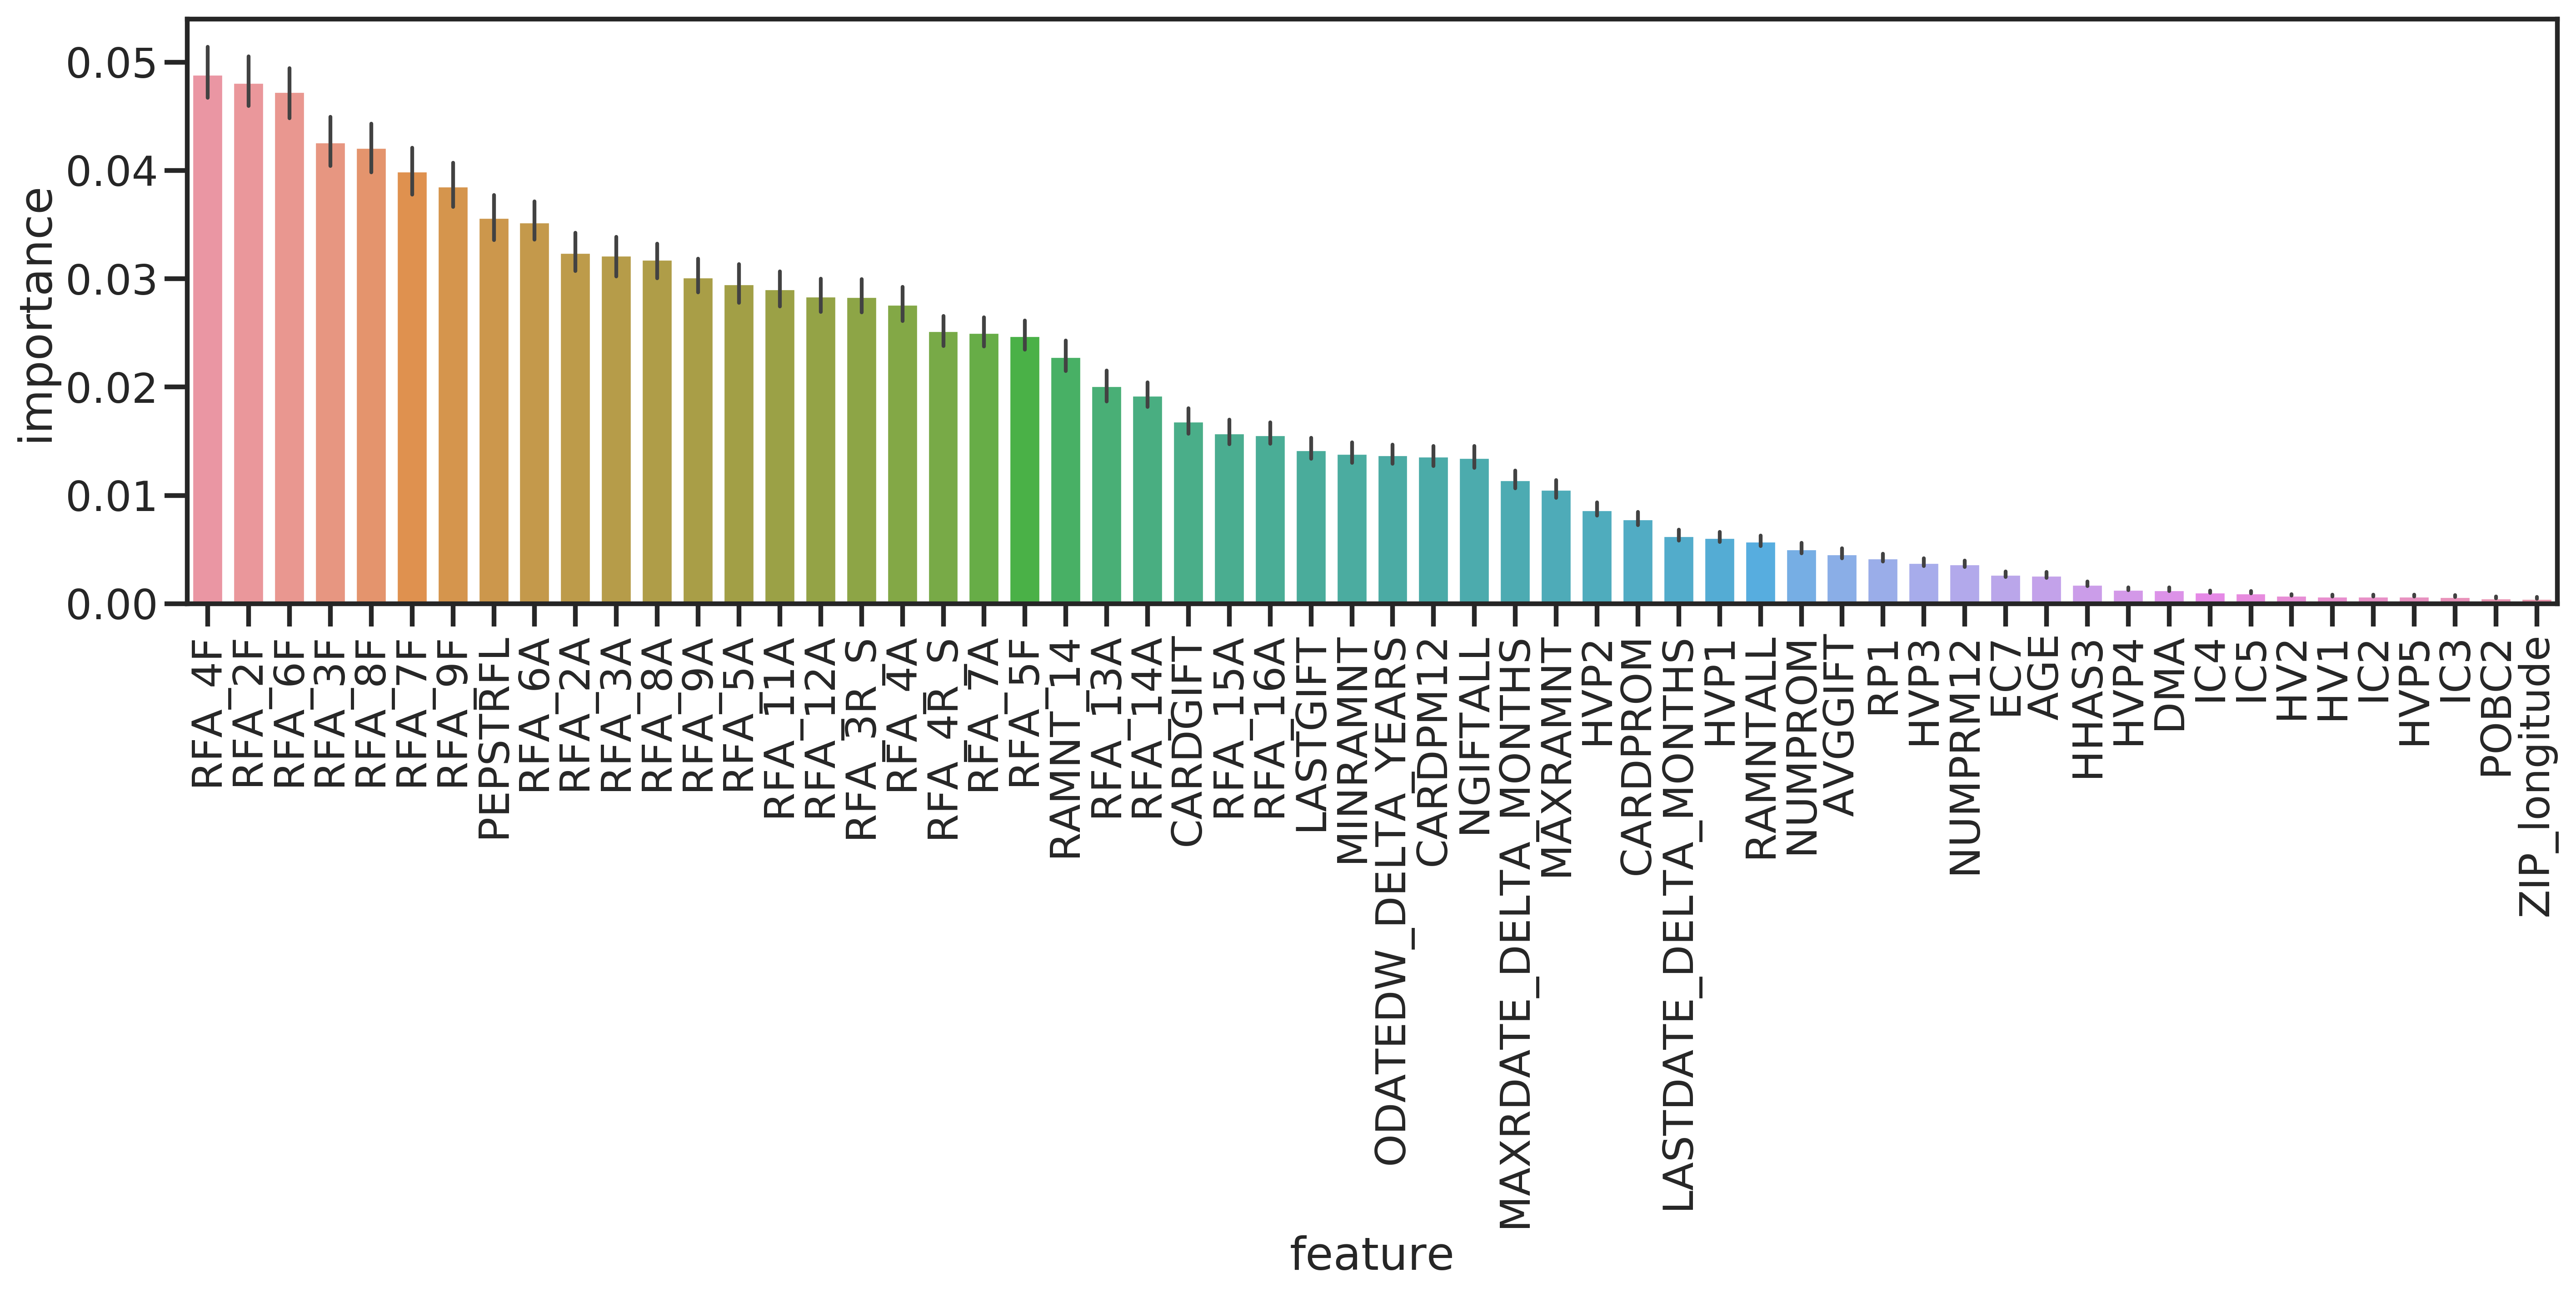

In [773]:
plt.rcParams['figure.figsize'] = (1.618*12, 10)
ax = sns.barplot(x="feature", y="importance", order = ordering, ci=50, errwidth=2.0, data=importances)
for item in ax.get_xticklabels(): item.set_rotation(90)
save_fig("feature-importance-rf-classification")

In [ ]:
plt.rcParams['figure.figsize'] = (1.618*10, 10)

In [ ]:
sns.barplot(x=importance.index,y=importance.Importance, )

In [527]:
print_cv_results("f1")

Model GBM
                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.89      0.17      0.92      0.39      0.16     18114
          1       0.08      0.17      0.89      0.11      0.39      0.14       969

avg / total       0.91      0.86      0.20      0.88      0.39      0.16     19083

Mean scores
   mean_test_auc  mean_test_recall  mean_test_f1
9          0.537             0.175         0.114
2          0.536             0.170         0.113
0          0.534             0.164         0.111
8          0.520             0.085         0.088
3          0.519             0.083         0.085
6          0.519             0.080         0.085
1          0.514             0.057         0.070
5          0.509             0.036         0.052
7          0.501             0.004         0.007
4          0.500             0.000         0.001
Best params
{'classifier__learning_rate': 0.013, 'classifier__min_weight_fraction_leaf': 0.3671581842219

Confusion matrix for model GBM
Confusion matrix for model RF
Confusion matrix for model GLMnet
Confusion matrix for model NNet
Confusion matrix for model SVM


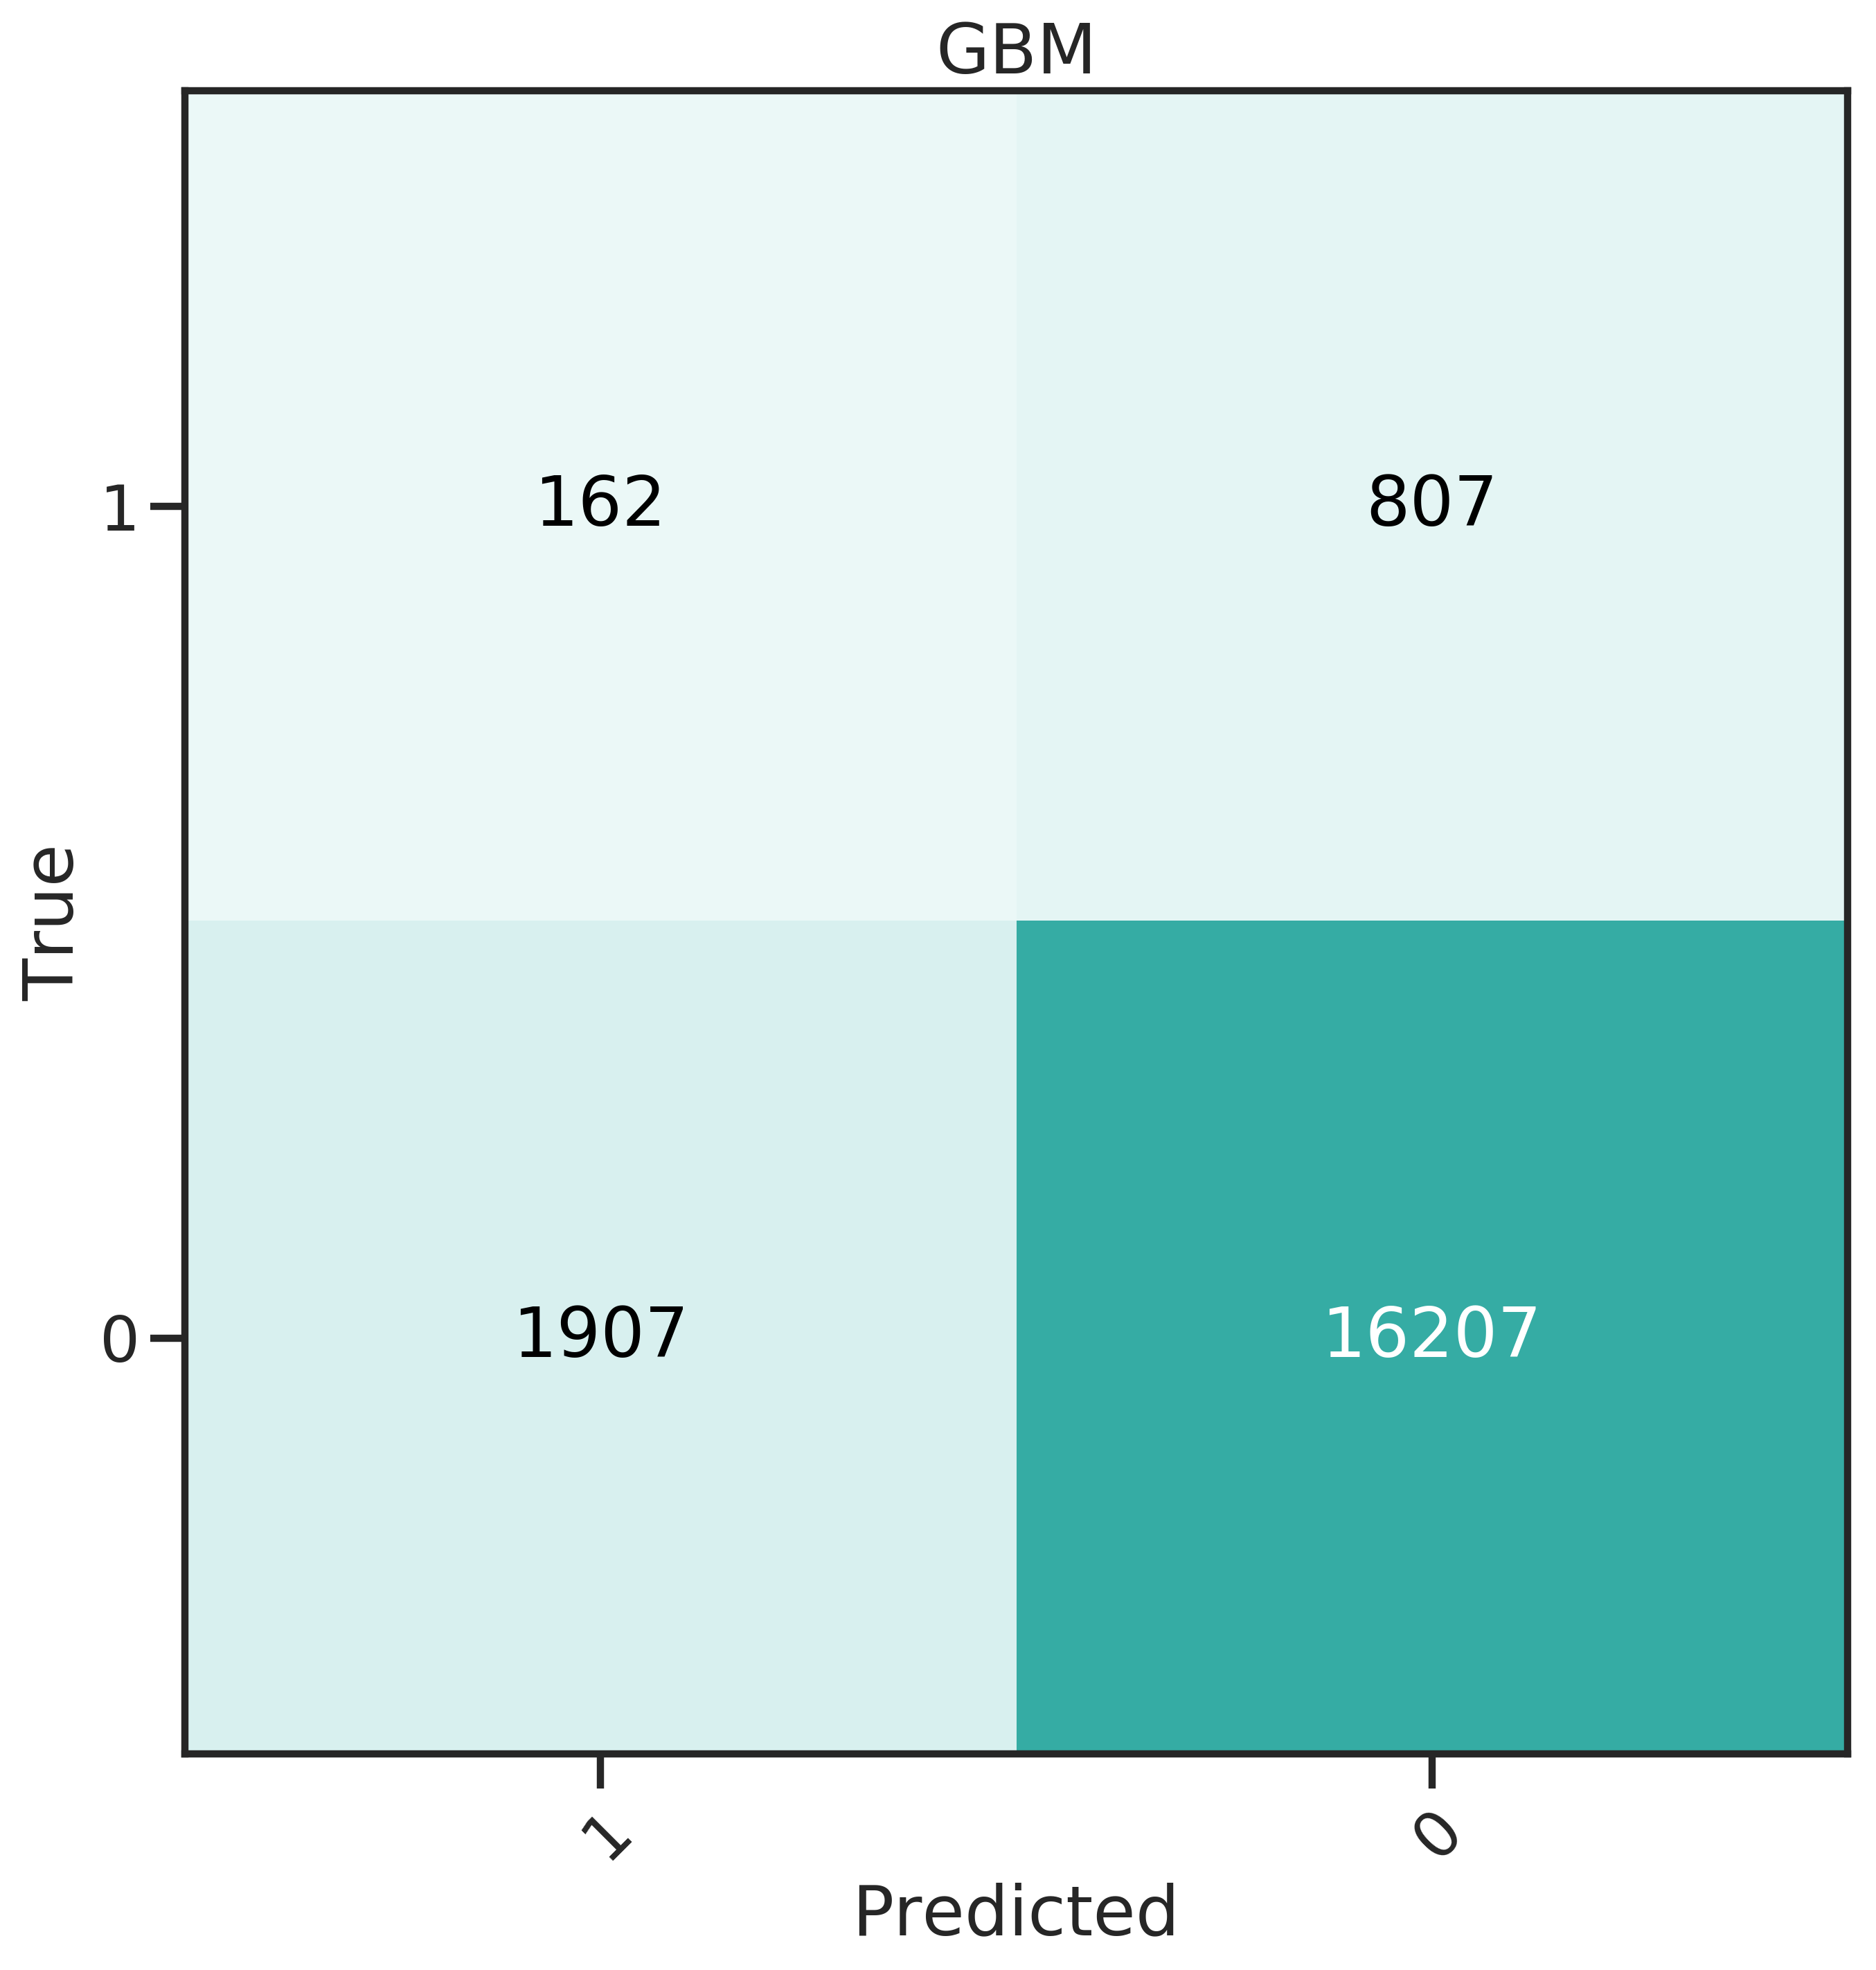

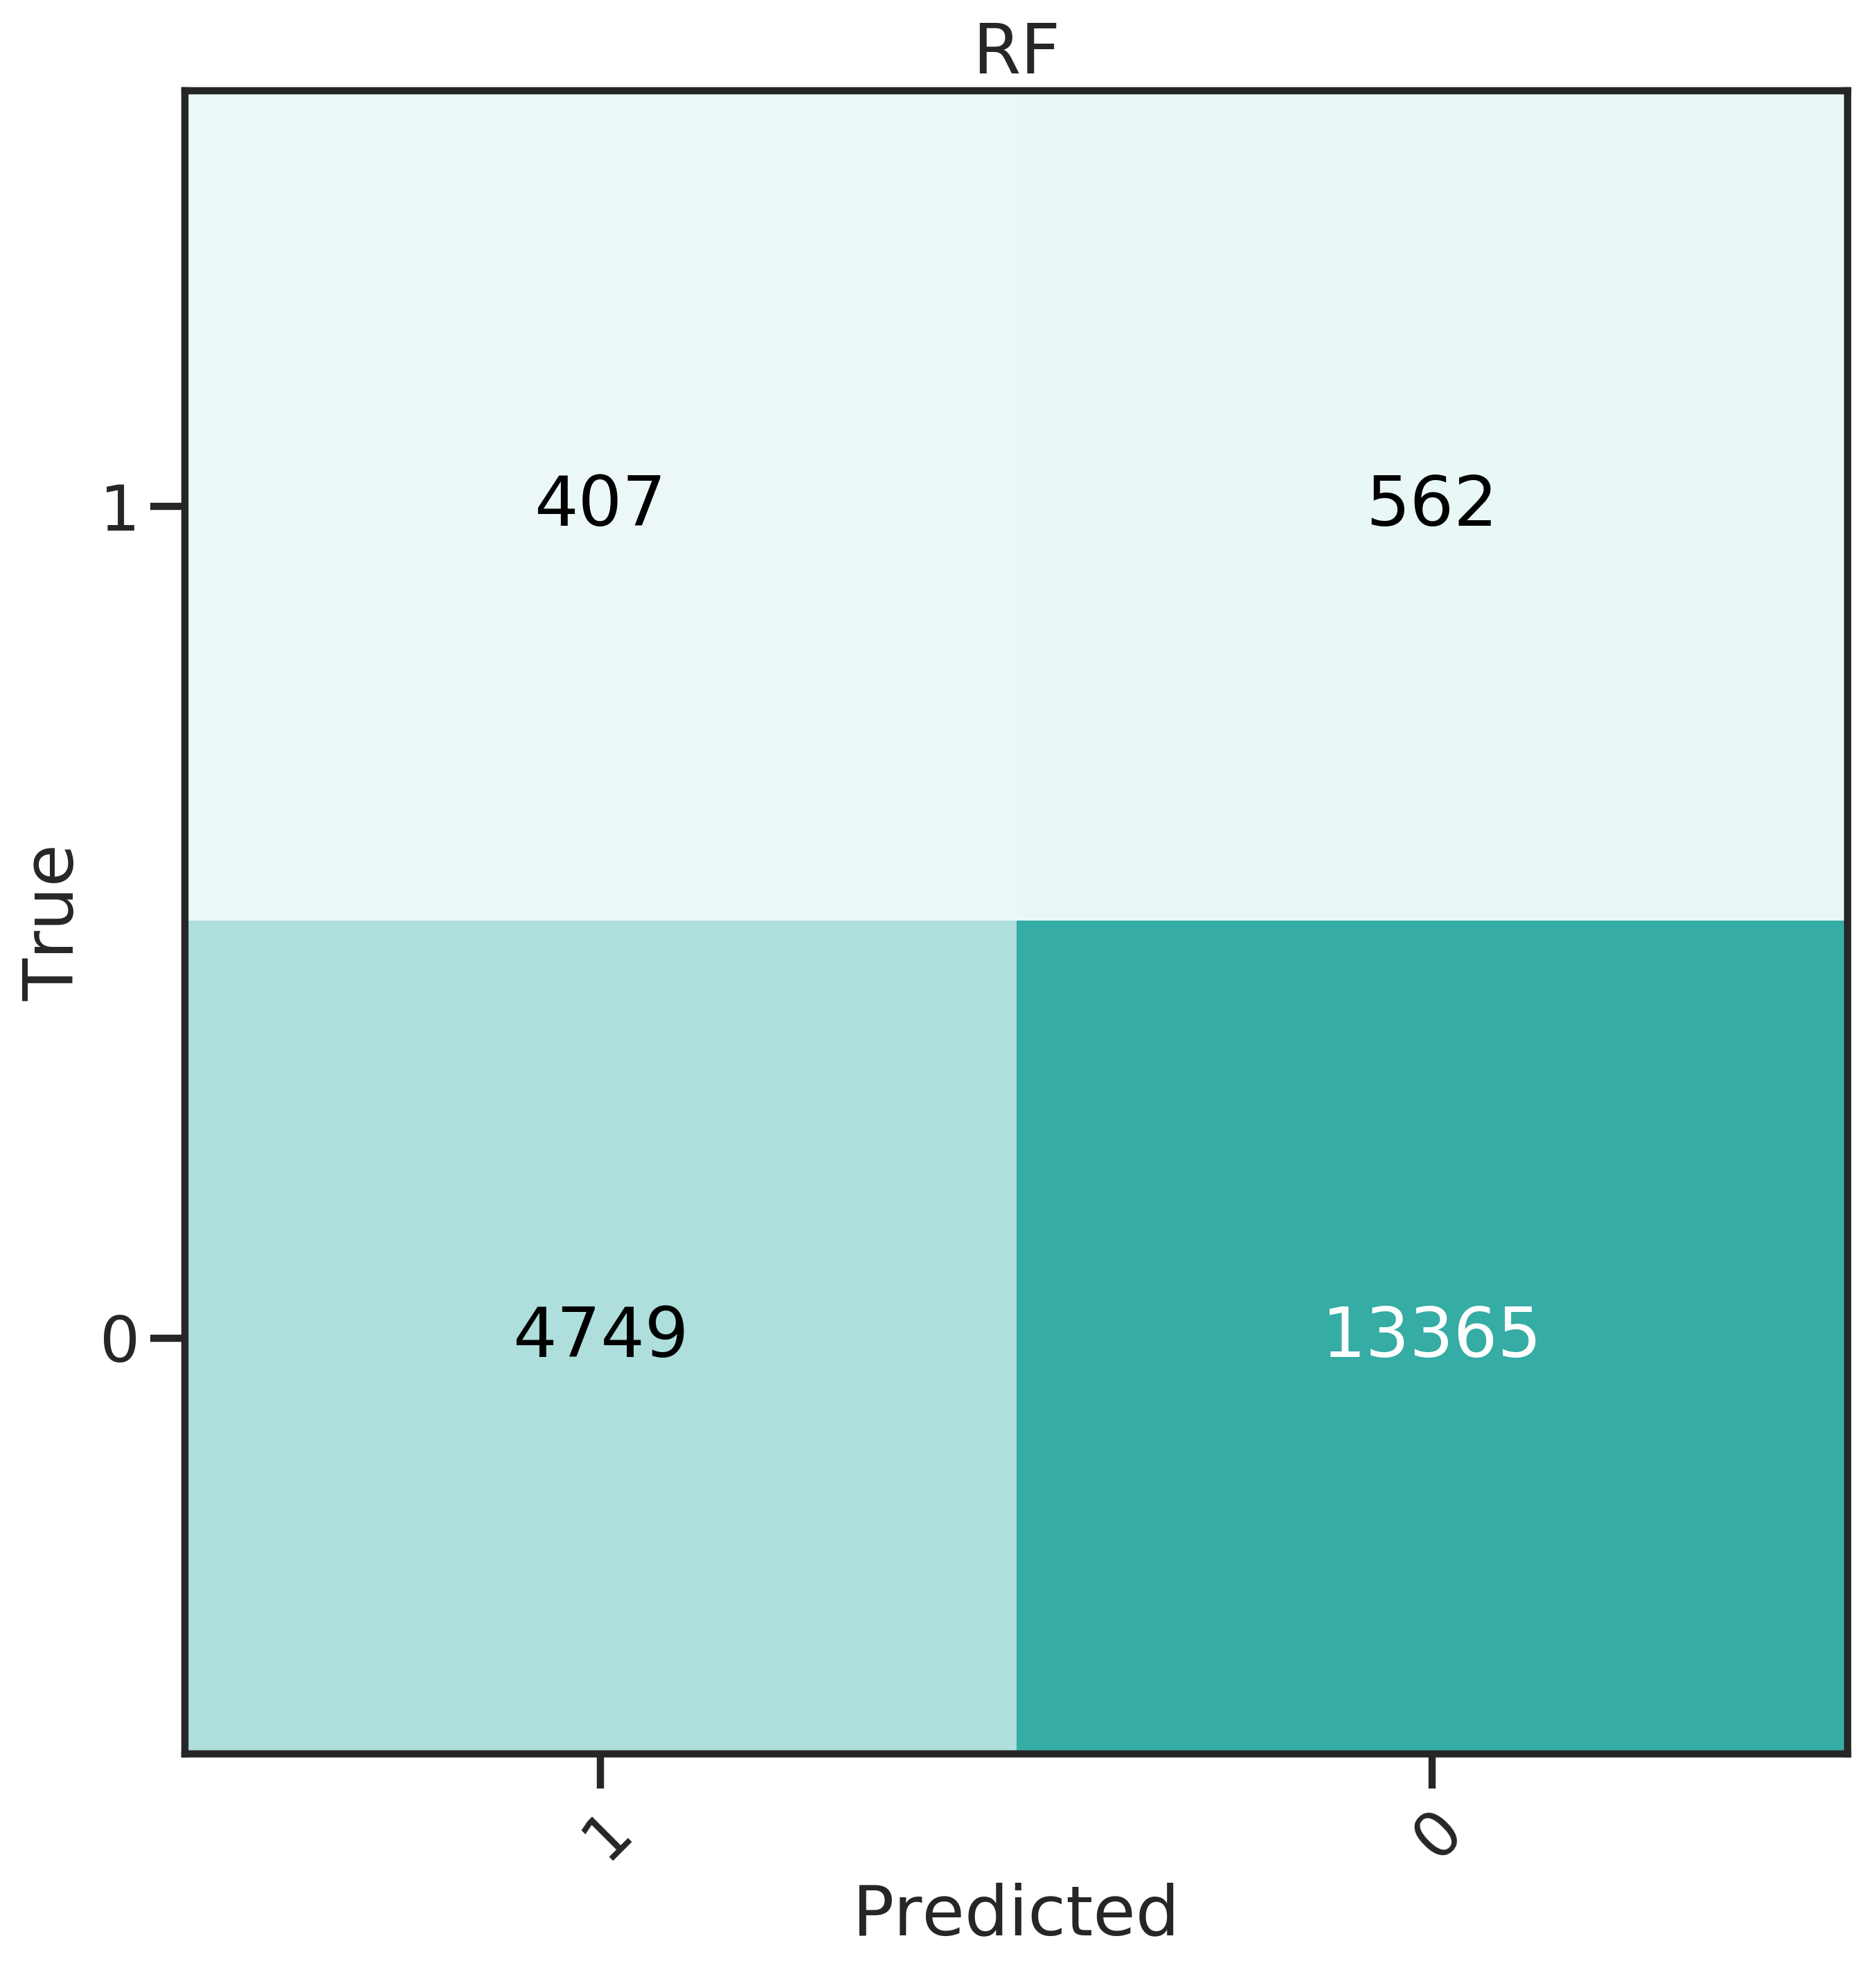

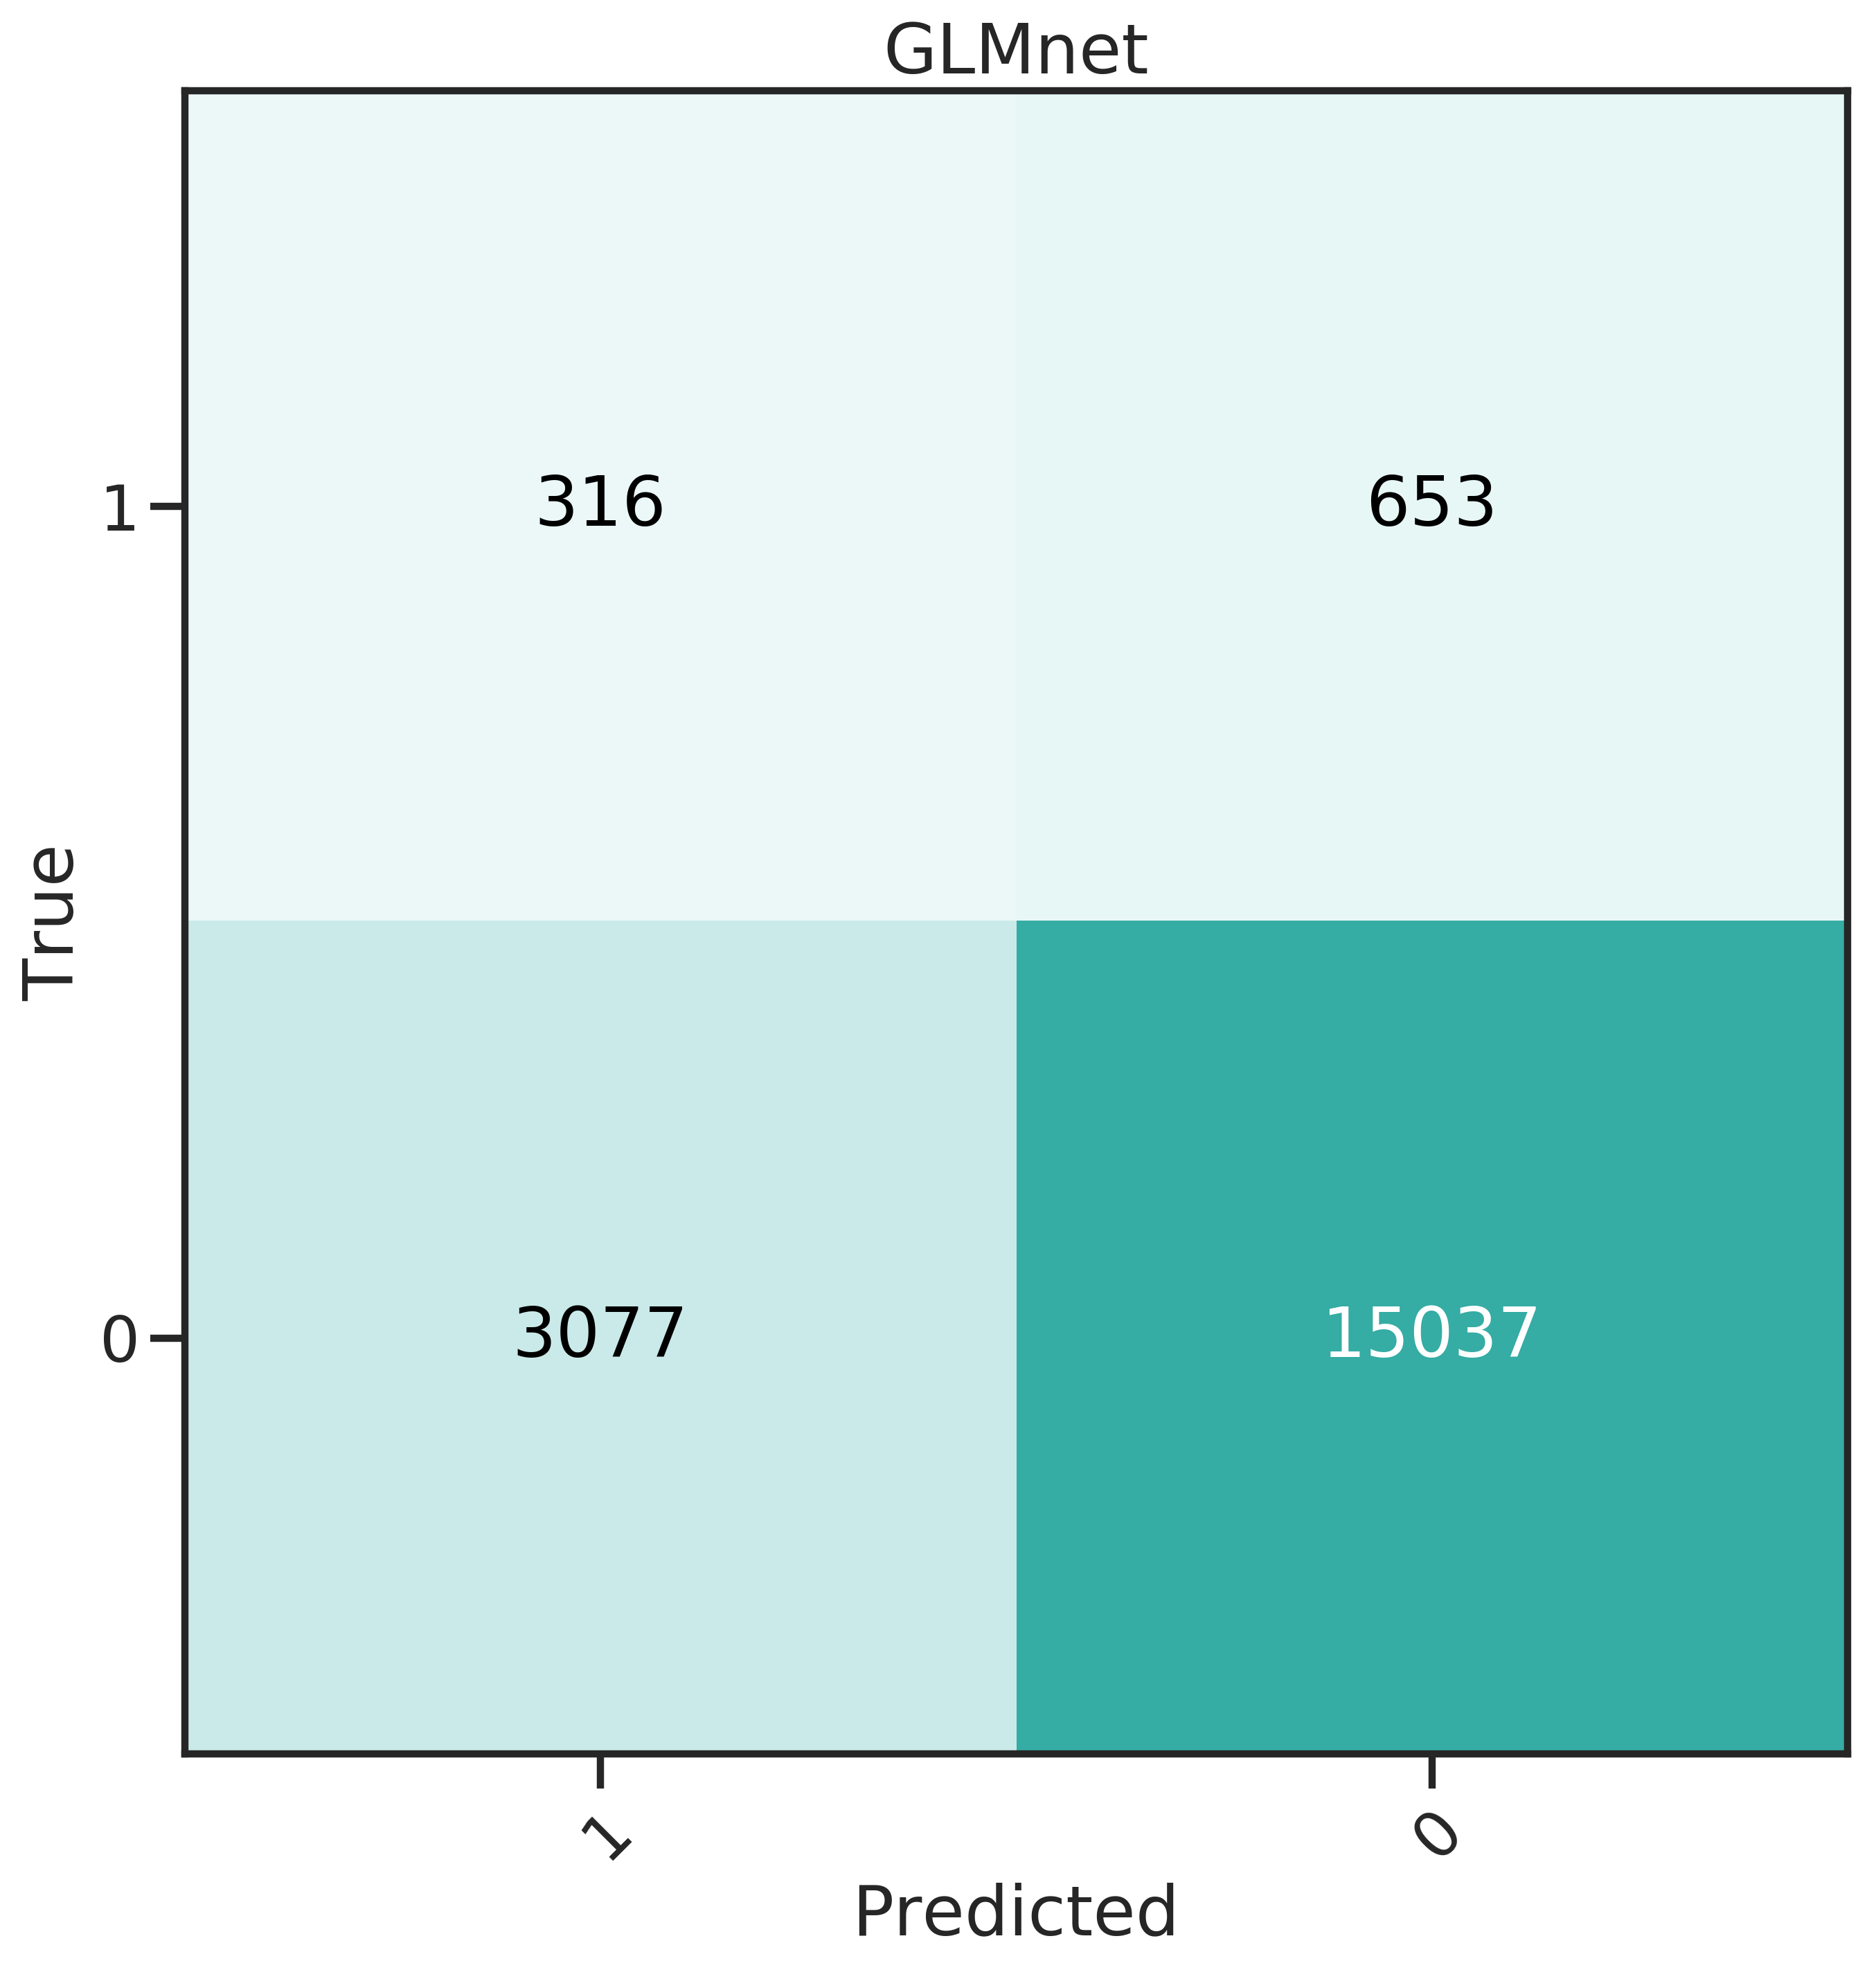

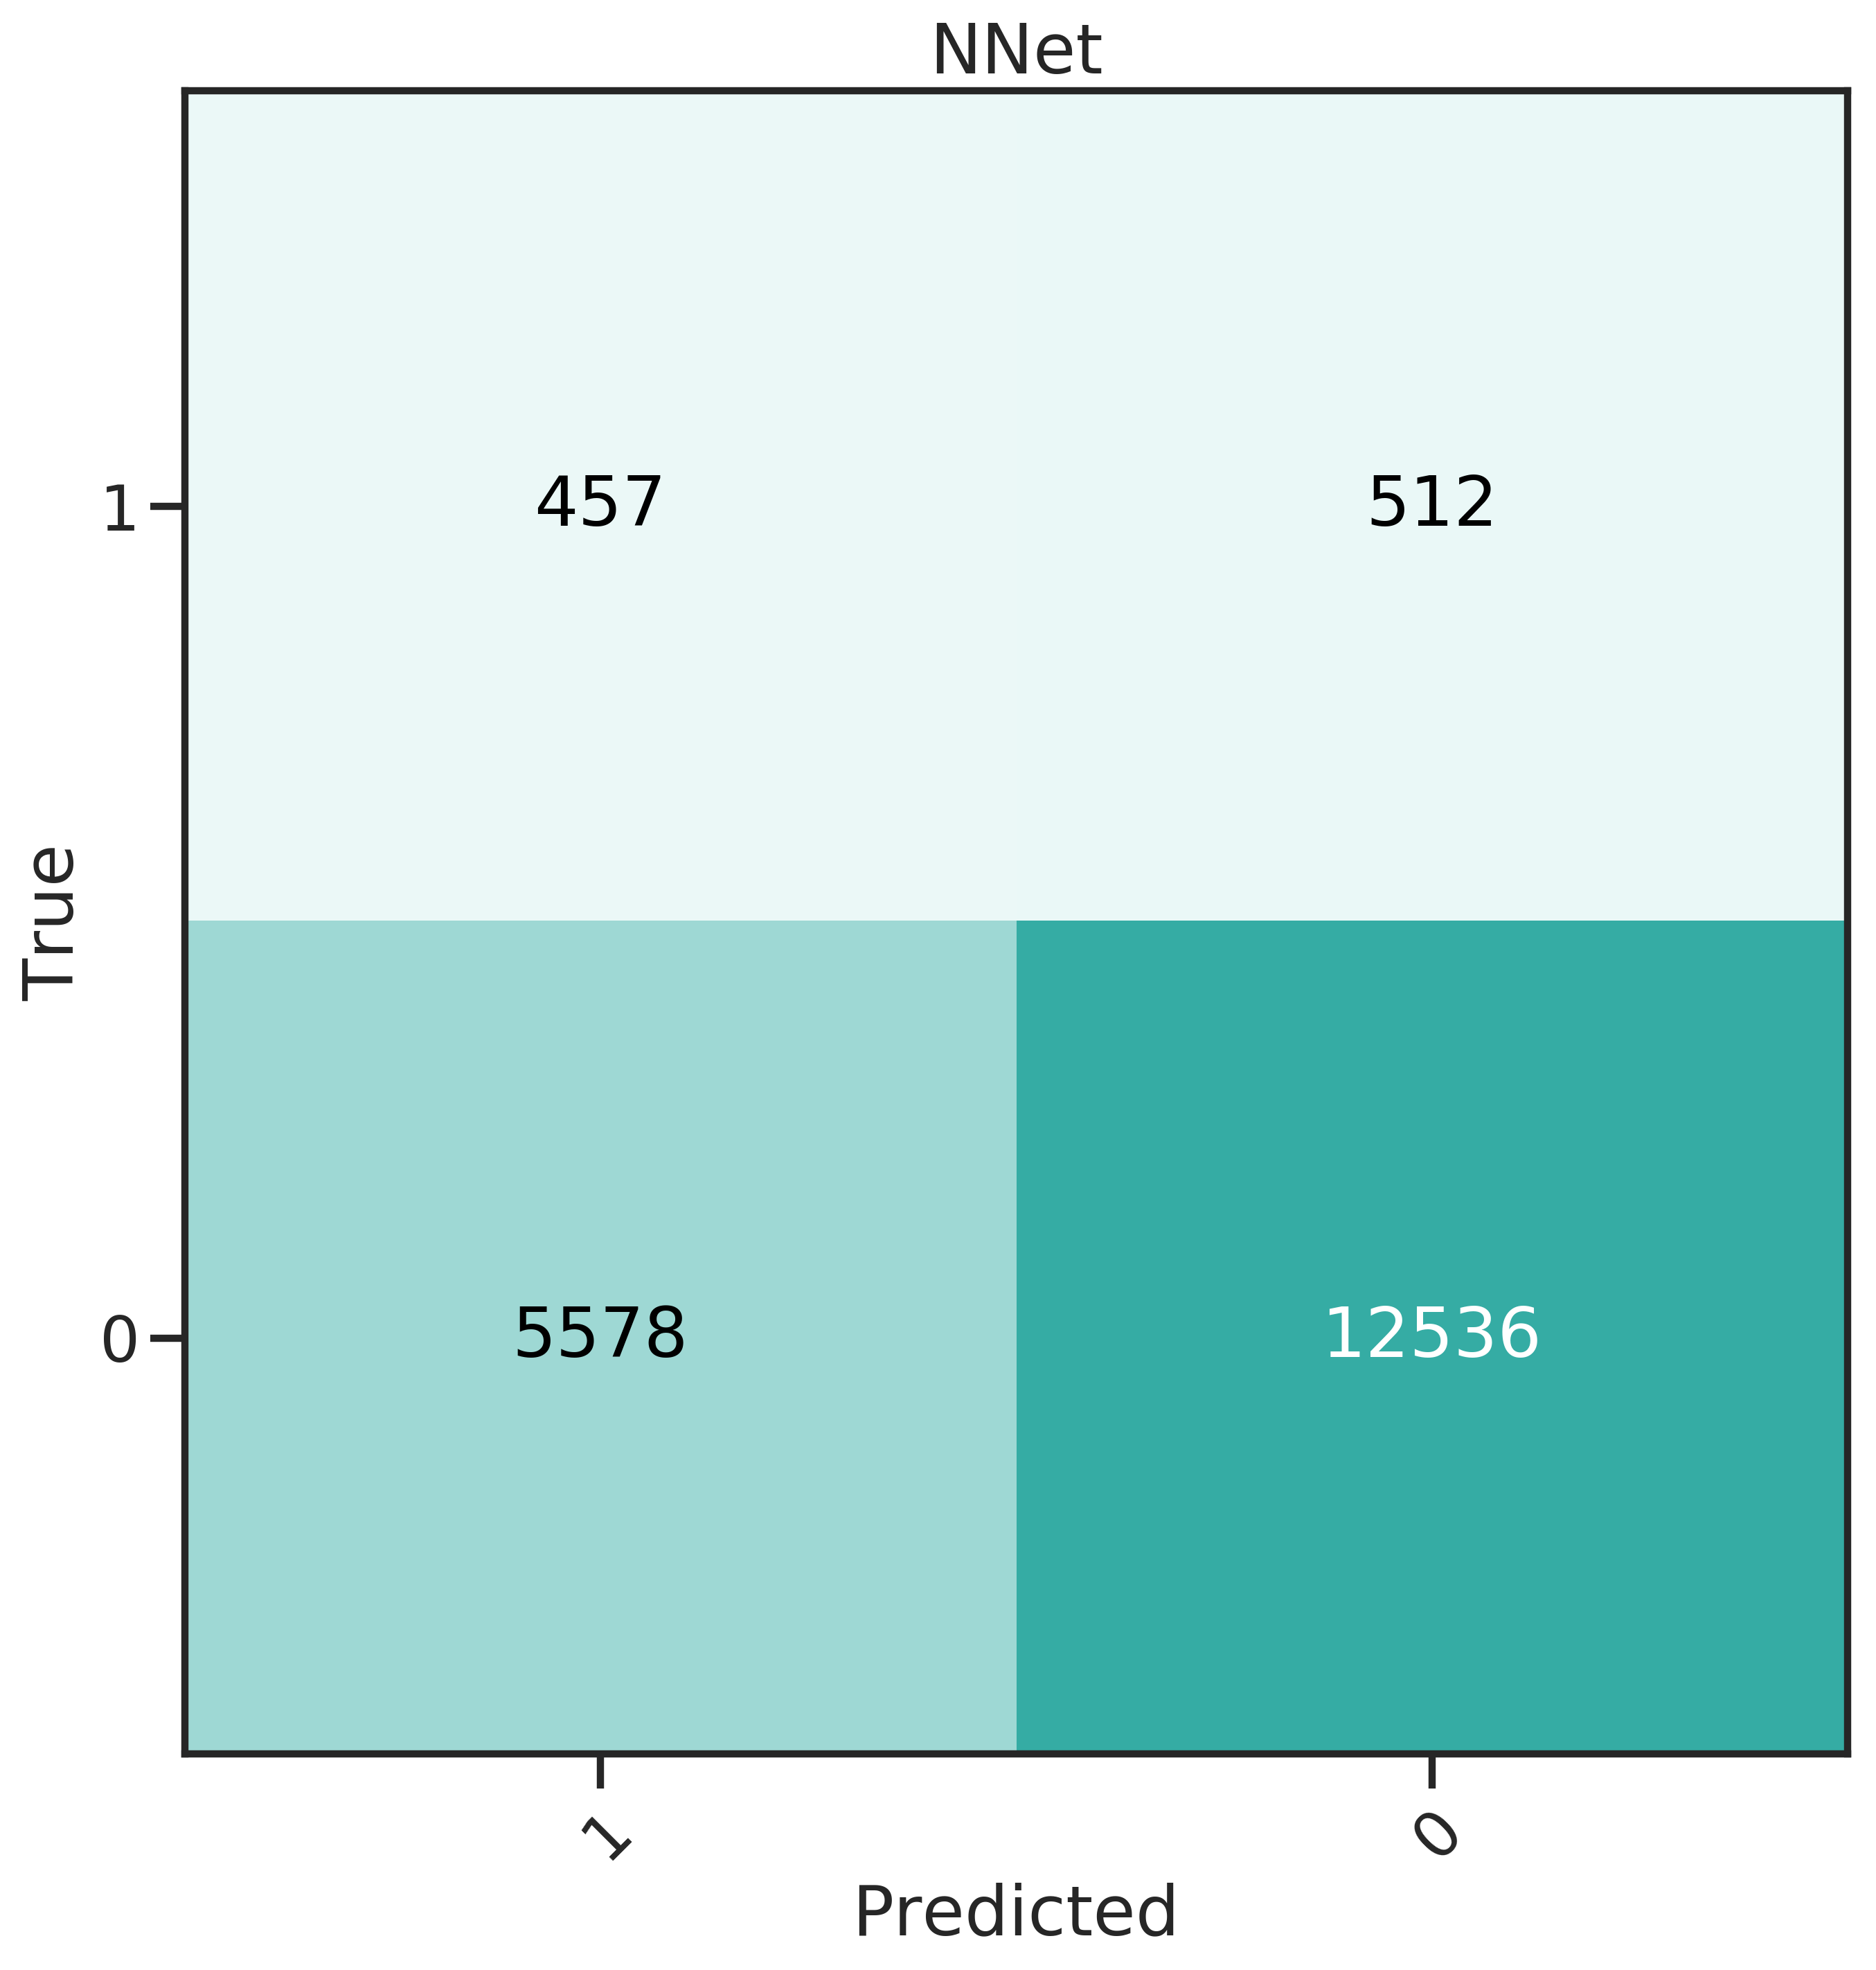

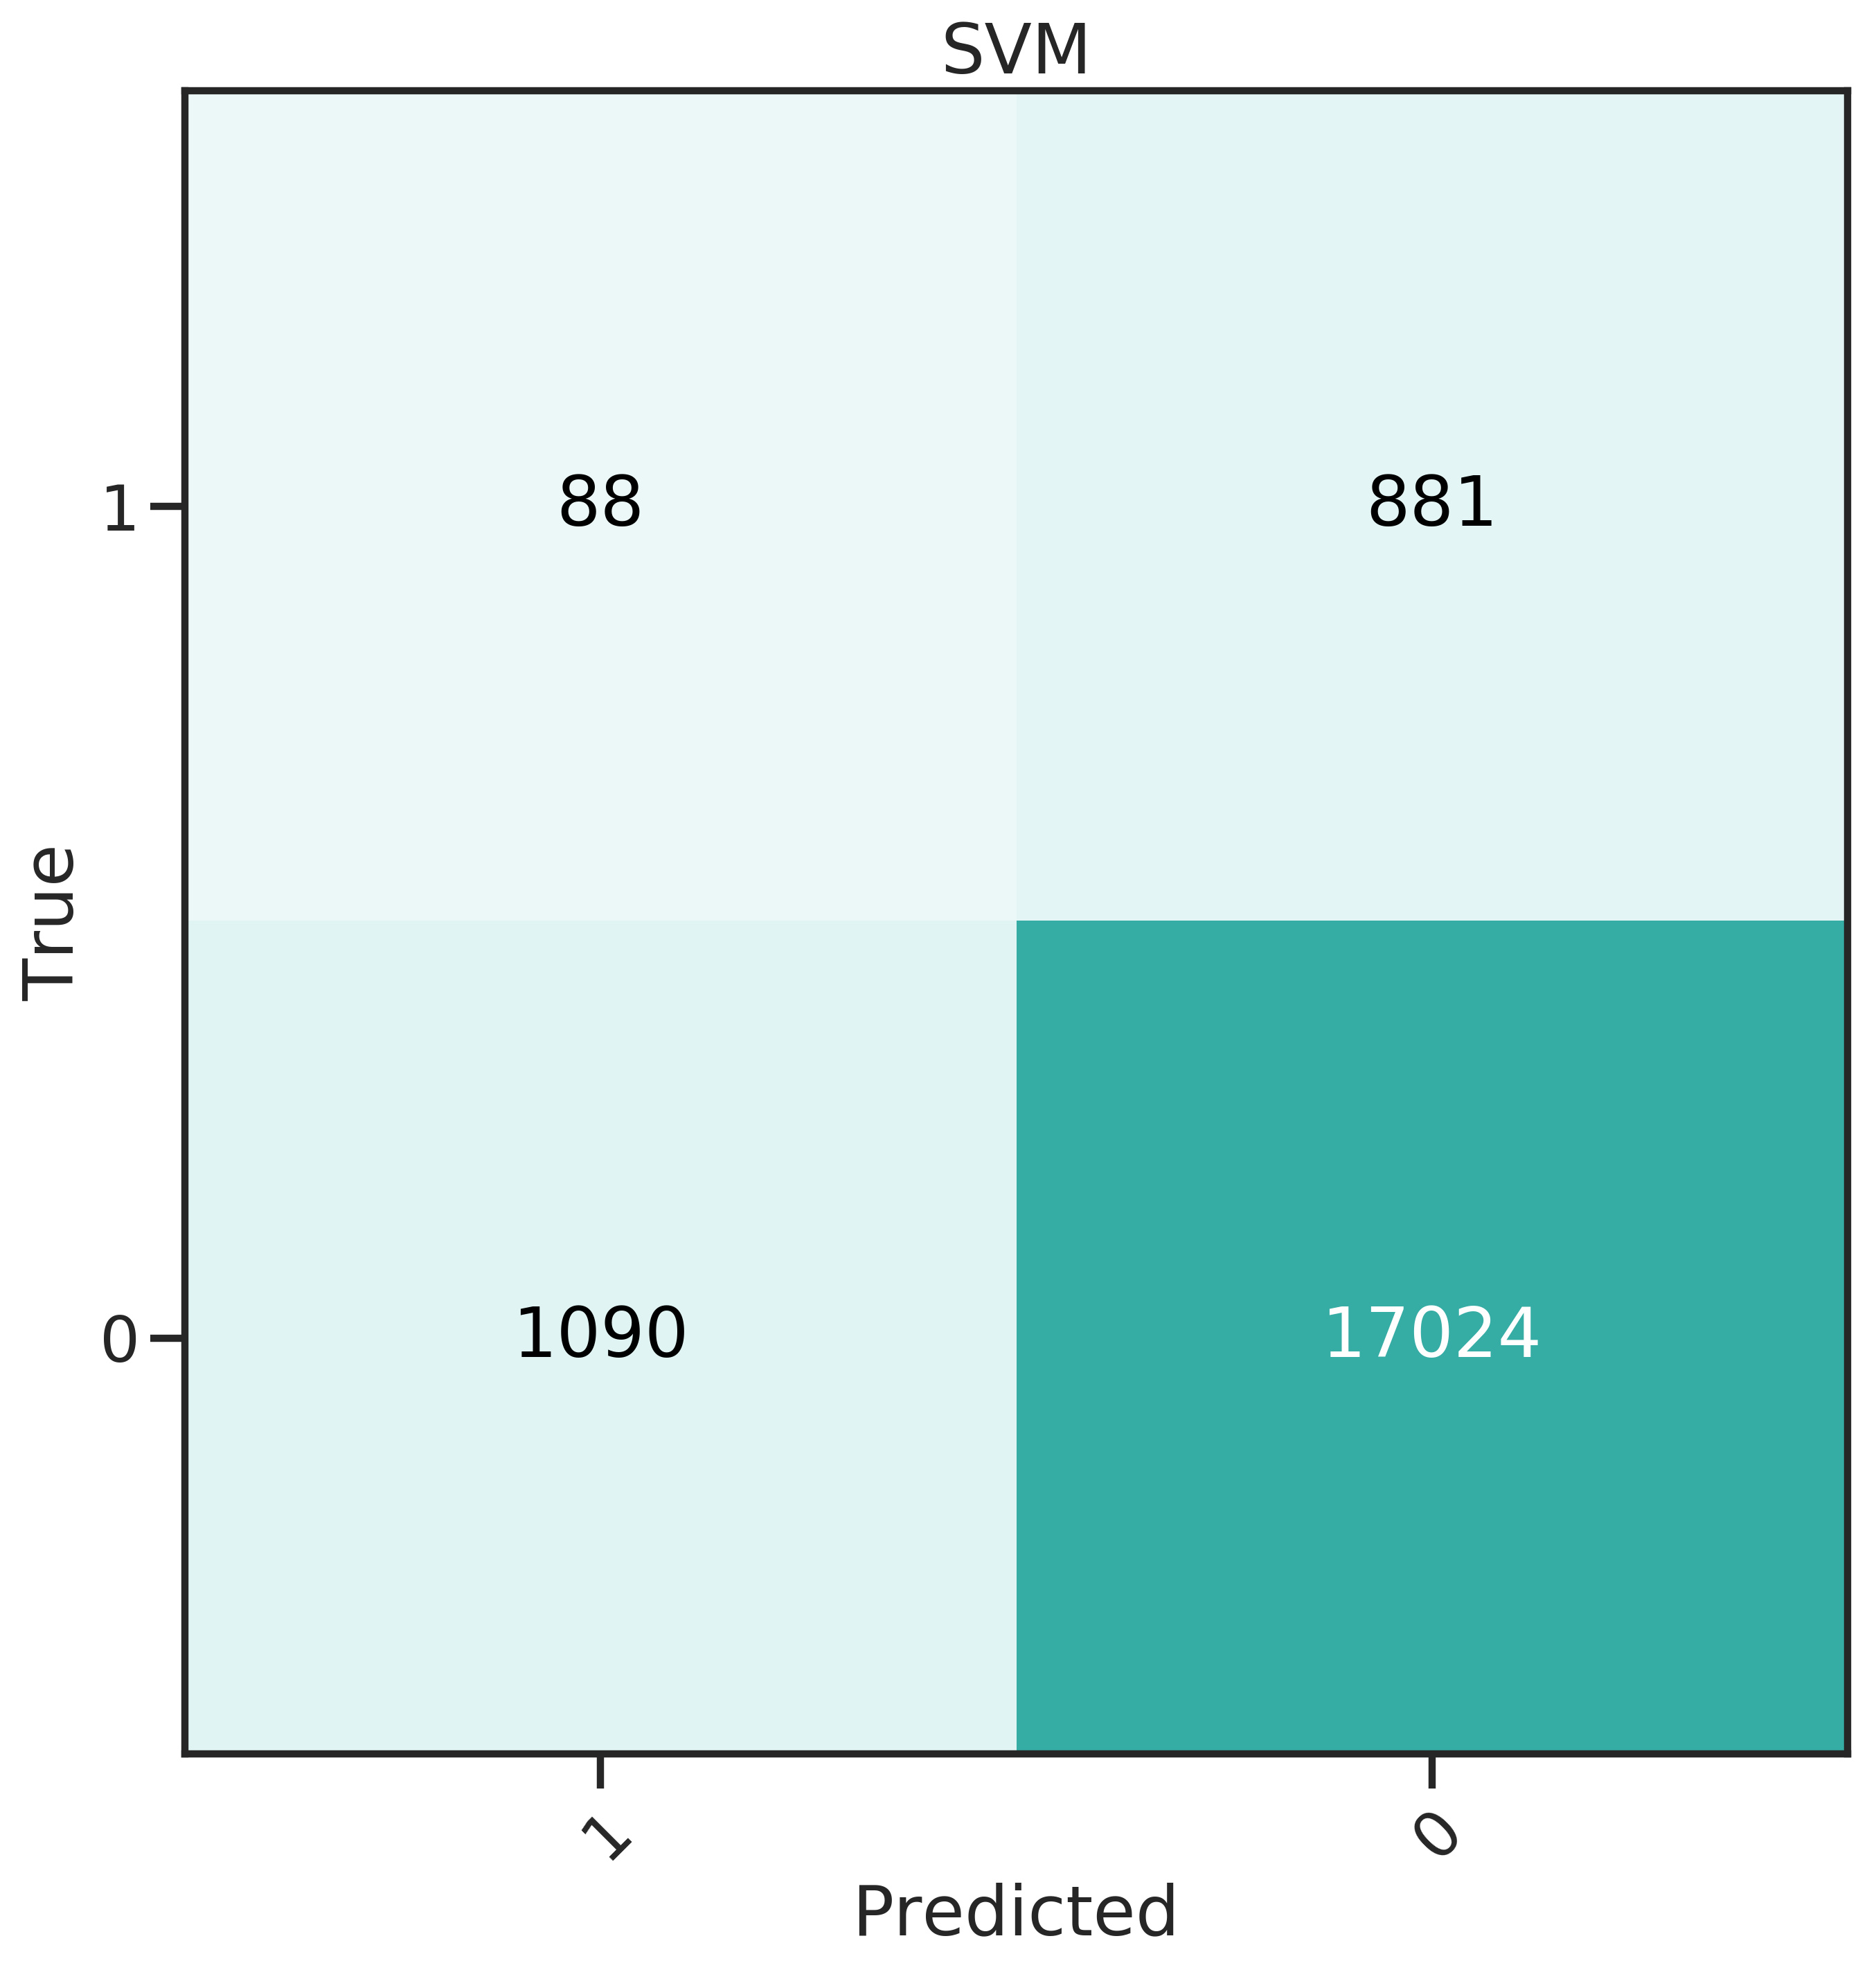

In [493]:
print_confusion_matrices("f1")

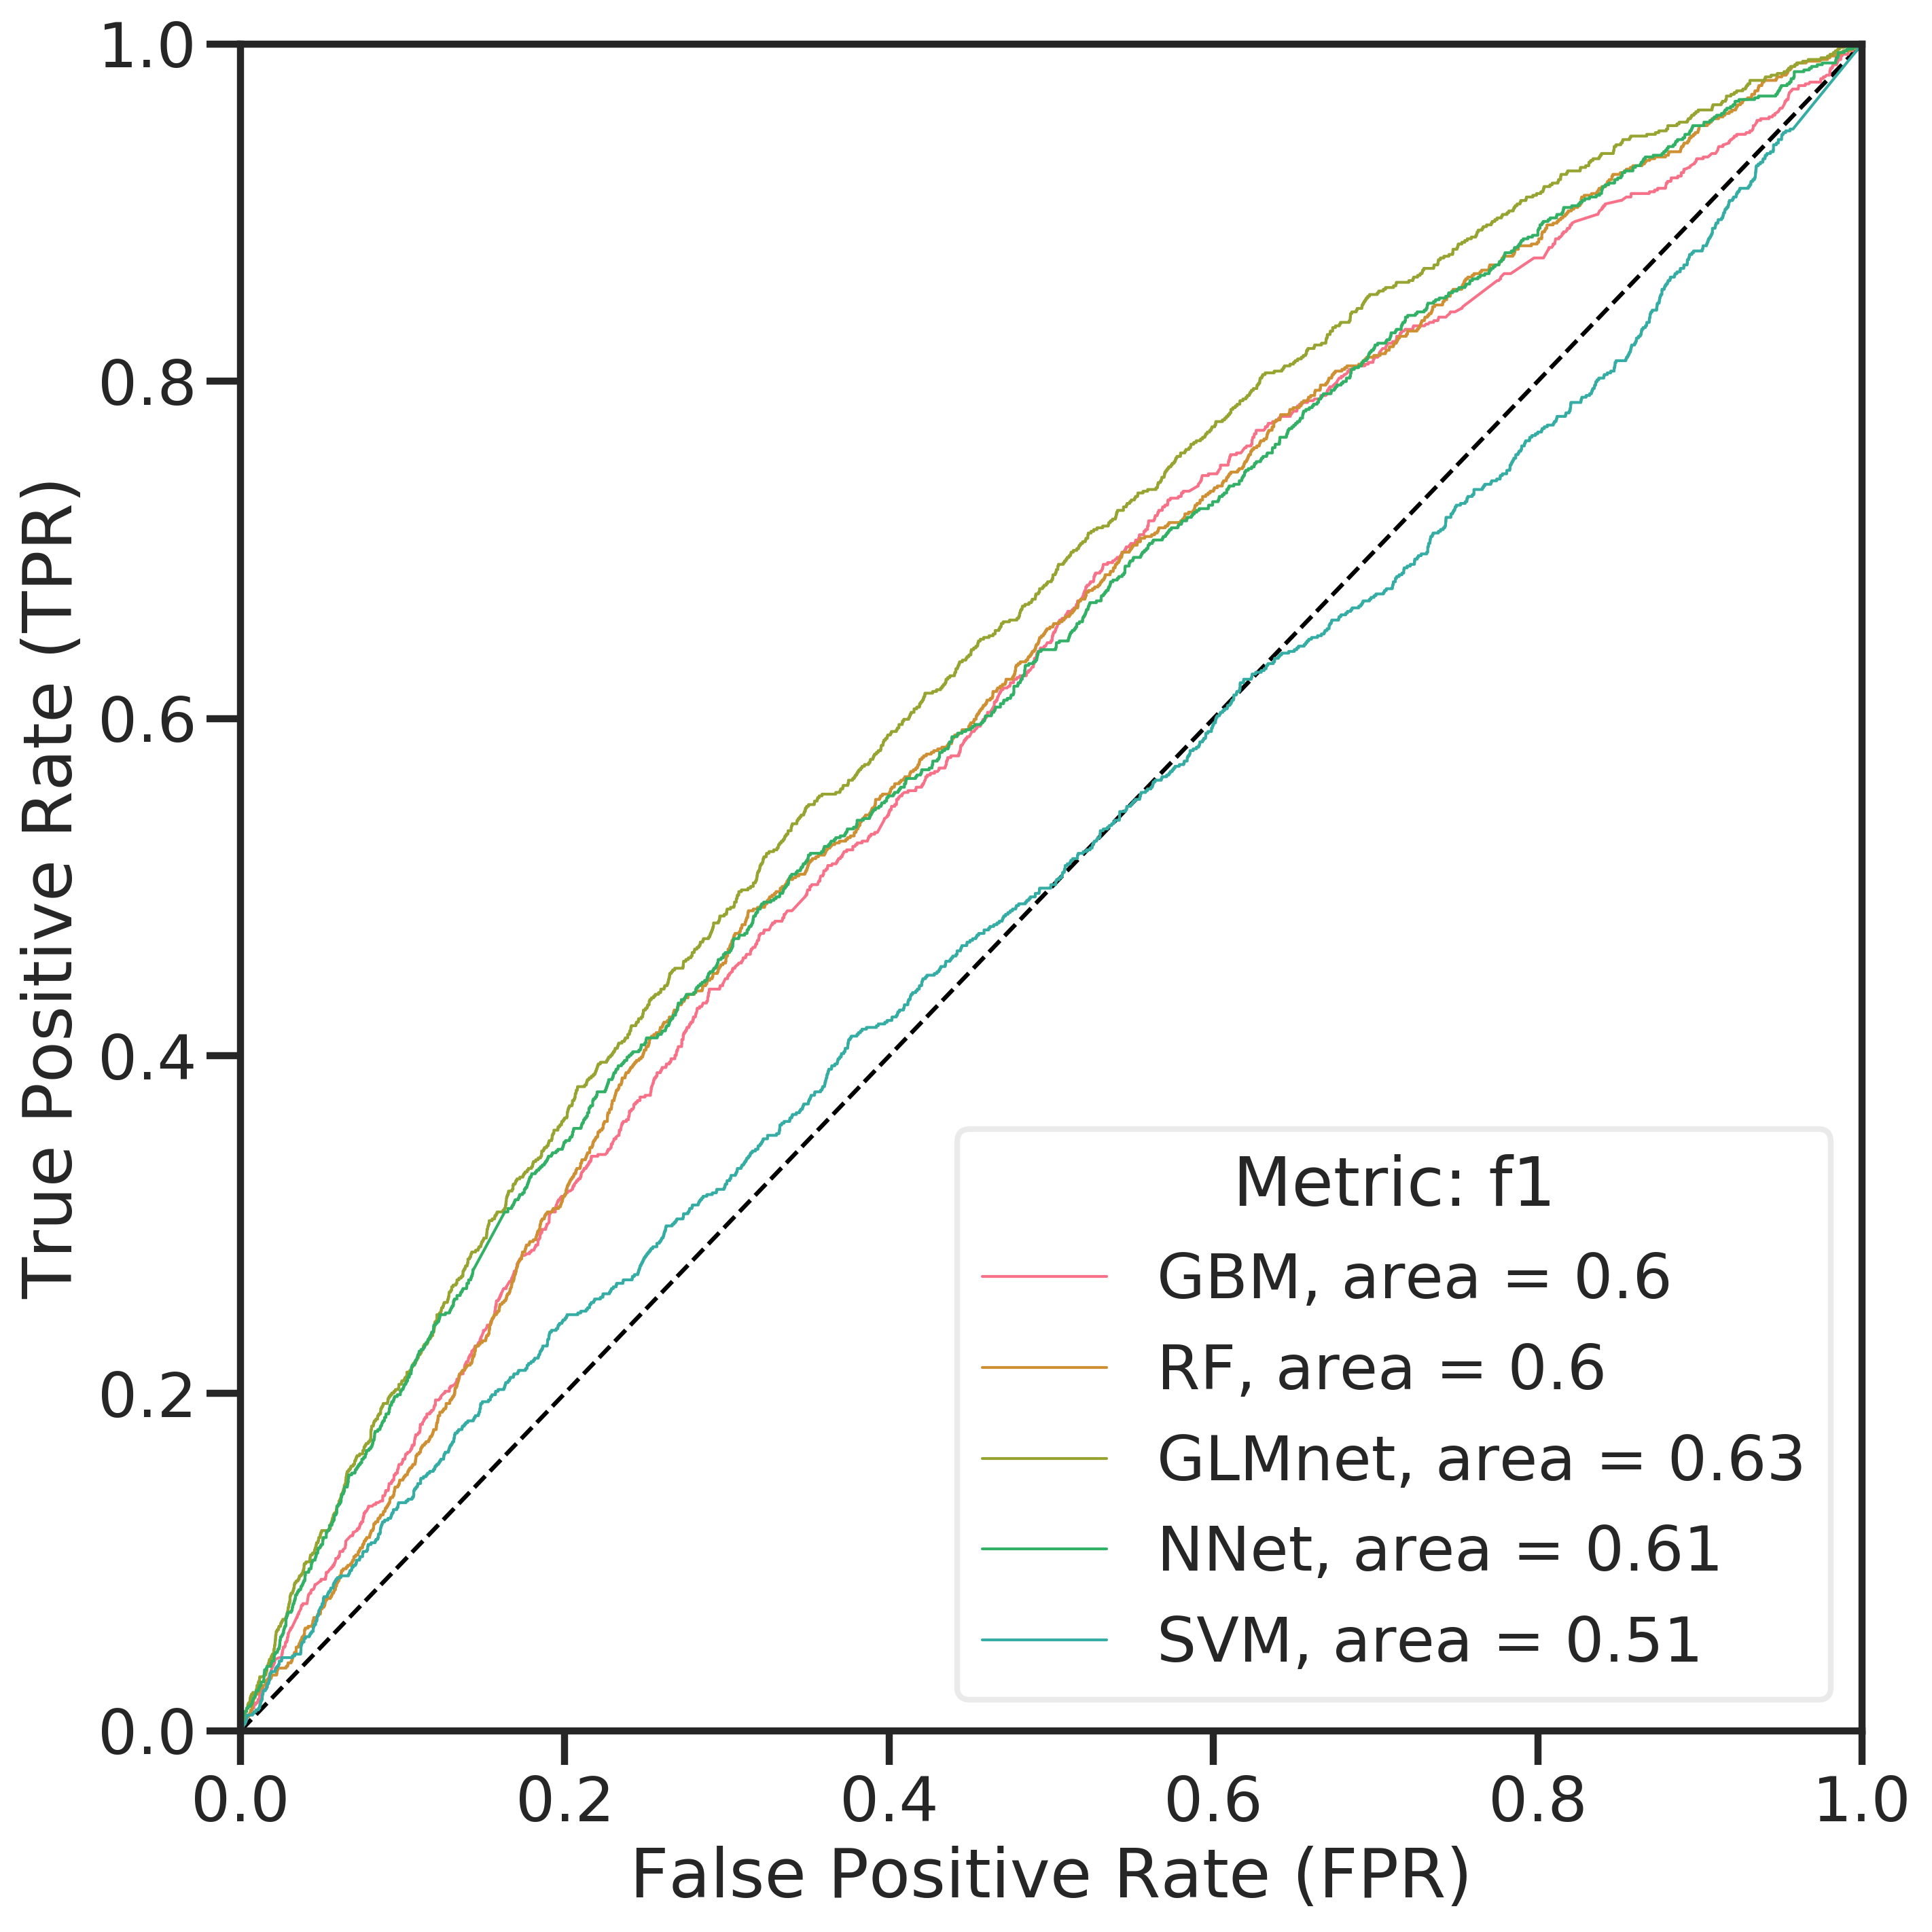

In [532]:
print_roc_auc_curve("f1")

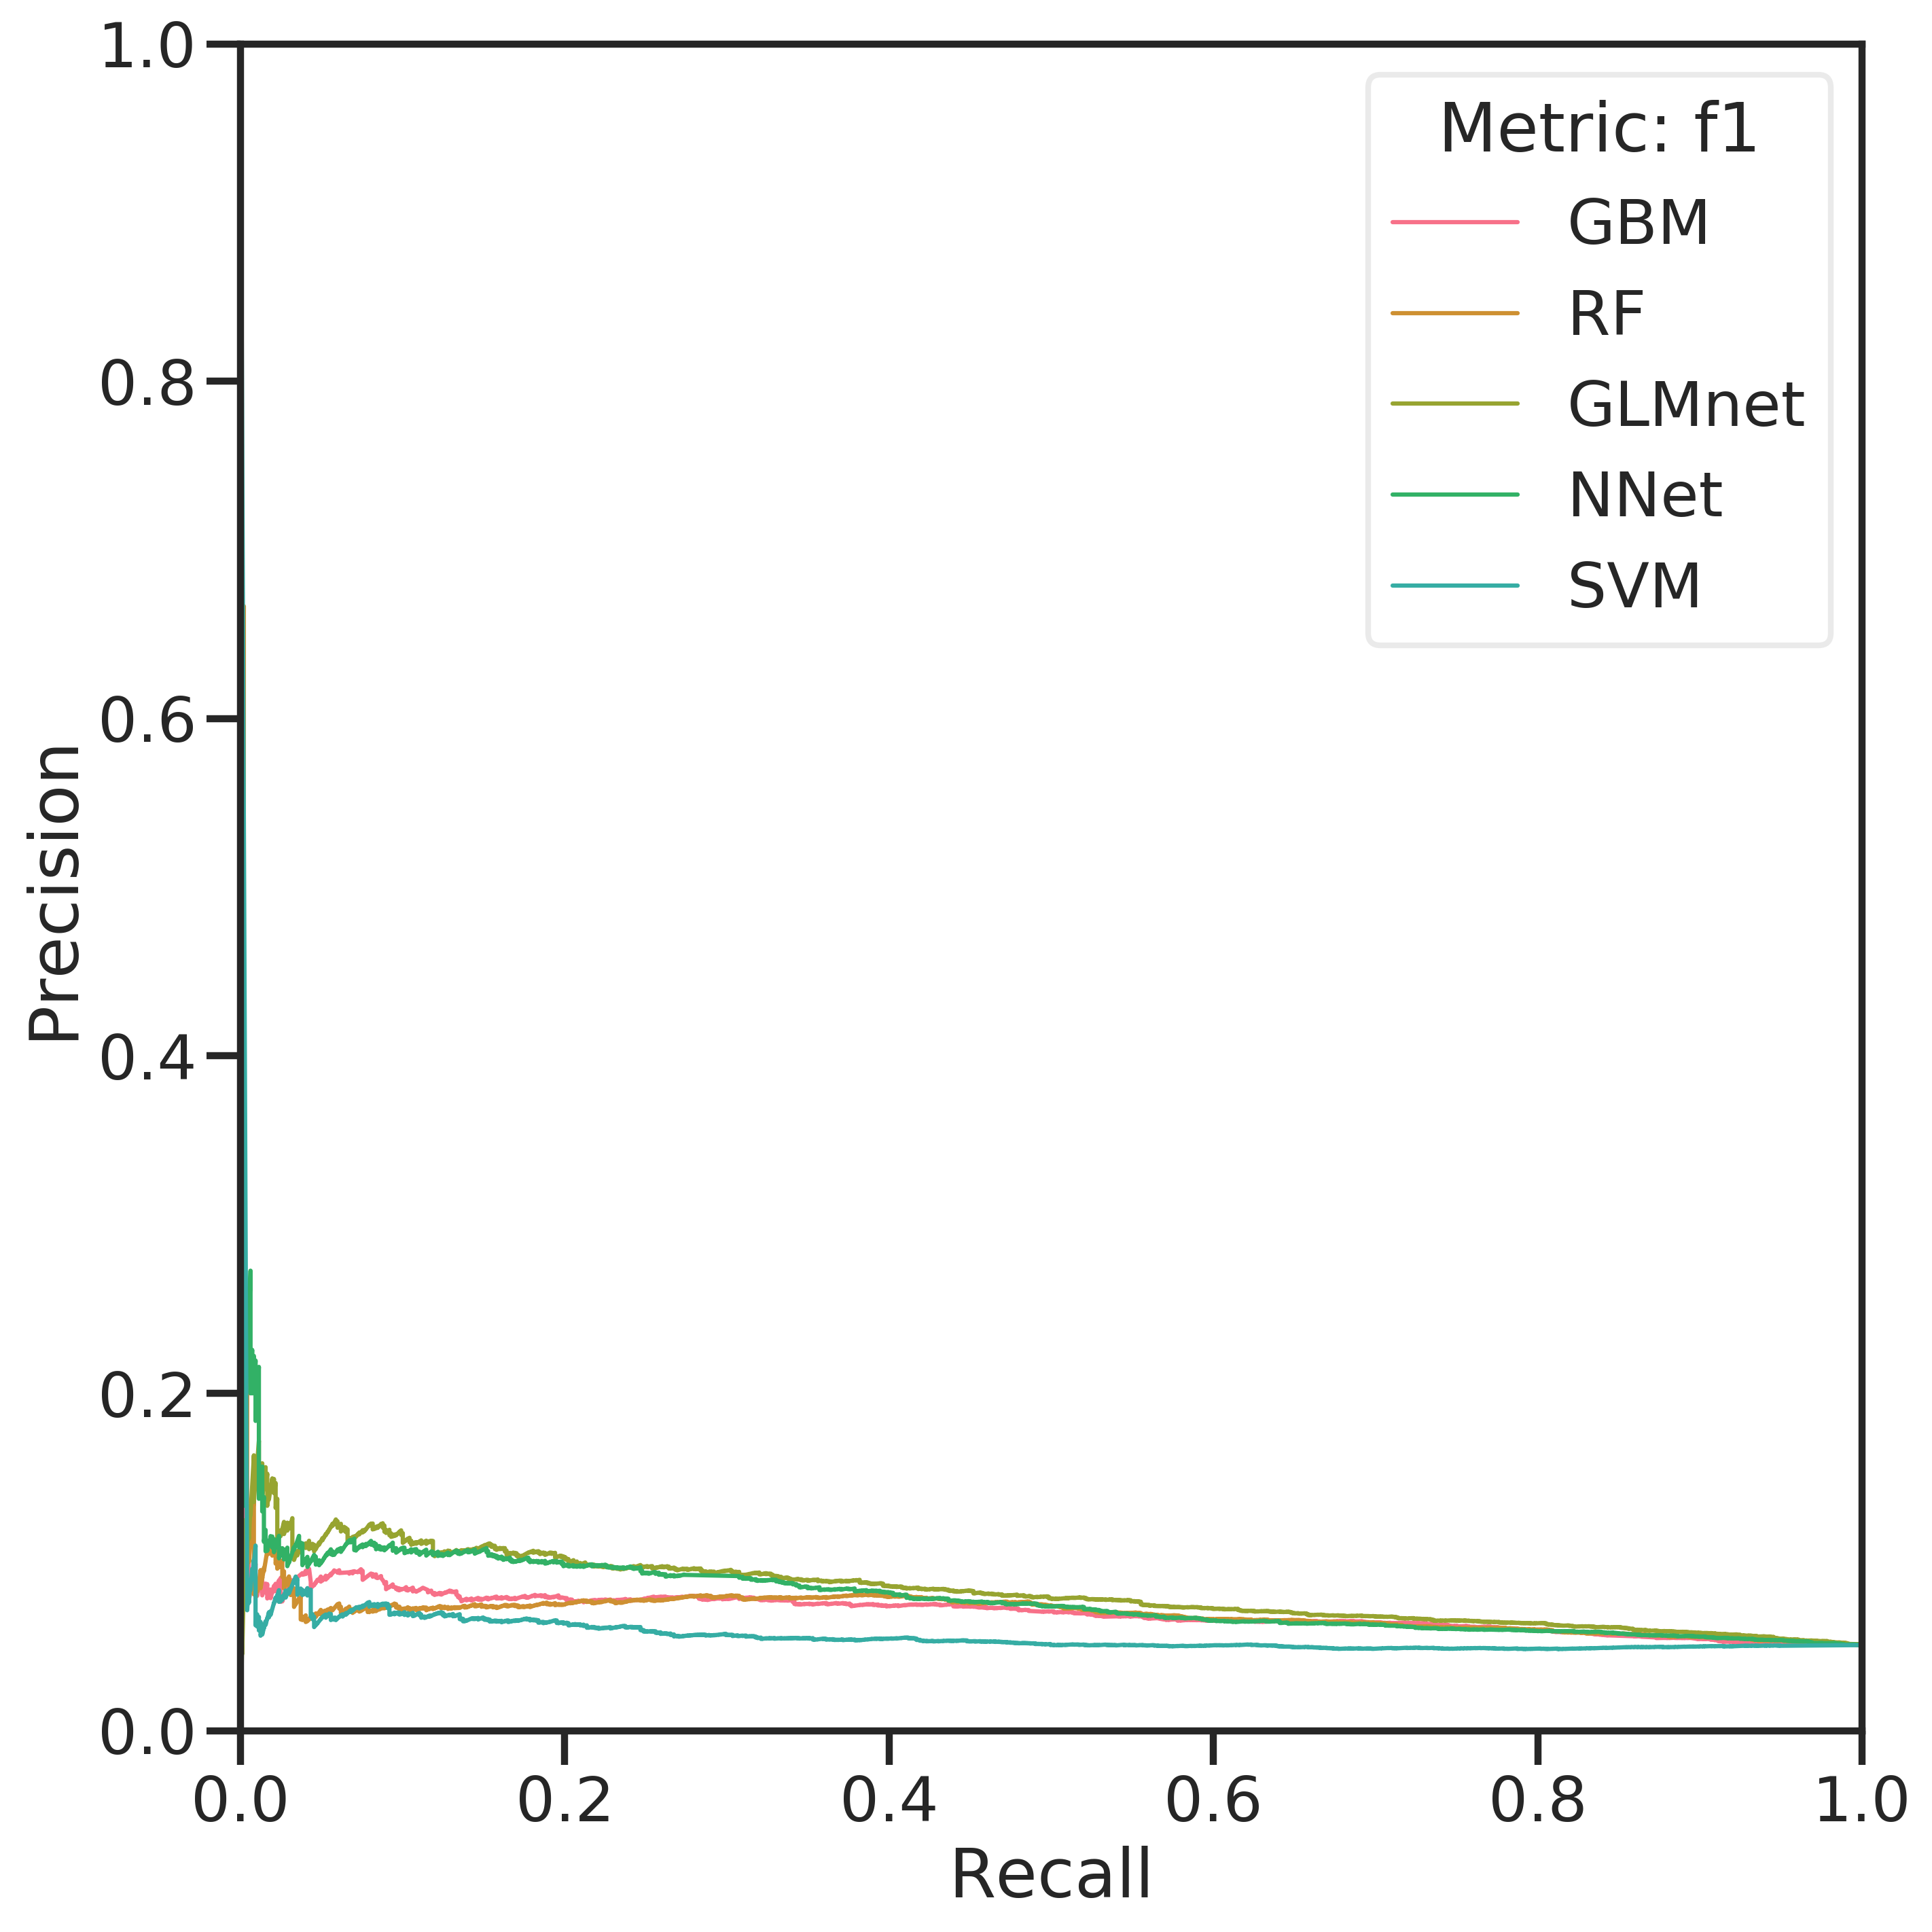

In [533]:
print_precision_recall_curve("f1")

## Attempts to further tune performance 

### Adjusting the threshold 

In [536]:
results_file = "classifiers_refit_recall.pkl"
with open(pathlib.Path(Config.get("model_store"), results_file), "rb") as f:
    classifiers = pickle.load(f)

In [537]:
best_model = classifiers["GLMnet"]["best_estimator"]

In [538]:
y_scores = best_model.predict_proba(X_val)[:,1]

In [539]:
p, r, thresholds = precision_recall_curve(y_val.TARGET_B.values, y_scores)

In [540]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_val.TARGET_B.values, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0., 1.01]);
    plt.xlim([0., 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
markersize=15)
    
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

In [ ]:
precision_recall_threshold(p,r,thresholds, t=0.4)

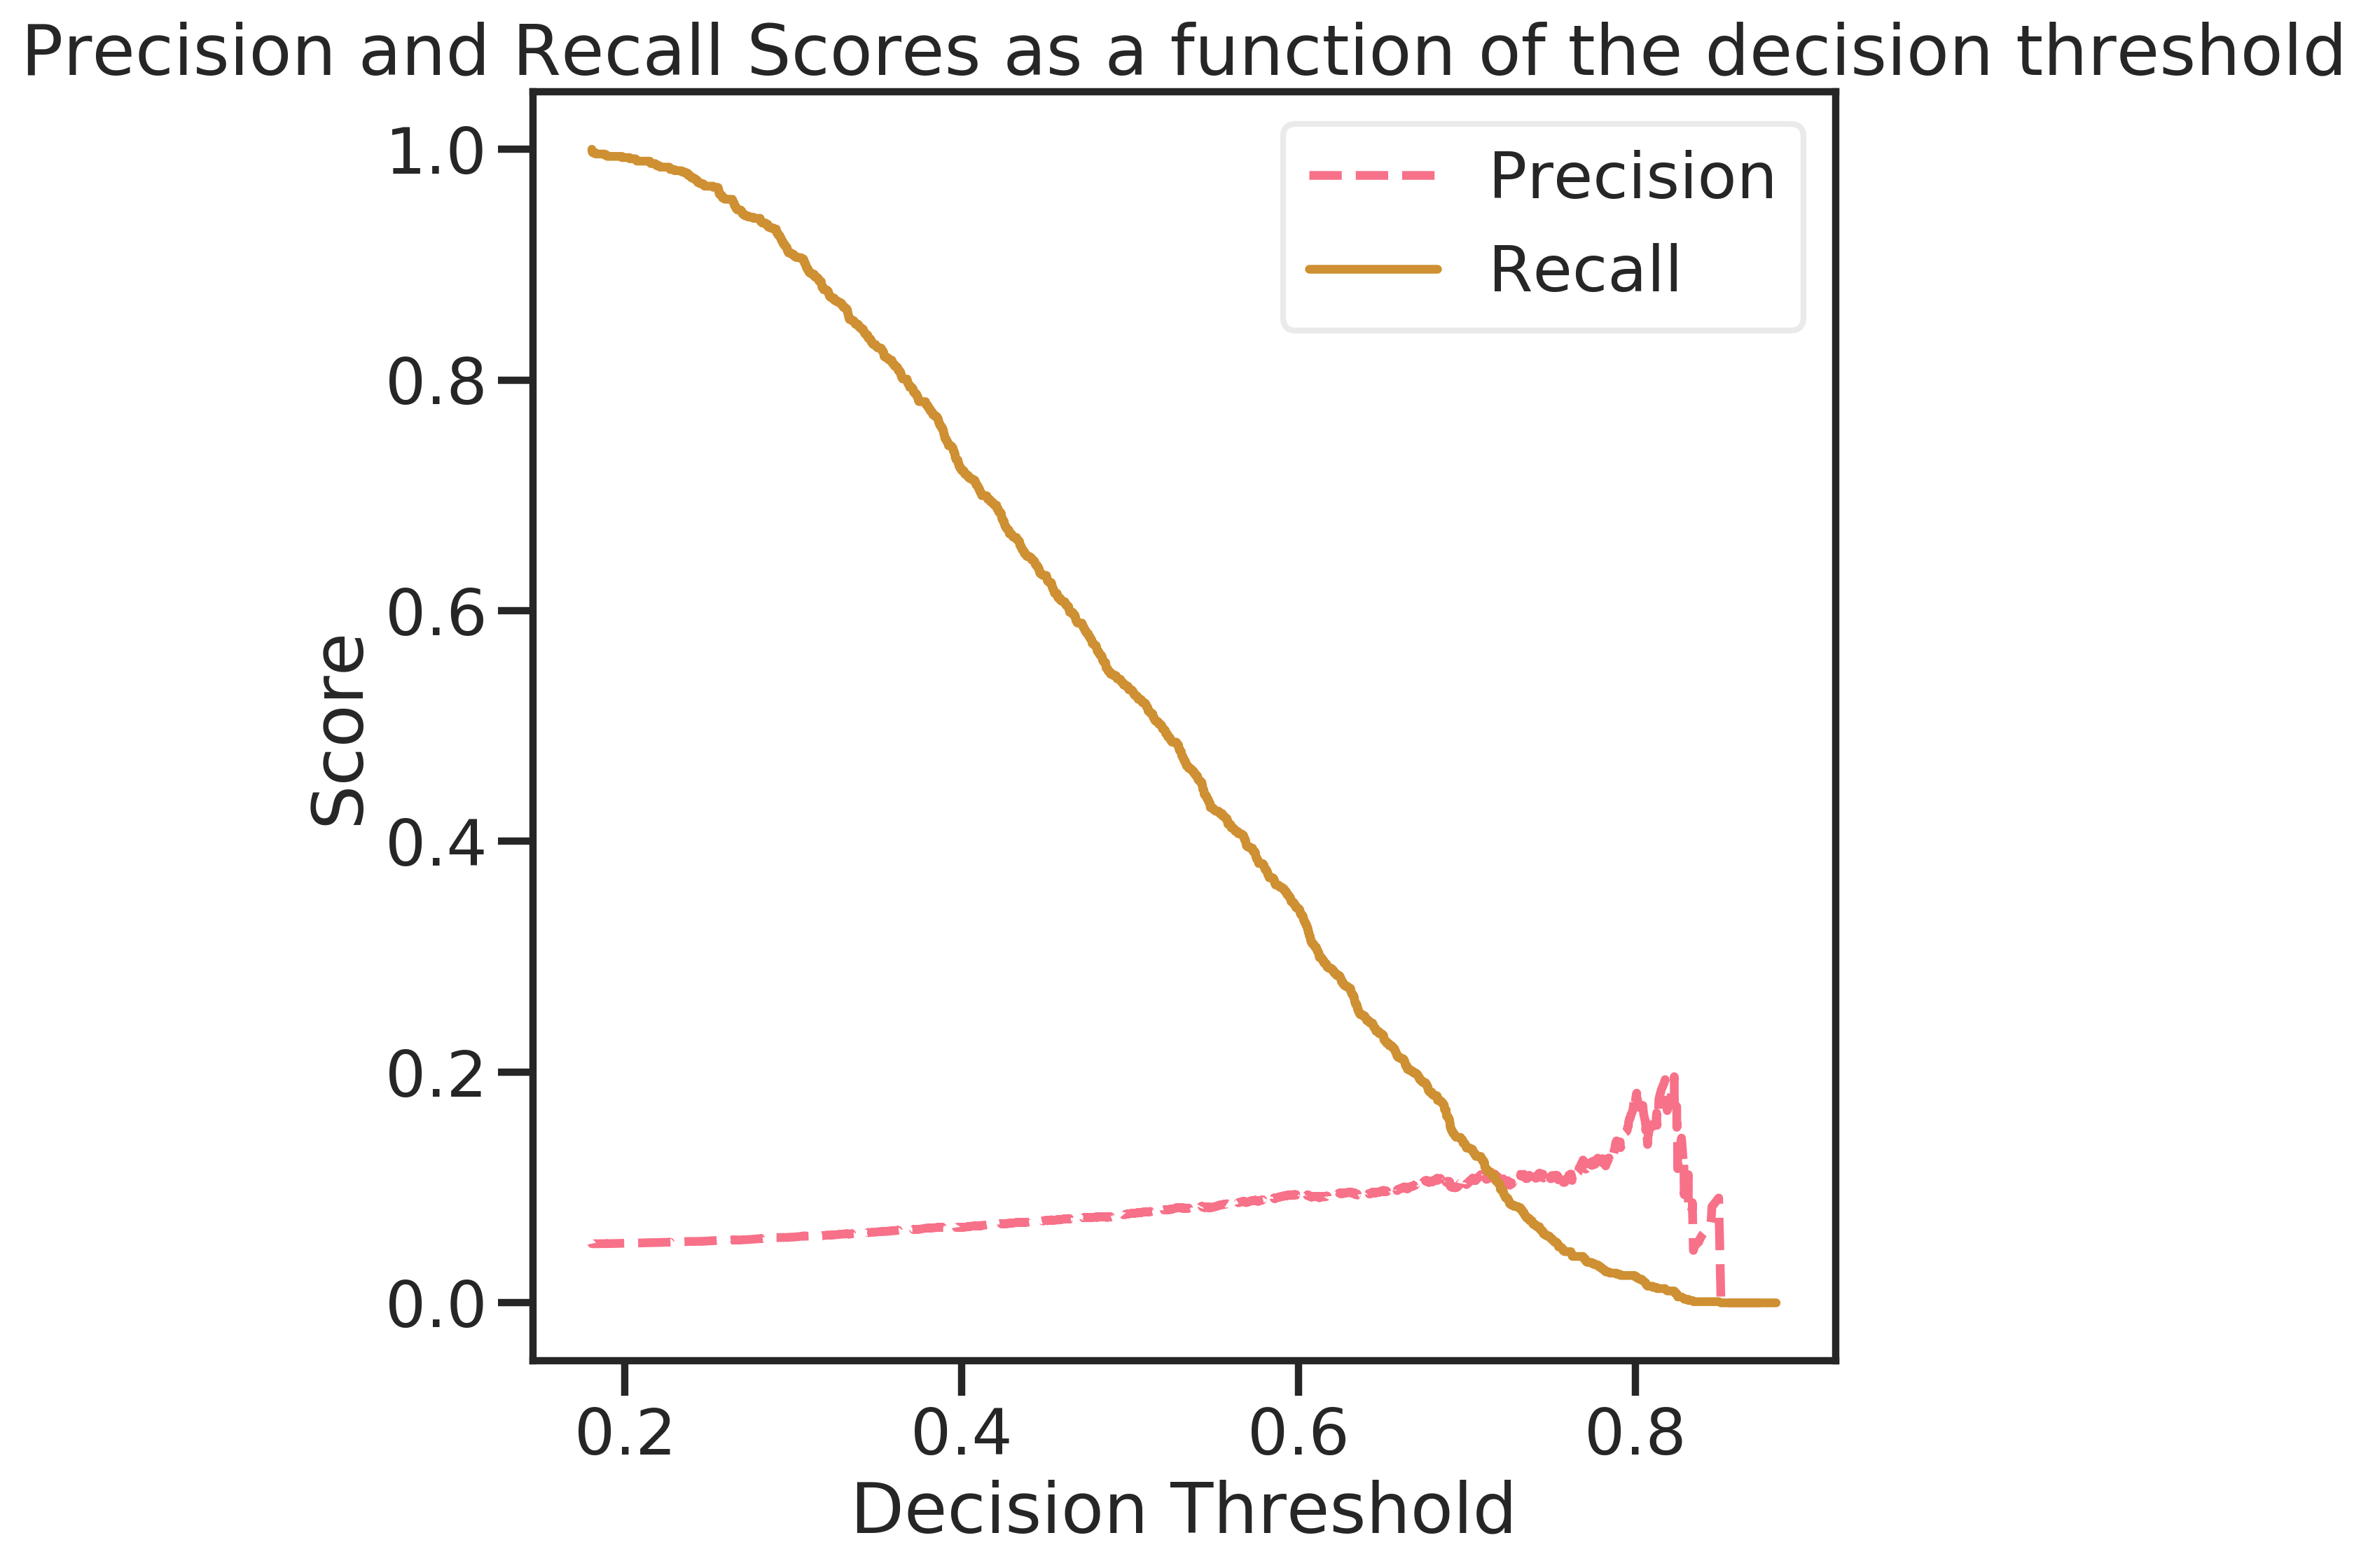

In [542]:
plot_precision_recall_vs_threshold(p,r,thresholds)

### Combining classifiers 

In [308]:
from sklearn.ensemble import VotingClassifier

In [544]:
results_file = "classifiers_refit_{}.pkl".format("recall")
with open(pathlib.Path(Config.get("model_store"), results_file), "rb") as f:
    classifiers = pickle.load(f)

In [546]:
vc = VotingClassifier(estimators = [
    ("glmnet", classifiers["GLMnet"]["best_estimator"]),
    ("nnet", classifiers["NNet"]["best_estimator"])
],
n_jobs=-1)

In [547]:
vc.fit(X_train.values, y_train.TARGET_B.values)

VotingClassifier(estimators=[('glmnet', Pipeline(memory=None,
     steps=[('scaler', Rescaler(transformer='ptrans')), ('sampler', BorderlineSMOTE(k_neighbors=5, kind='borderline-1', m_neighbors=10, n_jobs=1,
        random_state=42, sampling_strategy='auto')), ('classifier', LogitNet(alpha=0.6215636406741194, cut_po...ue, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))]))],
         flatten_transform=None, n_jobs=-1, voting='hard', weights=None)

In [548]:
print(classification_report_imbalanced(y_val.TARGET_B.values,vc.predict(X_val.values)))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.68      0.51      0.80      0.59      0.35     18114
          1       0.08      0.51      0.68      0.14      0.59      0.34       969

avg / total       0.92      0.68      0.51      0.77      0.59      0.35     19083



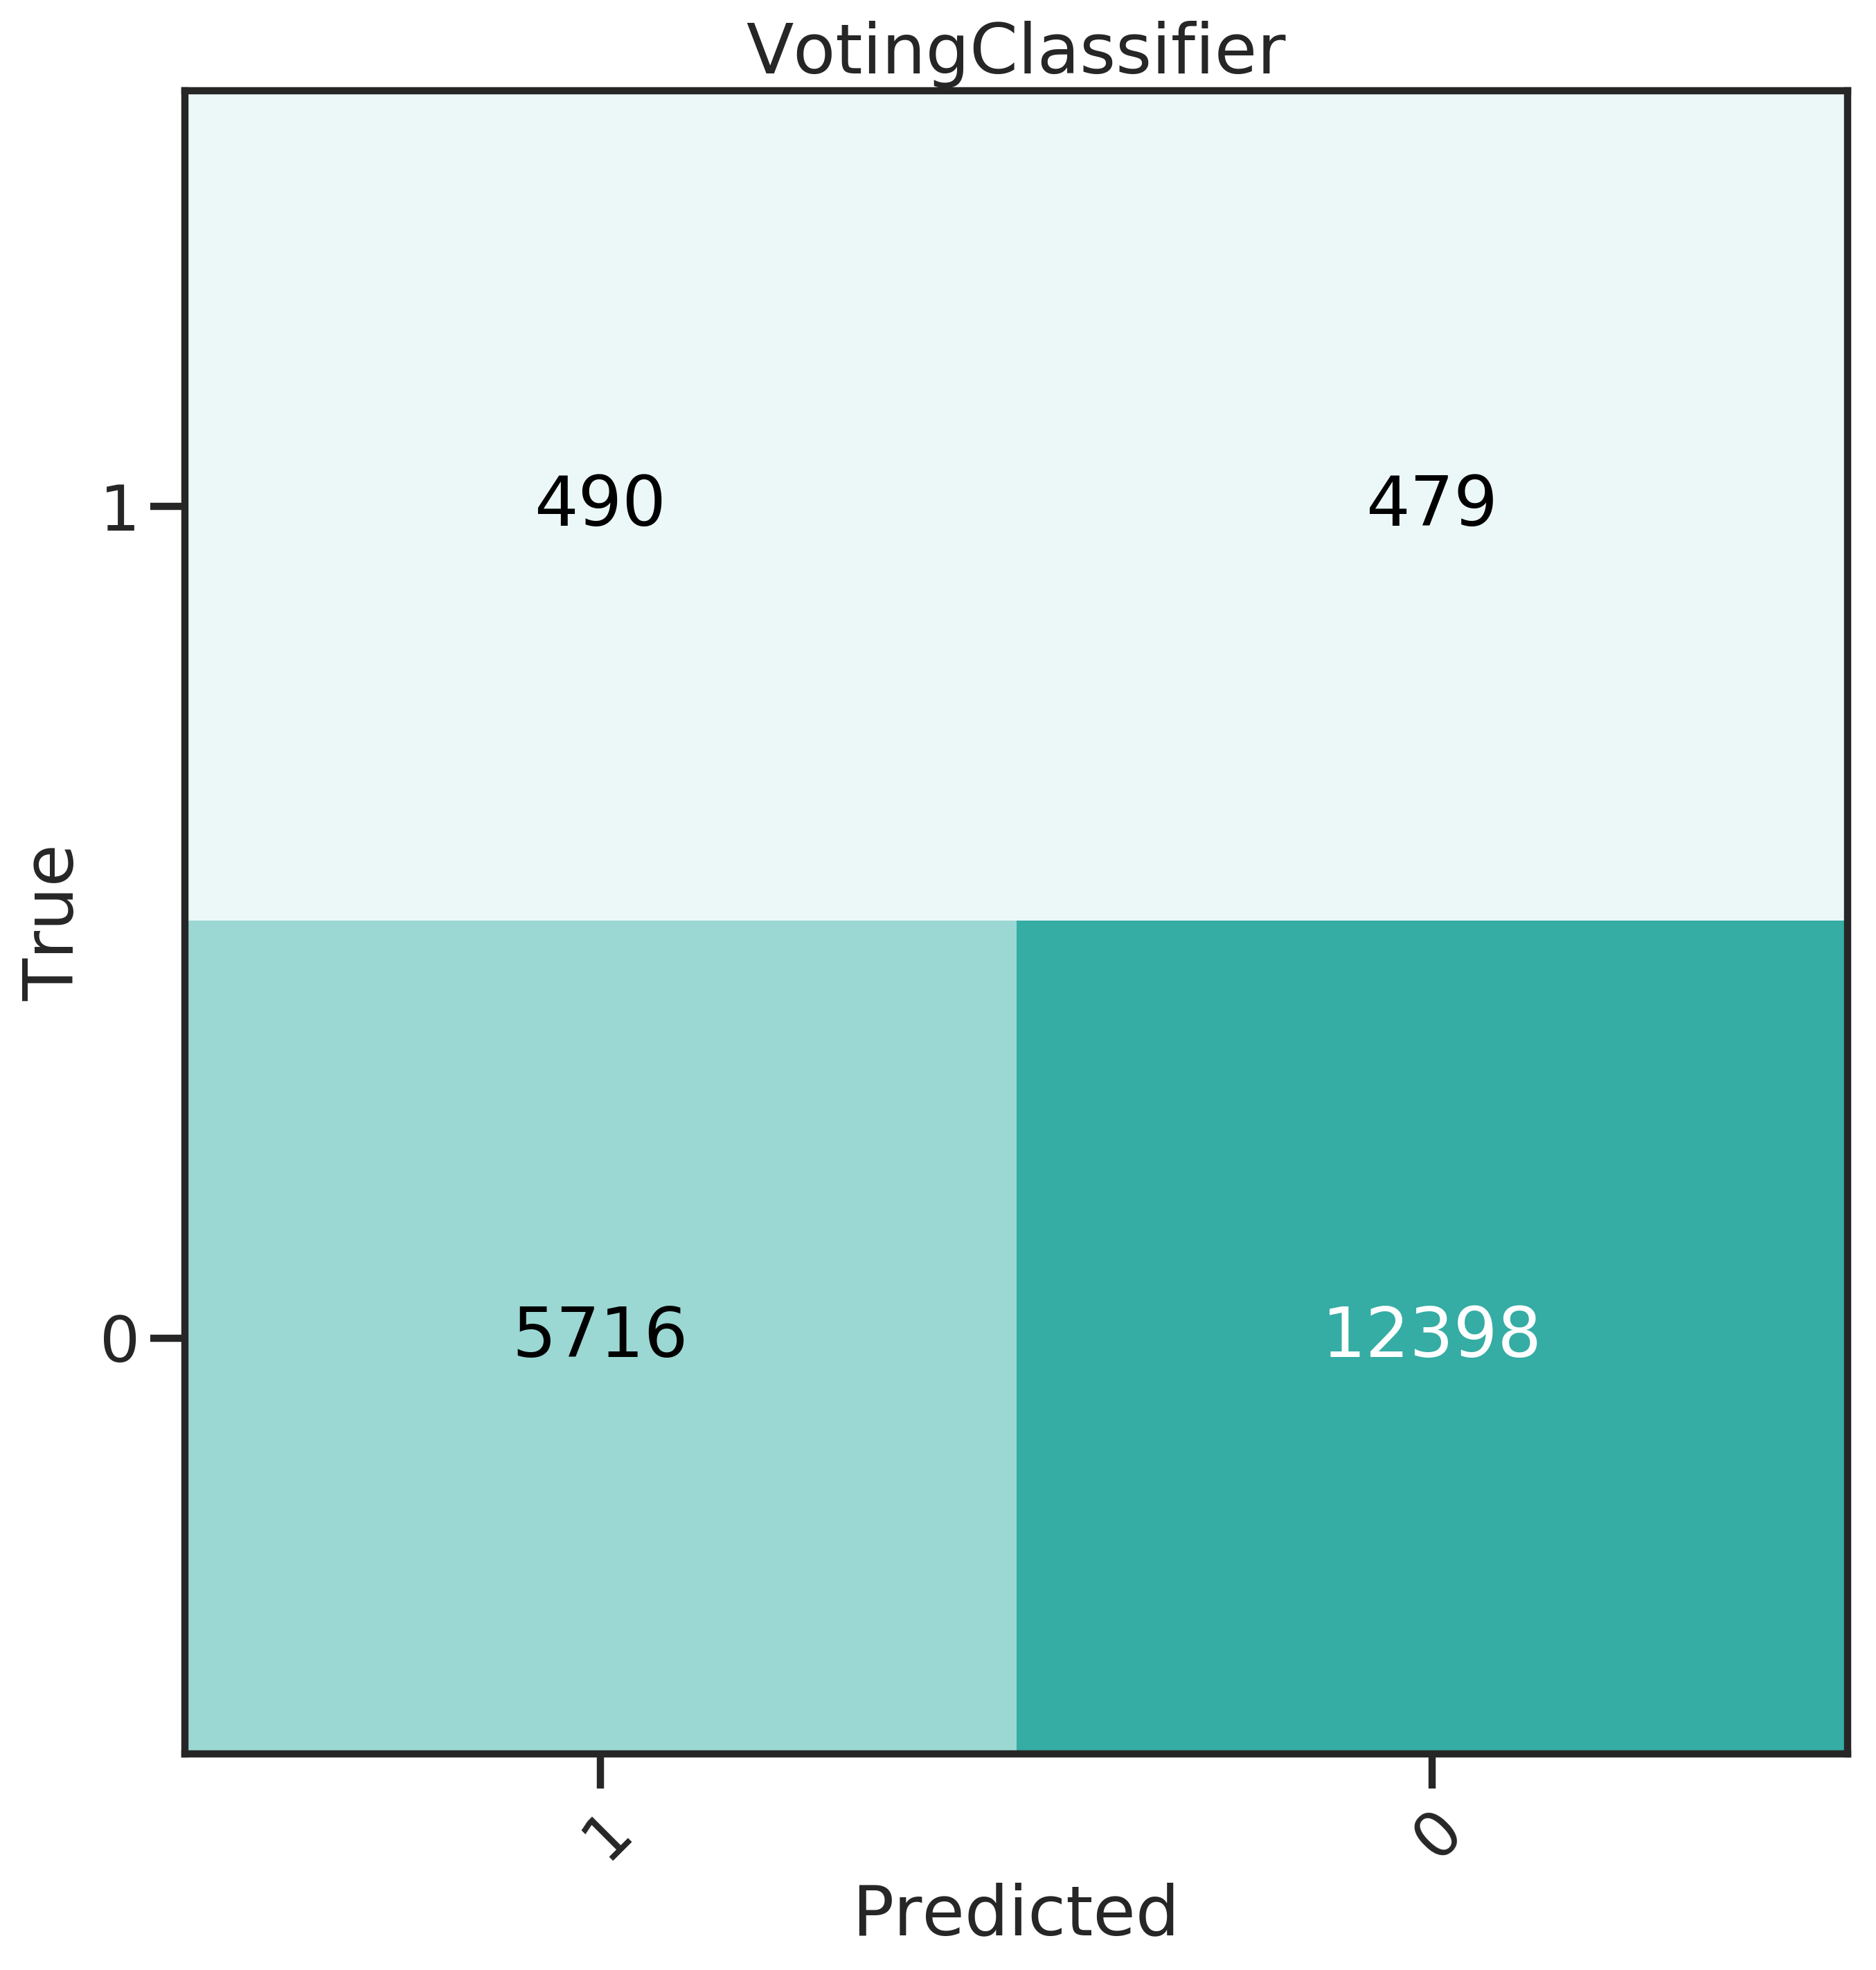

In [551]:
plot_confusion_matrix(y_val.TARGET_B.values, vc.predict(X_val.values), [1,0], title="VotingClassifier")
save_fig("confusion_matrix_voting_classifier")

## Choice of classifier 

As both adjusting the threshold and combining classifiers does not improve the results, the best classifier in terms of recall is selected.

In [641]:
results_file = "classifiers_refit_{}.pkl".format("recall")
with open(pathlib.Path(Config.get("model_store"), results_file), "rb") as f:
    classifiers = pickle.load(f)

classifier = classifiers["GLMnet"]["best_estimator"]

with open(pathlib.Path(Config.get("model_store"), "best_classifier.pkl"), "wb") as f:
    pickle.dump(classifier, f)

In [642]:
Config.get("model_store")

'/data/home/datarian/OneDrive/unine/Master_Thesis/ma-thesis-report/models'

# Regressors for conditional donation amount

## Preparing Model Storage 

In [553]:
def save_models(models, file="learned_models.pkl"):
    with open(pathlib.Path(Config.get("model_store"), file), "wb") as f:
        pickle.dump(models, f)

In [554]:
def load_models(file="learned_models.pkl"):
    result_store = pathlib.Path(
        Config.get("model_store"), file)
    if result_store.is_file():
        with open(result_store, "rb") as f:
            models = pickle.load(f)
    else:
        models = {m:  {"model": None, "best_score": -1}
                  for m in ["Classifier", "Regressor_RF", "Regressor_Enet", "Regressor_BR", "Regressor_SVR"]}
        save_models(models, file)
    return models

In [555]:
def store_model(model_id, estimator, score, model_store, ignore_score=False):
    if not model_id in ["Classifier", "Regressor_RF", "Regressor_Enet", "Regressor_BR", "Regressor_SVR"]:
        print("{} is not a valid model id. Not storing.".format(model_id))
    if score > model_store[model_id]["best_score"] or ignore_score:
        model_store[model_id]["best_score"] = score
        model_store[model_id]["model"] = estimator
        save_models(model_store)
    else:
        print("No improvement over previous fit. Not storing model {}".format(model_id))
    return model_store

In [556]:
models = load_models()

## Creating $\mathbf{X}_d, y_d$

We select all examples who did donate (where $TARGET\_B = 1$) and create $X_d, y_d$. This sample is then used to build a model that predicts donation amounts.

In [568]:
mask = learning["targets"].TARGET_B.astype("int").astype("bool") # Use training set here? -> Training set, since the n's have to be equal between the two estimators
scaler = PowerTransformer(method="yeo-johnson", standardize=True)

In [569]:
X_d = X_train.loc[mask, :].values
X_d_transformed = scaler.fit_transform(X_d)
X_d.shape

(3874, 58)

In [570]:
y_d = y_train.loc[mask, "TARGET_D"].values
y_d.shape

(3874,)

### Transforming $y_d$

Rgression models perform better if the target is close to a normal distribution. We therefore transform the target before training.

In [ ]:
try:
    with open(pathlib.Path(Config.get("model_store"), "target_d_transformer.pkl"), "rb") as f:
        target_transformer = pickle.load(f)
except IOError:
    target_transformer = PowerTransformer(method="box-cox", standardize=True)
    target_transformer.fit(np.array(y_d).reshape(-1,1))
    with open(pathlib.Path(Config.get("model_store"), "target_d_transformer.pkl"), "wb") as f:
        pickle.dump(target_transformer, f)
    
y_d_transformed = target_transformer.transform(np.array(y_d).reshape(-1,1)).ravel()

Box-Cox param:

In [572]:
target_transformer.lambdas_[0]

0.023925862084392815

### Distribution of target before and after transformation

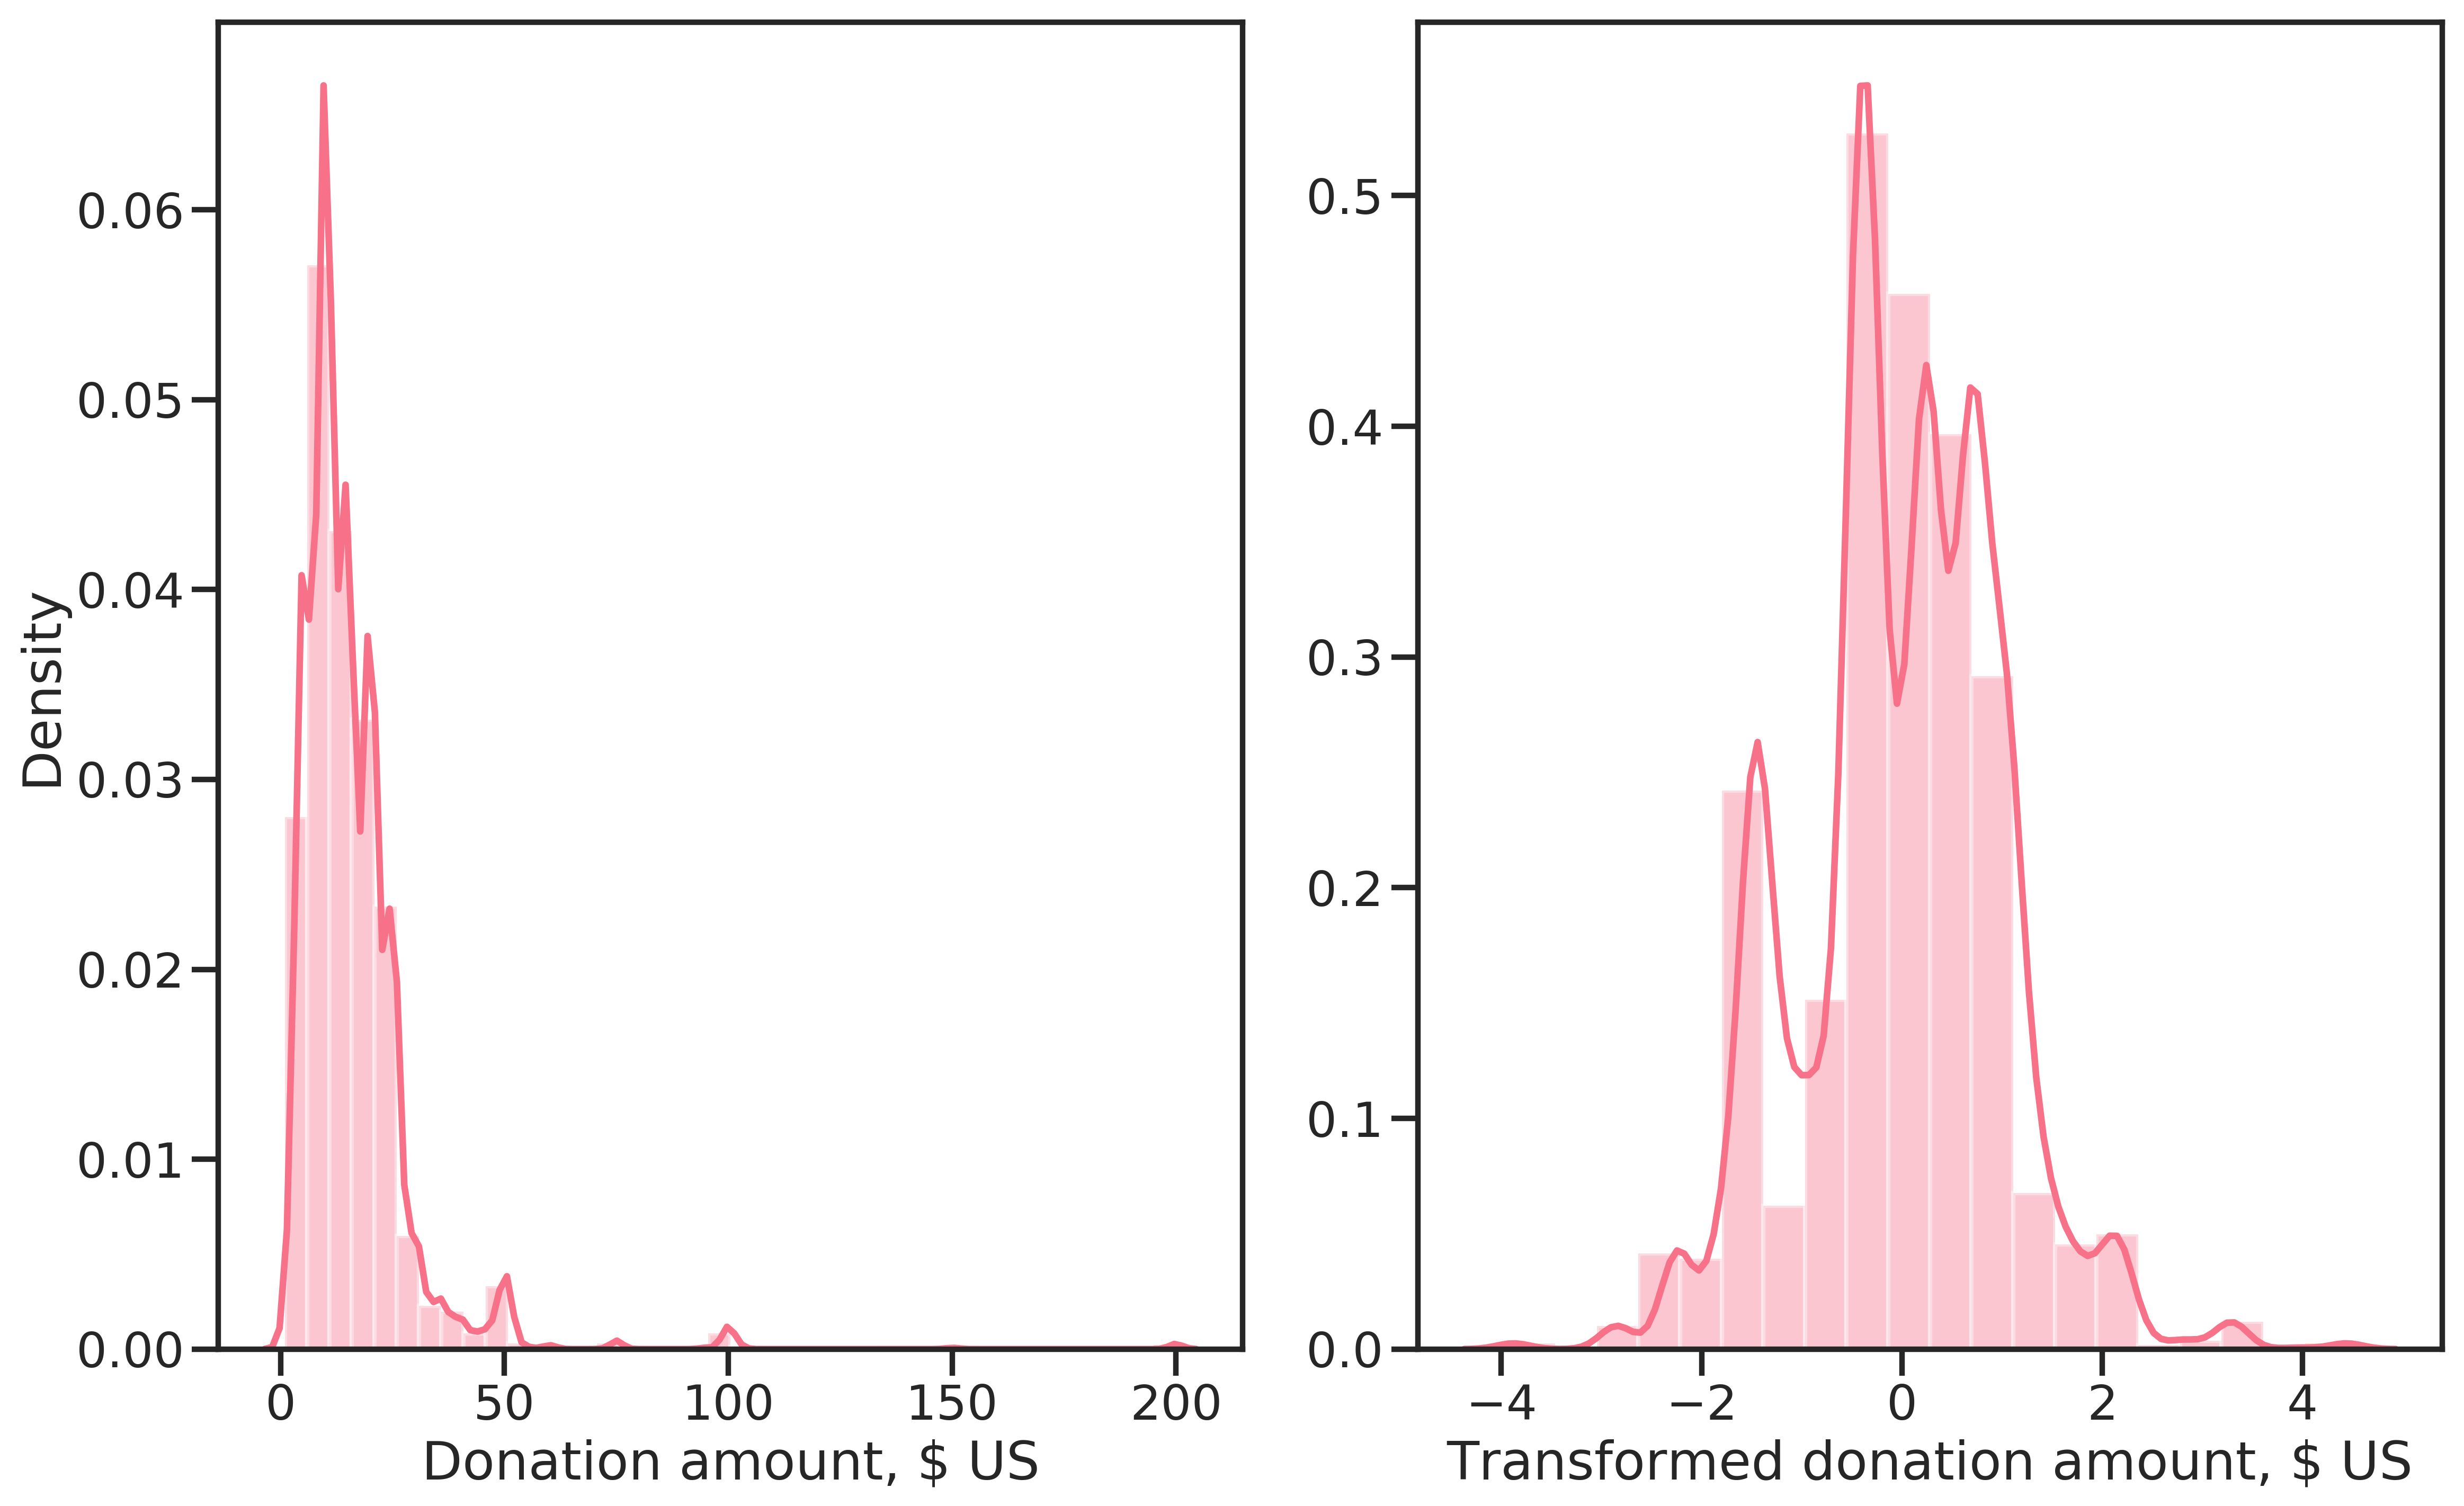

In [828]:
plt.subplot(1,2,1)
ax1 = sns.distplot(y_d, bins=40)
ax1.set(xlabel='Donation amount, $ US', ylabel="Density")
plt.subplot(1,2,2)
ax2 = sns.distplot(y_d_transformed, bins=20)
ax2.set(xlabel='Transformed donation amount, $ US')
save_fig("target_d-distributions-before-after-transformation")

### Initializing Regressors

In [577]:
experiments = {m: {"regressor": None,
                   "run": False}
               for m in ["Regressor_RF", "Regressor_Enet", "Regressor_BR", "Regressor_SVR"]}

#### Random Forest Regressor

In [578]:
rf_regressor = RandomForestRegressor(
    random_state=Config.get("random_seed"),
    max_depth=7,
    min_samples_leaf=5,
    min_samples_split=4,
    n_estimators=1300,
    n_jobs = -1,
    verbose = 1
)

rf_param_grid = {
    "min_samples_leaf": sp_rint(1,6),
    "min_samples_split": sp_rint(2,6),
    "max_depth": sp_rint(4,8),
    "n_estimators": sp_discr(values=([1000, 1050, 1100, 1150, 1200], [1/5]*5)),
}

rf = RandomizedSearchCV(
    rf_regressor,
    rf_param_grid,
    cv=10,
    scoring=make_scorer(r2_score),
    random_state=Config.get("random_seed"),
    refit=True,
    verbose=1,
    n_jobs=-1
)

In [597]:
models["Regressor_RF"]["model"].best_params_

{'max_depth': 5,
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'n_estimators': 1000}

In [602]:
experiments["Regressor_RF"]["regressor"] = rf
experiments["Regressor_RF"]["run"] = False

#### ElasticNet

In [583]:
from glmnet import ElasticNet

enet_regressor = ElasticNet(
    n_splits=10,
    fit_intercept = True,
    standardize=True,
    n_jobs=-1,
    random_state=Config.get("random_seed")
)

enet_param_grid = {
    "alpha": sp_discr(values=([0.0,0.1,0.2,0.5,0.6,0.7,0.8,0.85,0.9,0.95,0.98,1.0],[1/12]*12))
}

enet = RandomizedSearchCV(
    enet_regressor,
    enet_param_grid,
    cv=10,
    scoring=make_scorer(r2_score),
    random_state=Config.get("random_seed"),
    refit=True,
    verbose=1,
    n_jobs=-1
)

In [603]:
experiments["Regressor_Enet"]["regressor"] = enet
experiments["Regressor_Enet"]["run"] = False

Pure ridge regression was chosen:

In [652]:
models["Regressor_Enet"]["model"].best_estimator_.alpha

0

A look at the L1 ratio, with 0 = pure ridge and 1 = pure lasso.

In [645]:
models["Regressor_Enet"]["model"]

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=ElasticNet(alpha=1, cut_point=1.0, fit_intercept=True, lambda_path=None,
      lower_limits=-inf, max_features=None, max_iter=100000,
      min_lambda_ratio=0.0001, n_jobs=-1, n_lambda=100, n_splits=10,
      random_state=42, scoring=None, standardize=True, tol=1e-07,
      upper_limits=inf, verbose=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_sample object at 0x7ff56b12b160>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=make_scorer(r2_score),
          verbose=1)

#### Bayesian Ridge

In [587]:
from sklearn.linear_model import BayesianRidge

br = BayesianRidge(normalize=True)

In [604]:
experiments["Regressor_BR"]["regressor"] = br
experiments["Regressor_BR"]["run"] = False

#### Support Vector Regressor

In [632]:
svr_regressor = SVR(gamma = "scale")

svr_params = {
    "regressor__C": sp_discr(values=([70,71,72,73,74,75],[1/6]*6)),
    "regressor__degree": sp_rint(11,15),
    "regressor__gamma": sp_unif(3.8,.5)
}

svr_params = {
    "regressor__C": sp_discr(values=([1,2,5,10,20,100],[1/6]*6)),
}

svr_scaler = PowerTransformer(method="yeo-johnson", standardize=True)

svr_pipe = Pipeline([
    ("scaler", svr_scaler),
    ("regressor", svr_regressor)
])


svr = RandomizedSearchCV(
    svr_pipe,
    svr_params,
    cv=10,
    scoring=make_scorer(r2_score),
    random_state=Config.get("random_seed"),
    refit=True,
    verbose=1,
    n_jobs=-1
)

In [628]:
experiments["Regressor_SVR"]["regressor"] = svr
experiments["Regressor_SVR"]["run"] = True

In [631]:
models["Regressor_SVR"]["model"].best_params_

{'regressor__C': 1}

In [622]:
svr = models["Regressor_SVR"]["model"]

In [624]:
svr_es = svr.best_estimator_.named_steps["regressor"]

In [626]:
svr_es

SVR(C=1, cache_size=200, coef0=0.0, degree=83, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

## Fitting and results 

### Splitting into learning and validation sets 

Learning data is split 80/20:

In [873]:
seed = Config.get("random_seed")
from sklearn.model_selection import train_test_split

X_d_train, X_d_val, y_d_train, y_d_val = train_test_split(X_d, y_d_transformed, test_size=0.2, random_state=Config.get("random_seed"))

Run all experiments, store best models and best score:

In [630]:
for e in experiments.keys():
    print("*****************************************************************************")
    if experiments[e]["run"]:
        experiments[e]["regressor"].fit(X_d_train, y_d_train)
    score = experiments[e]["regressor"].score(X_d_val,y_d_val)
    print("Score for {}: {}".format(e, score))
    models = store_model(e, experiments[e]["regressor"], score, models, ignore_score=True)

*****************************************************************************


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.3s finished


Score for Regressor_RF: 0.7218703824420221
*****************************************************************************
Score for Regressor_Enet: 0.6157031077164954
*****************************************************************************
Score for Regressor_BR: 0.6639336690804092
*****************************************************************************
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   34.9s finished


Score for Regressor_SVR: 0.6986457099727399


### Comparison of $R^2$ for the models 

We choose the regressor with the best $R^2$.

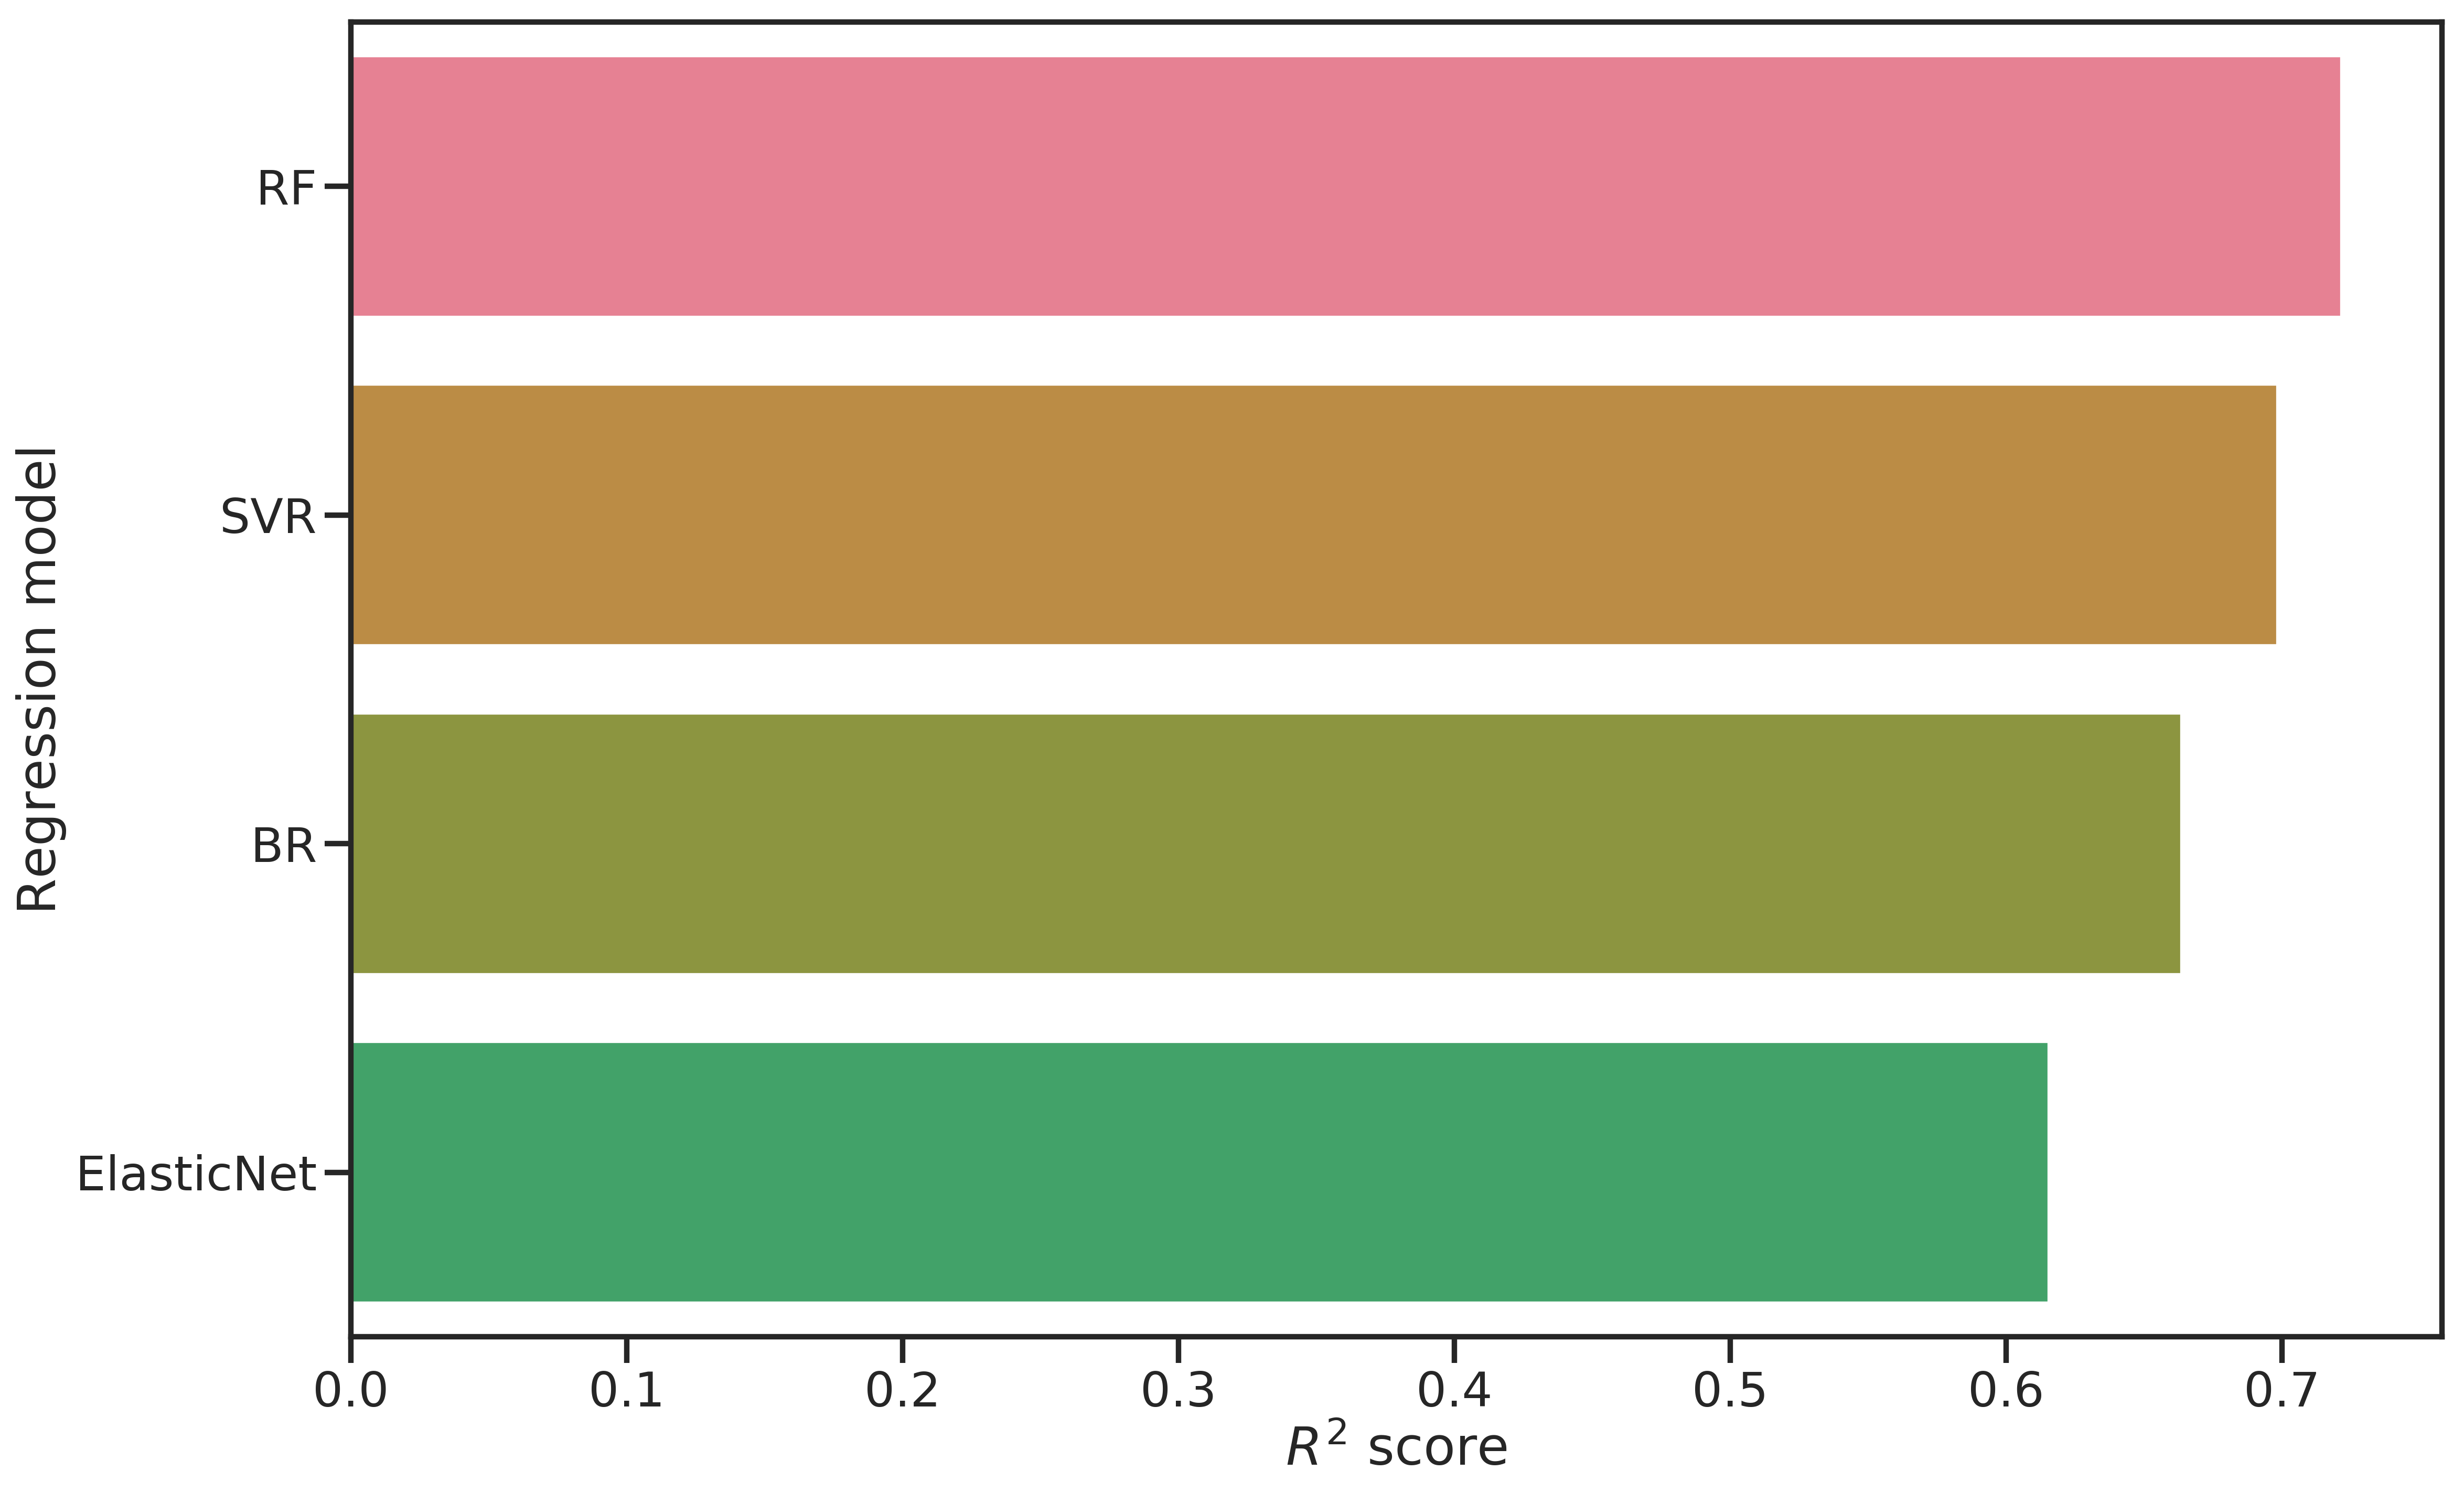

In [720]:
results_r2 = pd.DataFrame({
    "RF": {"score": models["Regressor_RF"]["best_score"]},
    "ElasticNet": {"score": models["Regressor_Enet"]["best_score"]},
    "BR": {"score": models["Regressor_BR"]["best_score"]},
    "SVR": {"score": models["Regressor_SVR"]["best_score"]}
}).T.sort_values(by="score", ascending=False)
ax = sns.barplot(x=results_r2.score,y=results_r2.index, palette=Config.get("qual_palette"))
ax.set(xlabel='$R^2$ score', ylabel="Regression model")
save_fig("regressor-score-comparison")

In [721]:
results_r2

score
RF          0.721870
SVR         0.698646
BR          0.663934
ElasticNet  0.615703

By $R^2$, we choose the random forest.

### RMSE

In [637]:
results_rmse

score
ElasticNet  20.020914
BR          19.950429
RF          19.937697
SVR         19.885076

The selection is confirmed by RMSE as well

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.3s finished


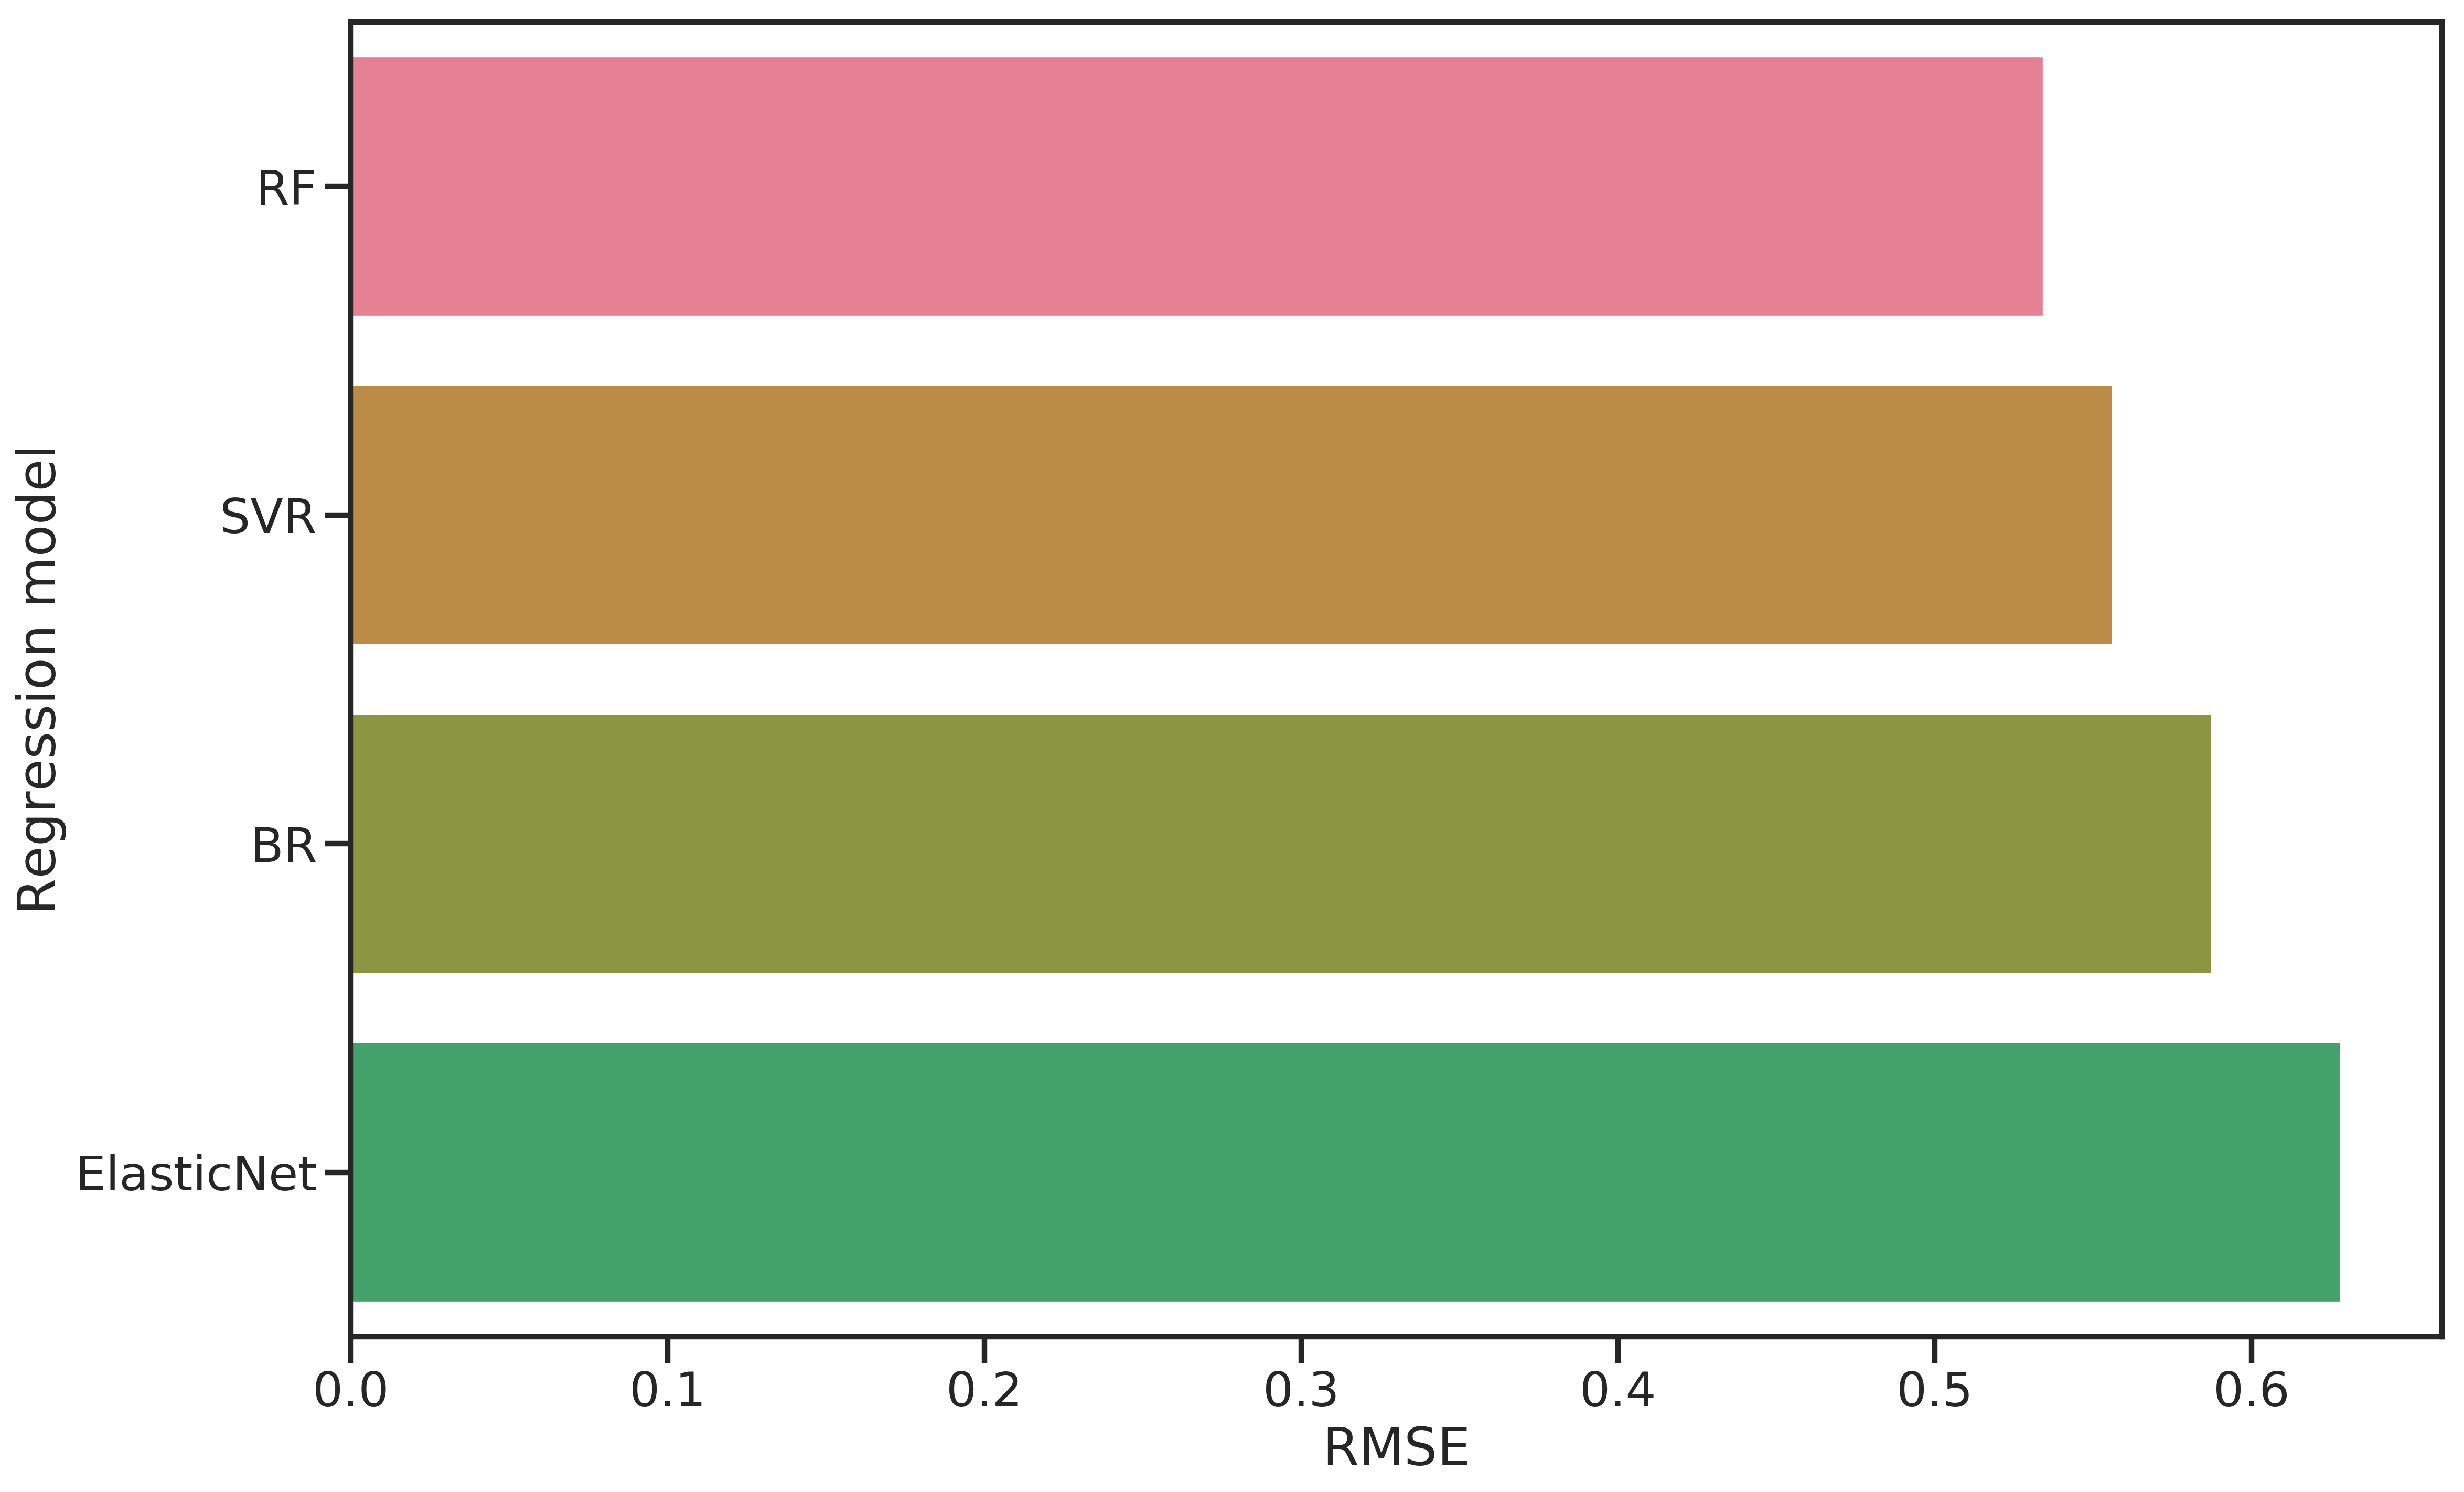

In [639]:
from sklearn.metrics import mean_squared_error

results_rmse = pd.DataFrame({
    "RF": {"score": np.sqrt(mean_squared_error(y_d_val, models["Regressor_RF"]["model"].predict(X_d_val)))},
    "ElasticNet": {"score": np.sqrt(mean_squared_error(y_d_val, models["Regressor_Enet"]["model"].predict(X_d_val)))},
    "BR": {"score": np.sqrt(mean_squared_error(y_d_val, models["Regressor_BR"]["model"].predict(X_d_val)))},
    "SVR": {"score": np.sqrt(mean_squared_error(y_d_val, models["Regressor_SVR"]["model"].predict(X_d_val)))},
}).T.sort_values(by="score", ascending=True)
ax = sns.barplot(x=results_rmse.score,y=results_rmse.index, palette=Config.get("qual_palette"))
ax.set(xlabel='RMSE', ylabel="Regression model")
save_fig("regressor-rmse-comparison")

$P(D=1|Z)= \phi(Z\gamma)$ where $\phi$ is the CDF of the normal distribution and $Z\gamma$ is the learned model applied to the examples.

Looking at the distribution of our predictions, we see that it is skewed. A Box-Cox transformation is therefore applied to transform the distribution and make it as normal as possible.

### Predicted Target Distributions

The distributions have some differences in the center. RF and SVR do not capture the high-dollar donors. Bayesian Ridge and ElasticNet succeed at predicting those.

In [634]:
y_d_svr = models["Regressor_SVR"]["model"].predict(X_d)
y_d_rf = models["Regressor_RF"]["model"].predict(X_d)
y_d_br = models["Regressor_BR"]["model"].predict(X_d)
y_d_enet = models["Regressor_Enet"]["model"].predict(X_d)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.3s finished


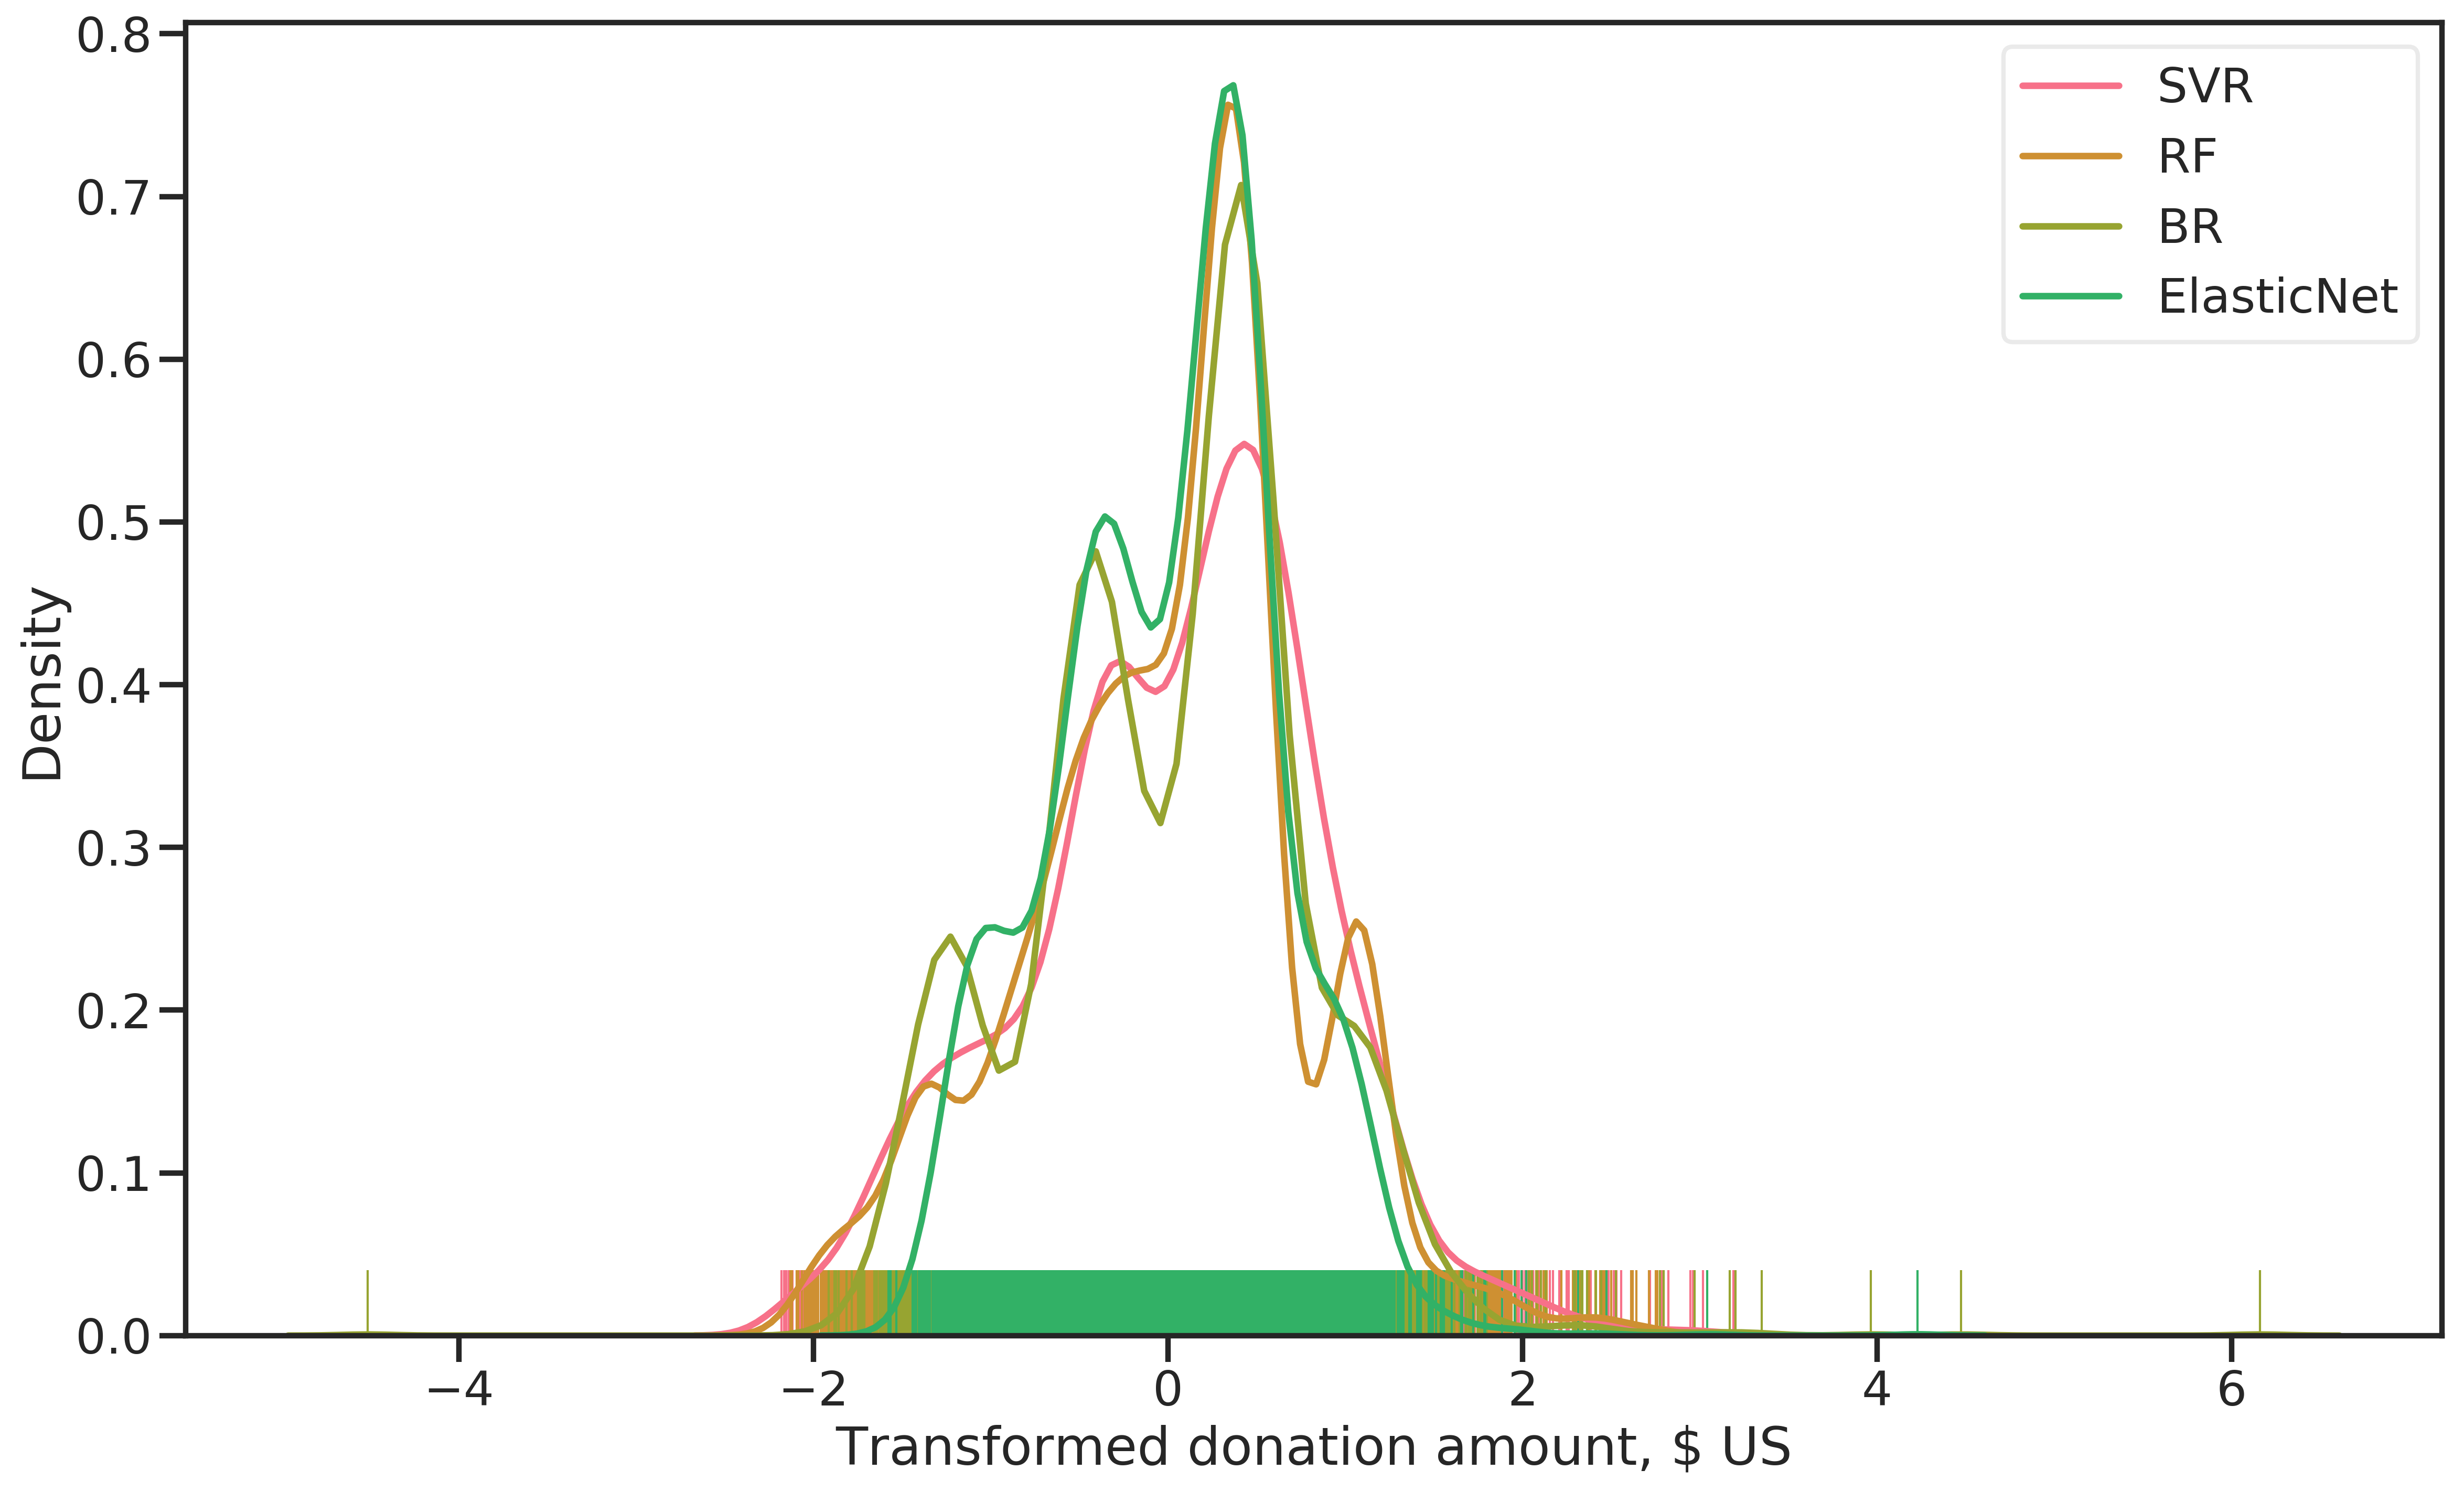

In [635]:
fig, ax = plt.subplots(1,1)
sns.distplot(y_d_svr, hist=False, rug=True, kde_kws={"label": "SVR"})
sns.distplot(y_d_rf, hist=False, rug=True, kde_kws={"label": "RF"})
sns.distplot(y_d_br, hist=False, rug=True, kde_kws={"label": "BR"})
sns.distplot(y_d_enet, hist=False, rug=True, kde_kws={"label": "ElasticNet"})
ax.set(ylabel="Density", xlabel="Transformed donation amount, $ US")
save_fig("regressor-predictions-comparison")

### Choice of regressor 

In [795]:
t = models["Regressor_RF"]["model"]

In [801]:
t.best_estimator_.estimators_

[DecisionTreeRegressor(criterion='mse', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1608637542, splitter='best'),
 DecisionTreeRegressor(criterion='mse', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1273642419, splitter='best'),
 DecisionTreeRegressor(criterion='mse', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1935803228, splitter='best'),
 DecisionTreeRegressor(crite

In [802]:
importance_reg = models["Regressor_RF"]["model"].best_estimator_.feature_importances_
importance_reg = pd.DataFrame(importance_reg, index=X_train.columns, 
                          columns=["Importance"])
feature_names = X_train.columns.values.tolist()
importances = []
for tree in models["Regressor_RF"]["model"].best_estimator_.estimators_:
    for k,f in enumerate(tree.feature_importances_):
        name = feature_names[k]
        importances.append({"feature": name, "importance": f})
        
importances = pd.DataFrame(importances)

In [803]:
importances_grouped = importances.groupby("feature").mean().reset_index().sort_values("importance", ascending=False)

In [804]:
ordering = list(importances_grouped.feature)

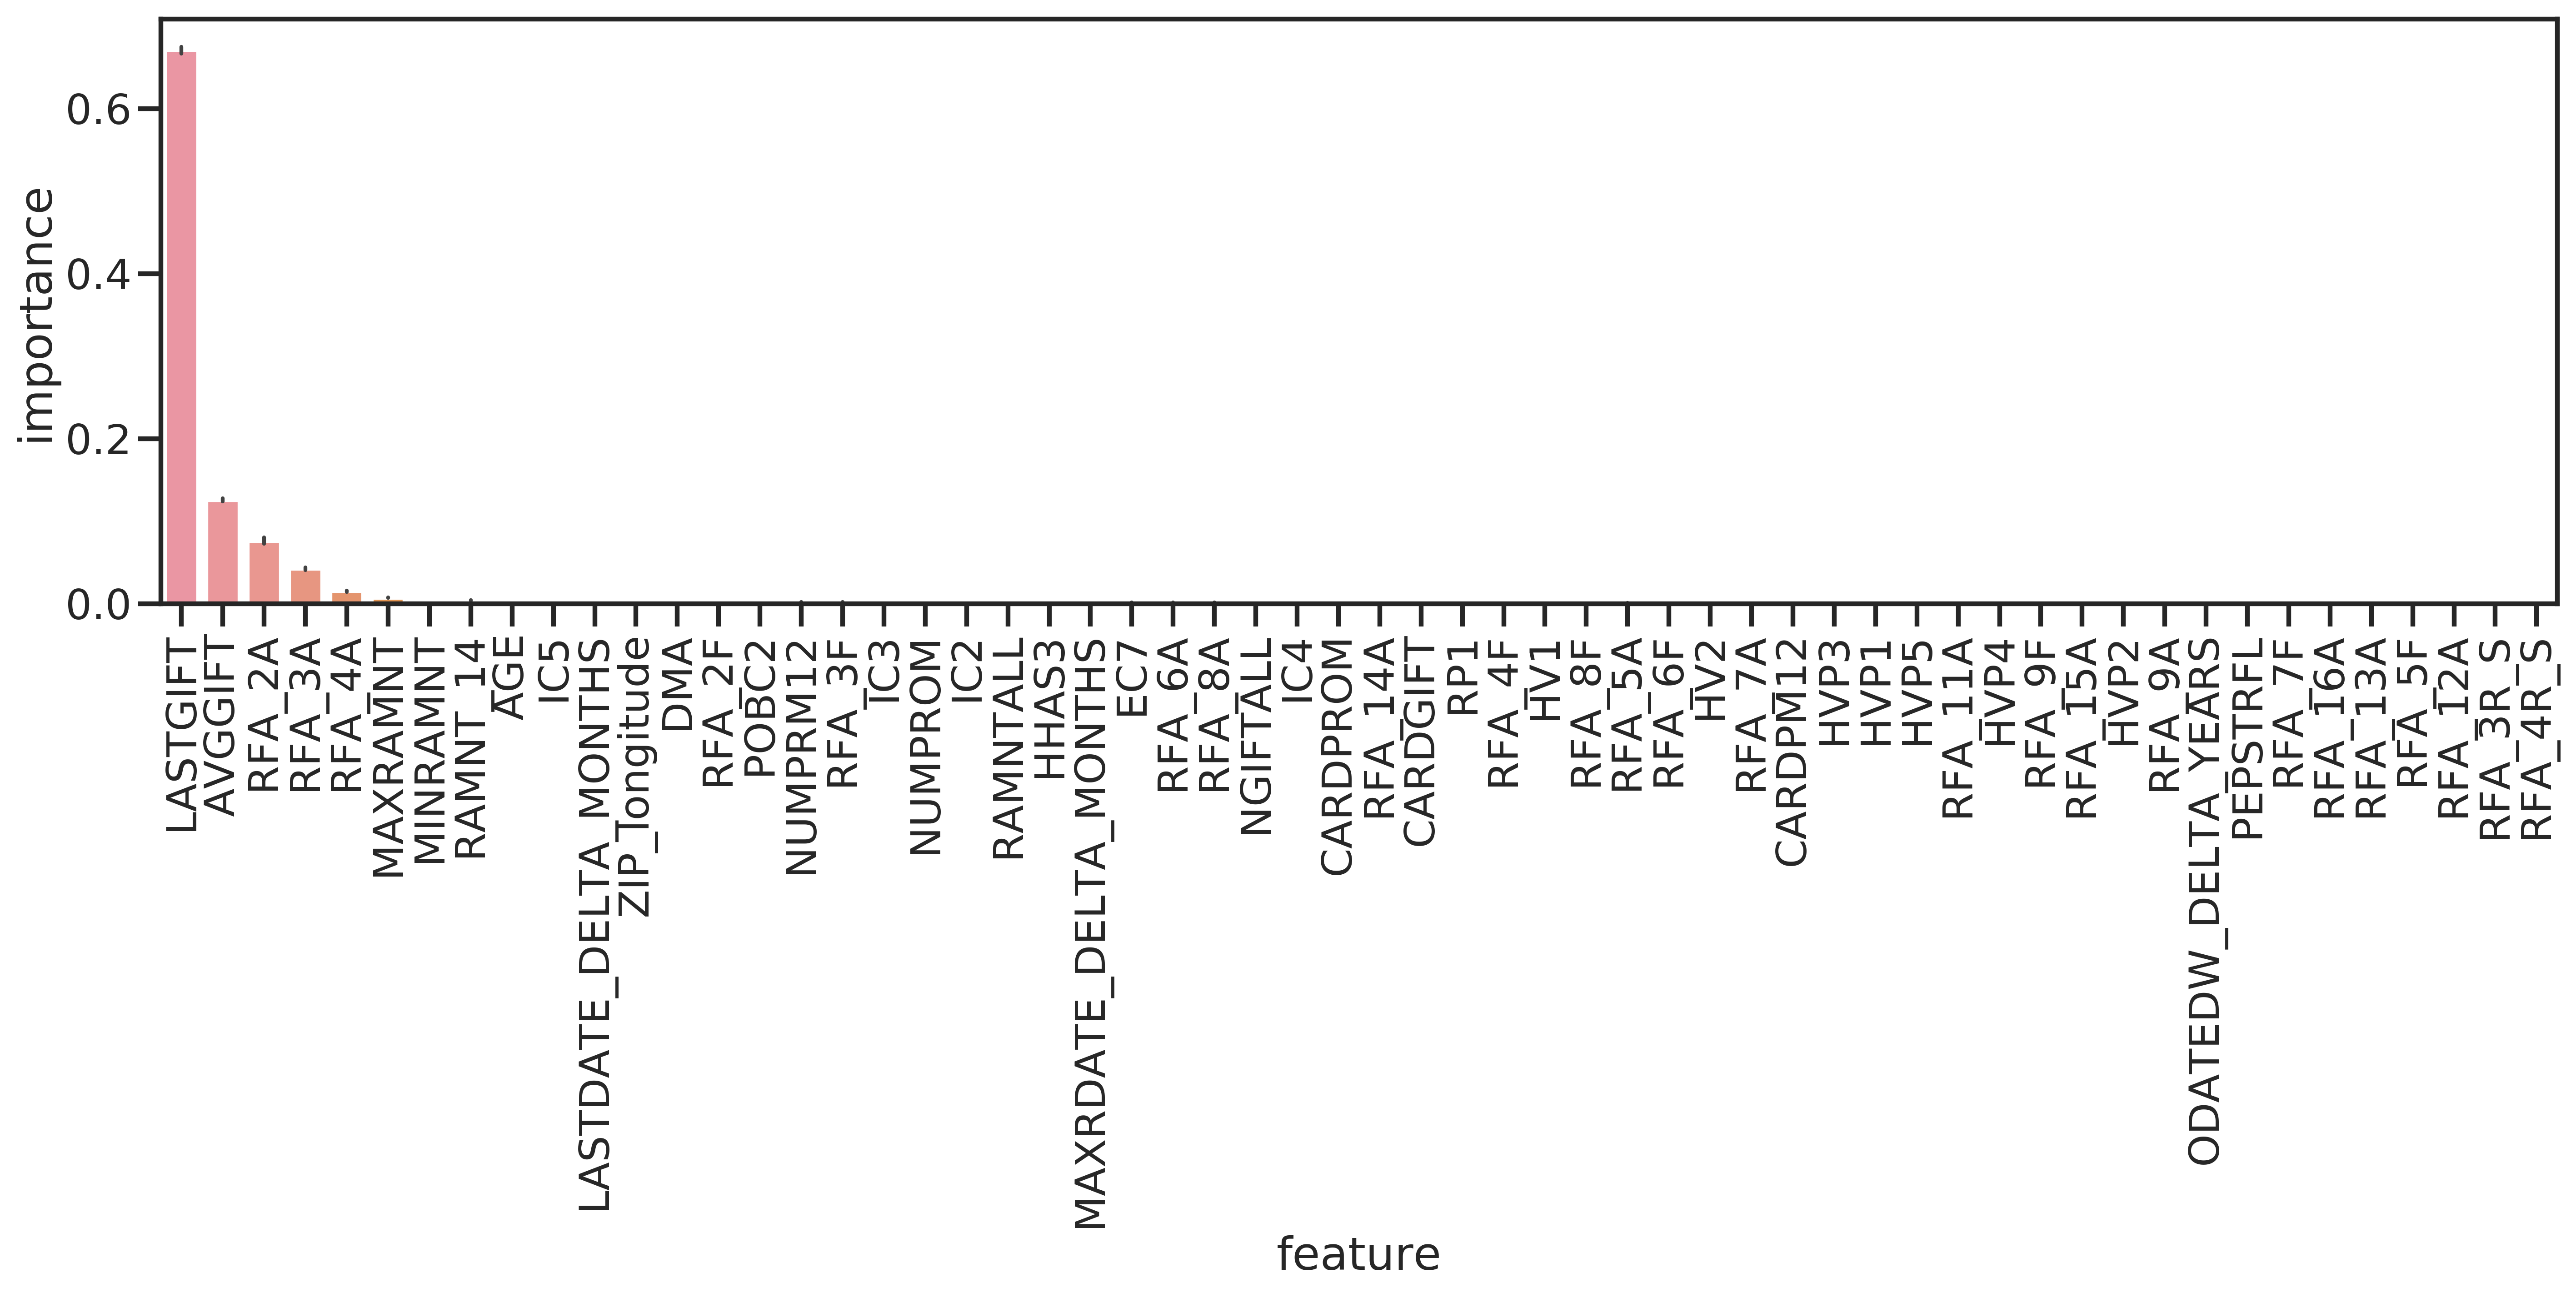

In [805]:
plt.rcParams['figure.figsize'] = (1.618*12, 10)
ax = sns.barplot(x="feature", y="importance", order = ordering, ci=50, errwidth=2.0, data=importances)
for item in ax.get_xticklabels(): item.set_rotation(90)
save_fig("feature-importance-rf-regression")

In [640]:
regressor = models["Regressor_RF"]["model"].best_estimator_

with open(pathlib.Path(Config.get("model_store"), "best_regressor.pkl"), "wb") as f:
    pickle.dump(regressor, f)